In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [6]:
from importlib import reload

import pickle
import time

import numpy as np
import tensorflow as tf
import logging
from scipy import linalg
from scipy import optimize
from scipy import sparse
from scipy import special

import matplotlib.pyplot as plt

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,inputs

2024-03-16 12:38:12.128489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


# Define Network Parameters

In [7]:
def fio_rect(x):
#     x[x<0] = 0
#     return x
    return np.fmax(x,0)

In [8]:
N = 96
Nret = N
Nlgn = N

xs,ys = np.meshgrid(np.arange(N)/N,np.arange(N)/N)
dxs = np.abs(xs.flatten()[:,None] - xs.flatten()[None,:])
dxs[dxs > 0.5] = 1 - dxs[dxs > 0.5]
dys = np.abs(ys.flatten()[:,None] - ys.flatten()[None,:])
dys[dys > 0.5] = 1 - dys[dys > 0.5]
ds = np.sqrt(dxs**2 + dys**2)

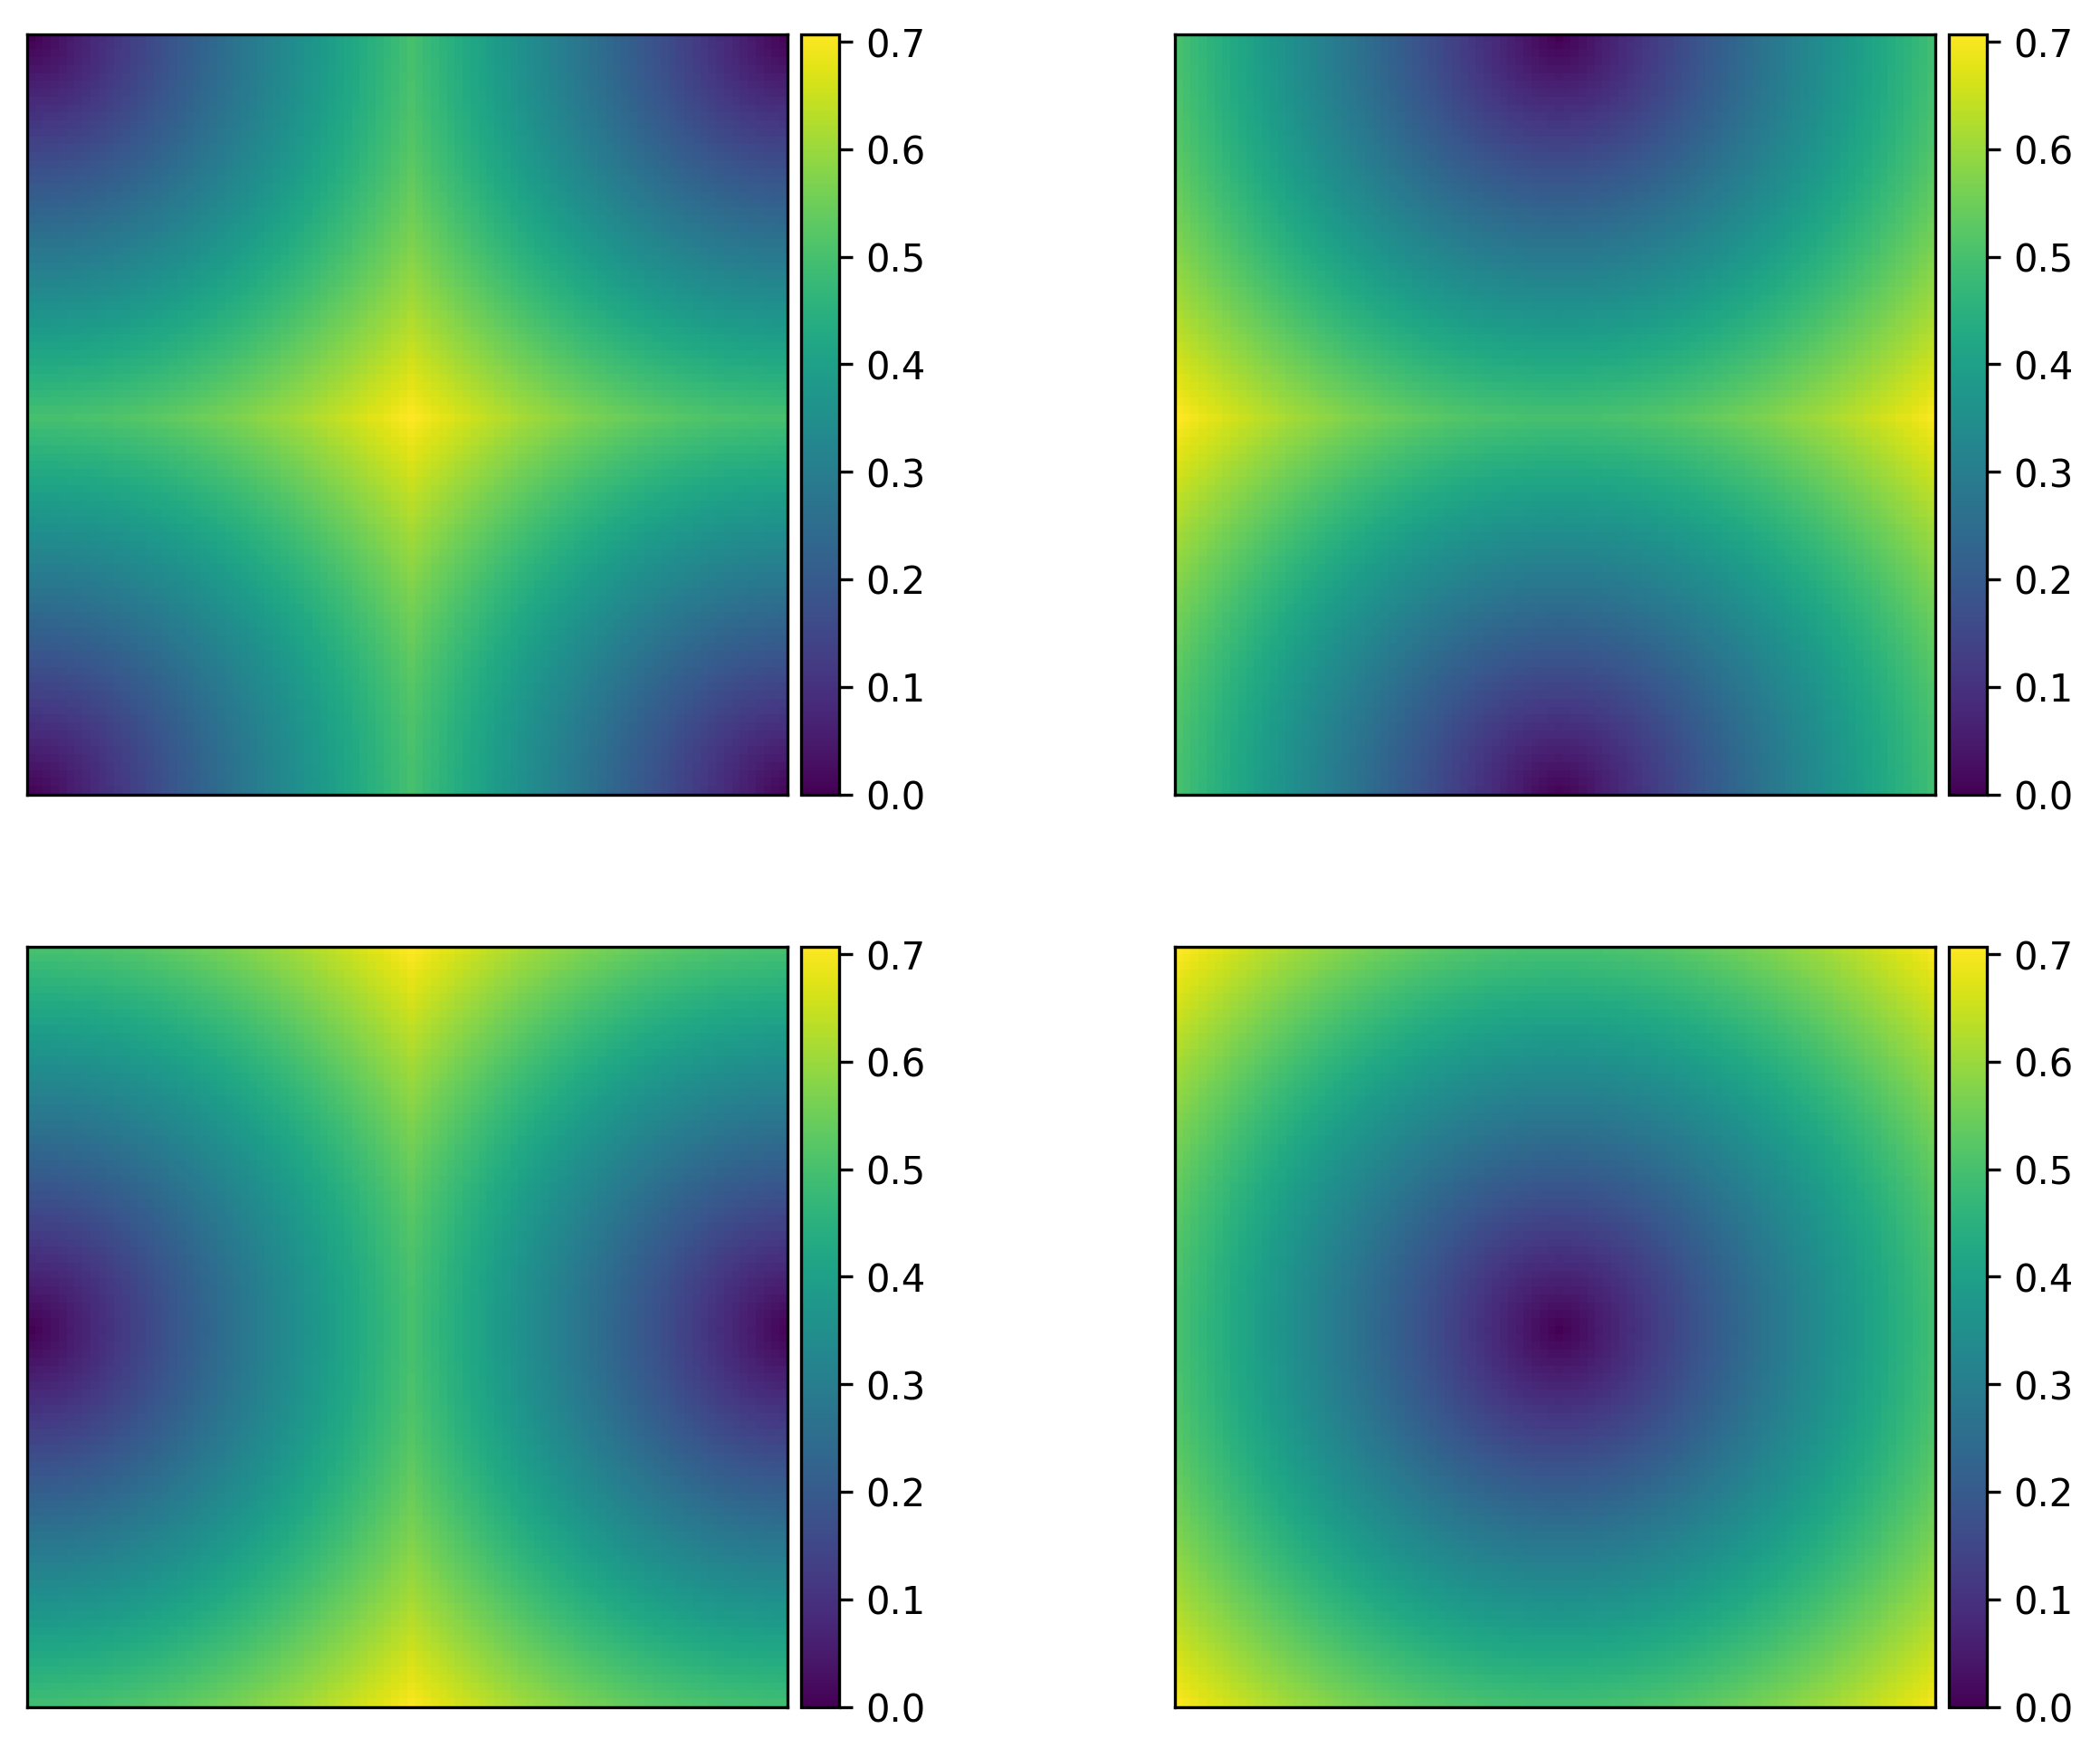

In [9]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

pf.imshowbar(fig,axs[0,0],ds.reshape(N,N,N,N)[0,0,:,:],cmap='viridis')
pf.imshowbar(fig,axs[0,1],ds.reshape(N,N,N,N)[0,N//2,:,:],cmap='viridis')
pf.imshowbar(fig,axs[1,0],ds.reshape(N,N,N,N)[N//2,0,:,:],cmap='viridis')
pf.imshowbar(fig,axs[1,1],ds.reshape(N,N,N,N)[N//2,N//2,:,:],cmap='viridis')

# Look at Stevens et al LGN Input with IID Retinal Activity

## Build Ret$\to$LGN Connectivity

In [10]:
conn_params = {
    'sigma1':  0.037,
    'sigma2':  0.15,
    'ampl1':   1.0,
    'ampl2':   1.0,
    'noise':   0.0,
    'profile': 'Mexican-hat',
    'stevensetal': True
}

reload(connectivity)

conn = connectivity.Connectivity((N,N),(N,N),0)

In [11]:
WRtoT,_ = conn.create_matrix(conn_params,conn_params['profile'])

In [8]:
dists = np.linspace(0,0.71,72)
bin_idxs = np.digitize(ds,np.linspace(0,0.7,71)+0.005)

WRtoT_d = np.zeros(72)

for idx in range(72):
    WRtoT_d[idx] = np.mean(WRtoT[bin_idxs == idx])

Text(0.5, 1.0, 'Sum of Presynaptic Weights')

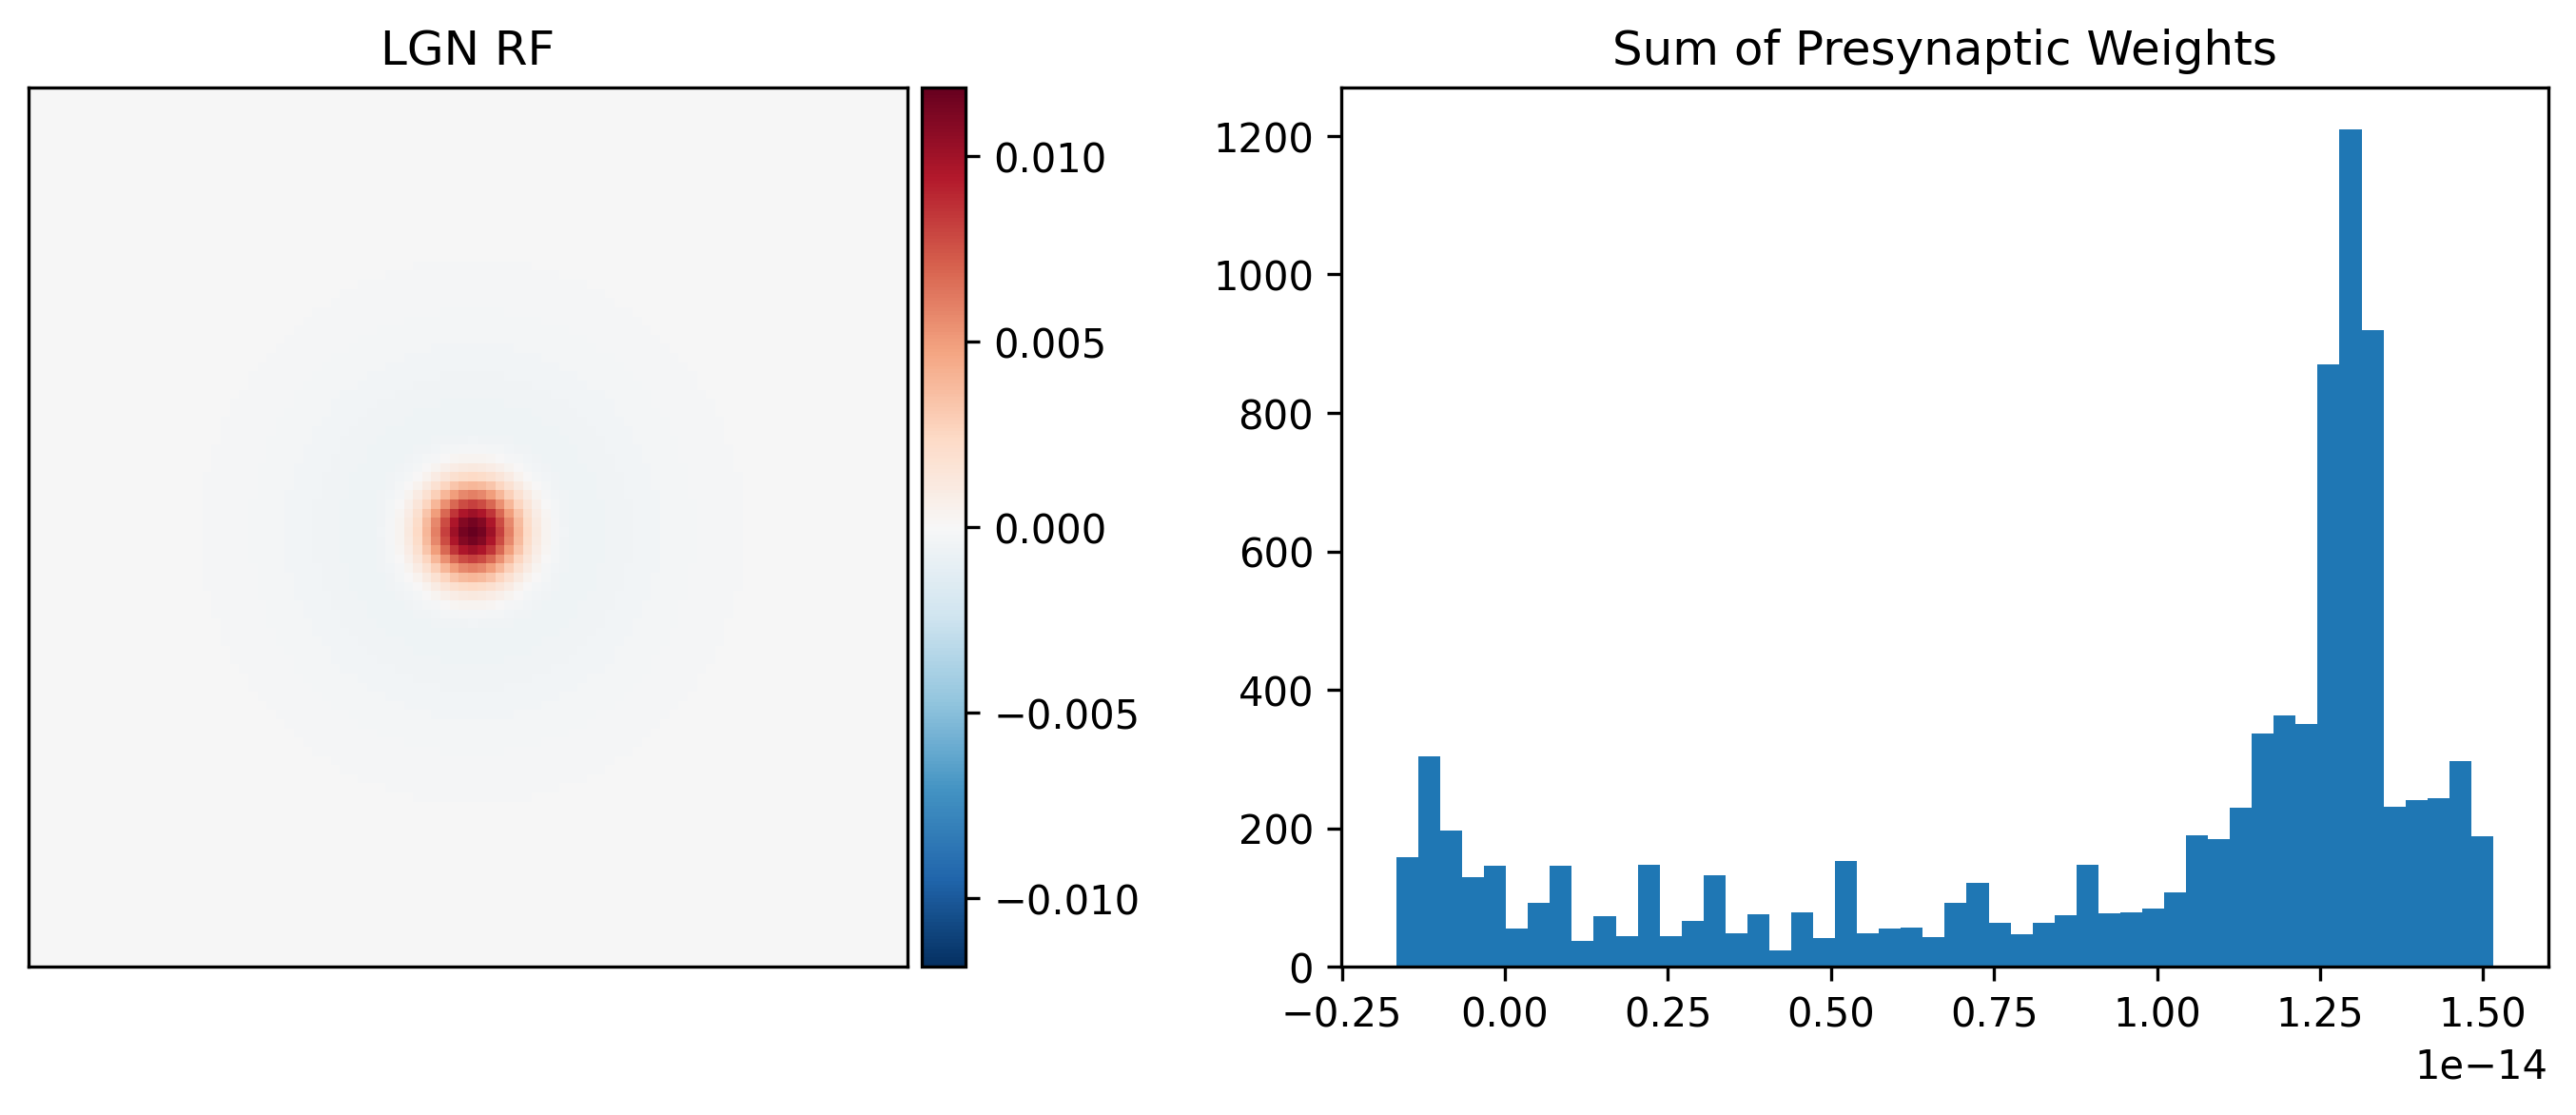

In [9]:
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

pf.imshowbar(fig,axs[0],WRtoT.reshape(N,N,N,N)[N//2,N//2,:,:],
          vmin=-np.max(np.abs(WRtoT)),vmax=np.max(np.abs(WRtoT)))

axs[1].hist(np.sum(WRtoT,1),50)

axs[0].set_title('LGN RF')
axs[1].set_title('Sum of Presynaptic Weights')

## Create Retinal Activity Patterns

In [12]:
def stevens_gauss(x,y,ori,size=0.088388,aspect_ratio=4.66667,grid_size=1.0,n_grid=Nret):
    pts = np.arange(n_grid)*grid_size/n_grid - grid_size/2
    ysigma = size/2.0
    xsigma = aspect_ratio*ysigma
    
    dx,dy = np.meshgrid(pts,pts)
    
    tmp = np.cos(ori)*dx - np.sin(ori)*dy
    dy = np.sin(ori)*dx + np.cos(ori)*dy
    dx = tmp
    
    dx = dx/xsigma
    dy = dy/ysigma
    
    return np.roll(np.exp(-0.5*(dx**2+dy**2)),(x-n_grid//2,y-n_grid//2),(0,1))

Text(0.5, 1.0, 'Off Layer Activation')

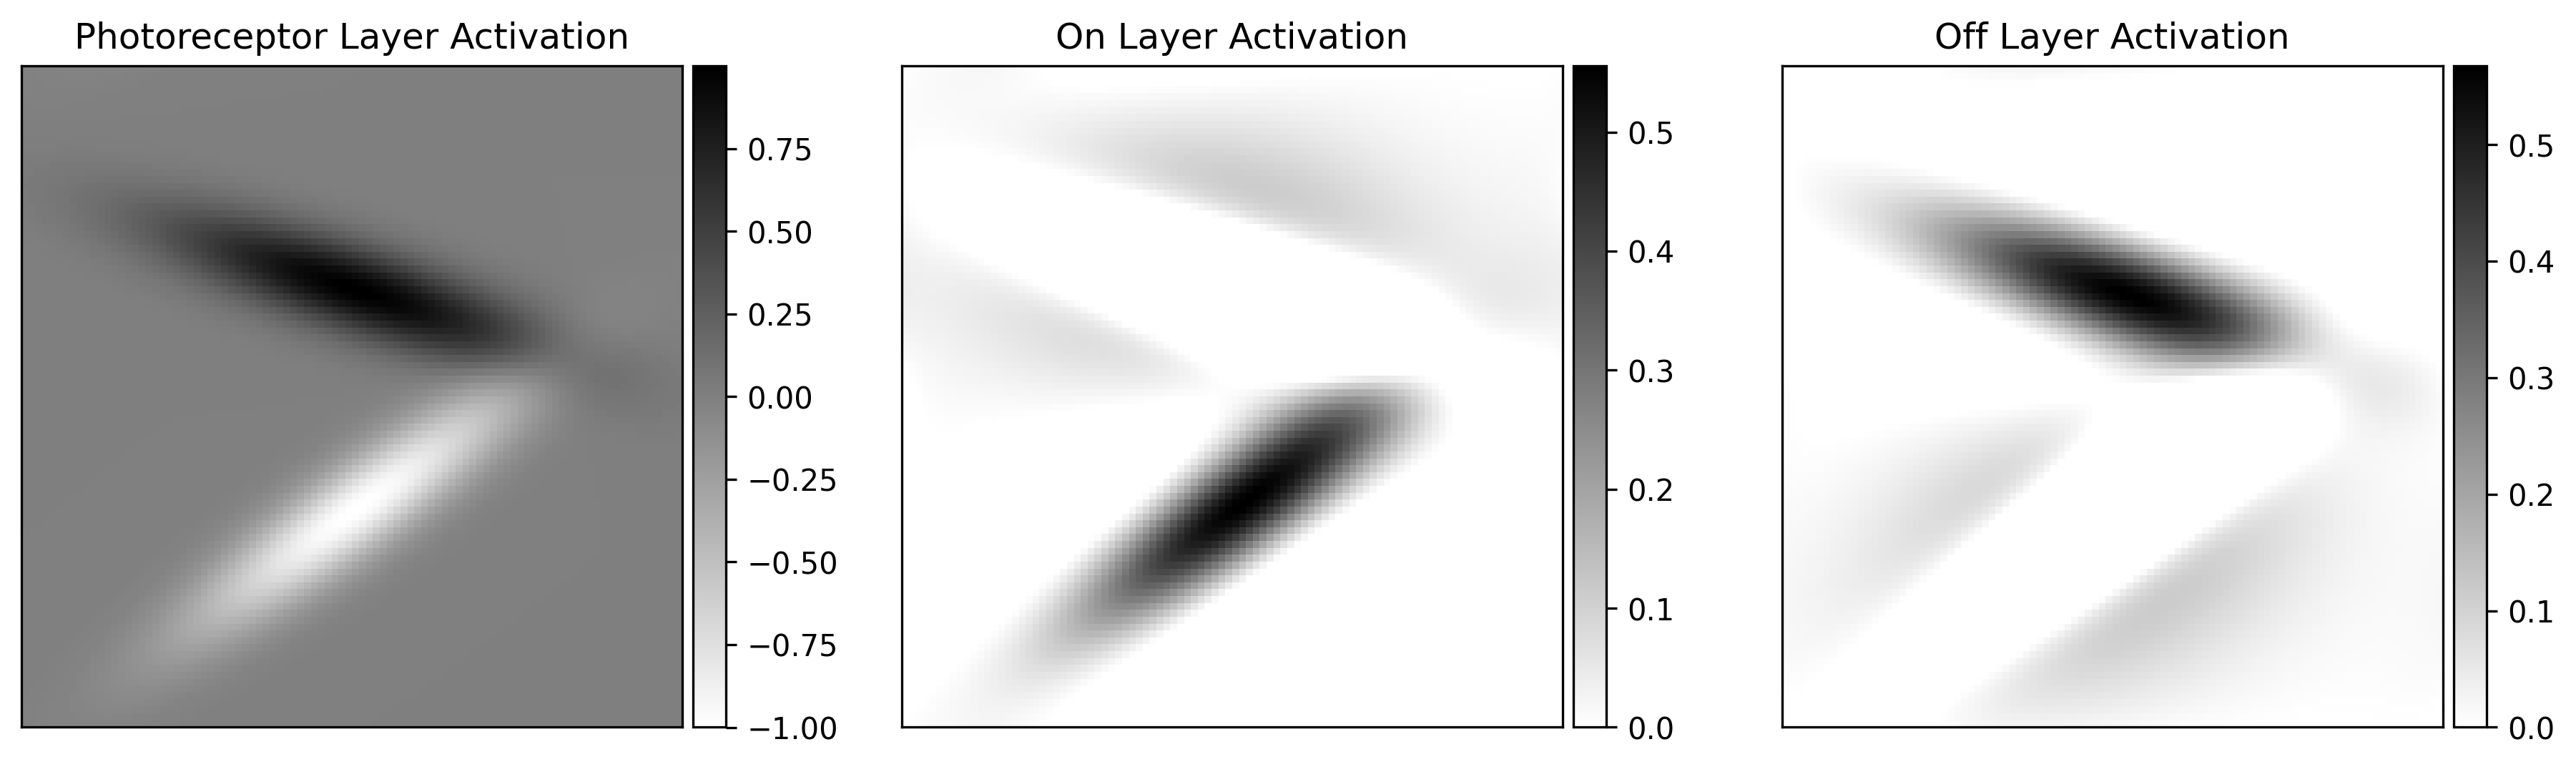

In [11]:
fig,axs = plt.subplots(1,3,figsize=(15,4),dpi=300)

psi = stevens_gauss(Nret//3,Nret//2,np.pi*0.9) - stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2)
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
pf.imshowbar(fig,axs[0],psi,cmap='binary')
pf.imshowbar(fig,axs[1],fio_rect(-Wpatt),cmap='binary')
pf.imshowbar(fig,axs[2],fio_rect(Wpatt),cmap='binary')

axs[0].set_title('Photoreceptor Layer Activation')
axs[1].set_title('On Layer Activation')
axs[2].set_title('Off Layer Activation')

Text(0.5, 1.0, 'Off Layer Activation')

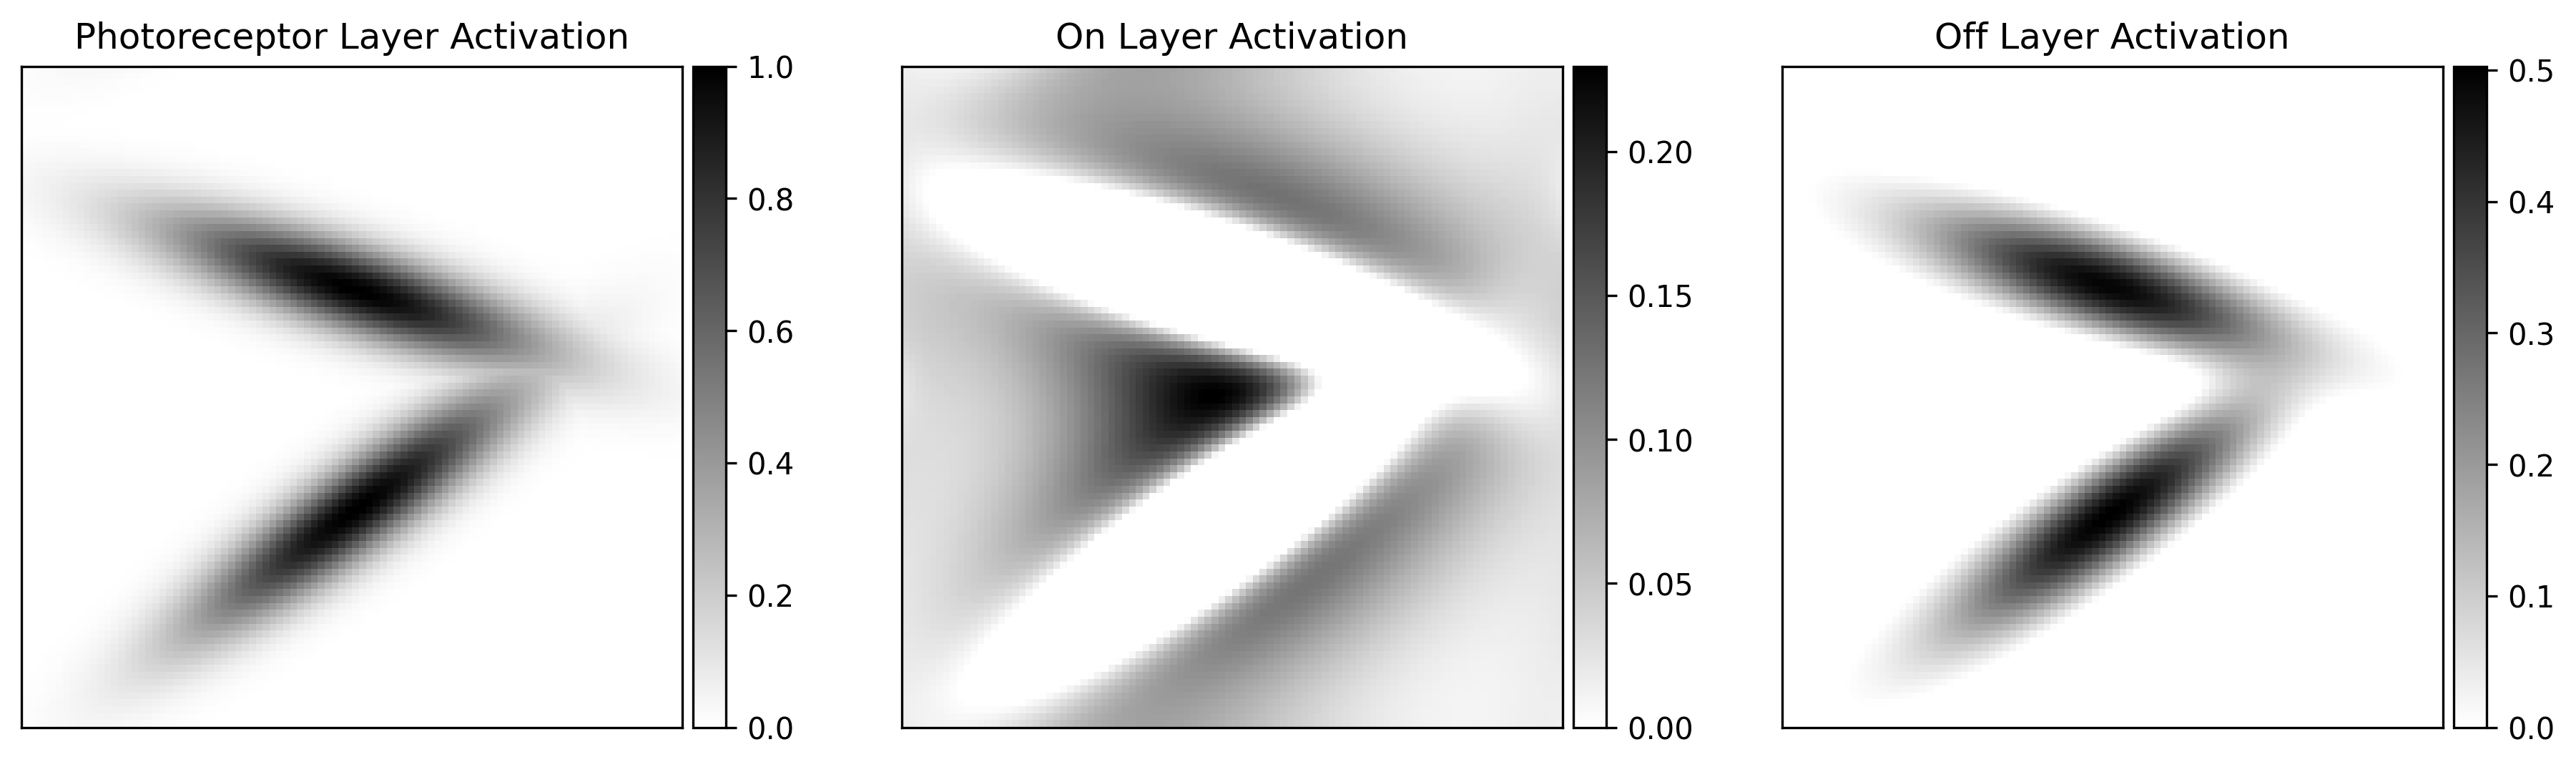

In [12]:
fig,axs = plt.subplots(1,3,figsize=(15,4),dpi=300)

psi = np.fmax(stevens_gauss(Nret//3,Nret//2,np.pi*0.9),stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
pf.imshowbar(fig,axs[0],psi,cmap='binary')
pf.imshowbar(fig,axs[1],fio_rect(-Wpatt),cmap='binary')
pf.imshowbar(fig,axs[2],fio_rect(Wpatt),cmap='binary')

axs[0].set_title('Photoreceptor Layer Activation')
axs[1].set_title('On Layer Activation')
axs[2].set_title('Off Layer Activation')

In [24]:
n_ret_patts = 1000
gaus_psis = 0.25*np.stack([stevens_gauss(np.random.default_rng(0).integers(Nret,size=(2*n_ret_patts))[i],
                                    np.random.default_rng(1).integers(Nret,size=(2*n_ret_patts))[i],
                                    np.pi*np.random.default_rng(2).random(size=(2*n_ret_patts))[i]) for i in
                      range(2*n_ret_patts)]).reshape(
    2,n_ret_patts,Nret**2)
gaus_psis = np.fmax(gaus_psis[0],gaus_psis[1])
# dipl_psis = 0.25*np.stack([stevens_gauss(np.random.default_rng(0).integers(Nret,size=(2*n_ret_patts))[i],
#                                     np.random.default_rng(1).integers(Nret,size=(2*n_ret_patts))[i],
#                                     np.pi*np.random.default_rng(2).random(size=(2*n_ret_patts))[i]) for i in
#                       range(2*n_ret_patts)]).reshape(
#     2,n_ret_patts,Nret**2)
# dipl_psis = dipl_psis[0]-dipl_psis[1]
unif_psis = np.random.default_rng(0).random(size=(n_ret_patts,Nret**2))
norm_psis = np.random.default_rng(0).normal(size=(n_ret_patts,Nret**2))

In [25]:
gaus_Wpsis = np.einsum('ij,kj->ki',WRtoT,gaus_psis)
# dipl_Wpsis = np.einsum('ij,kj->ki',WRtoT,dipl_psis)
unif_Wpsis = np.einsum('ij,kj->ki',WRtoT,unif_psis)
norm_Wpsis = np.einsum('ij,kj->ki',WRtoT,norm_psis)

Text(0.5, 1.0, 'Input to LGN Histogram')

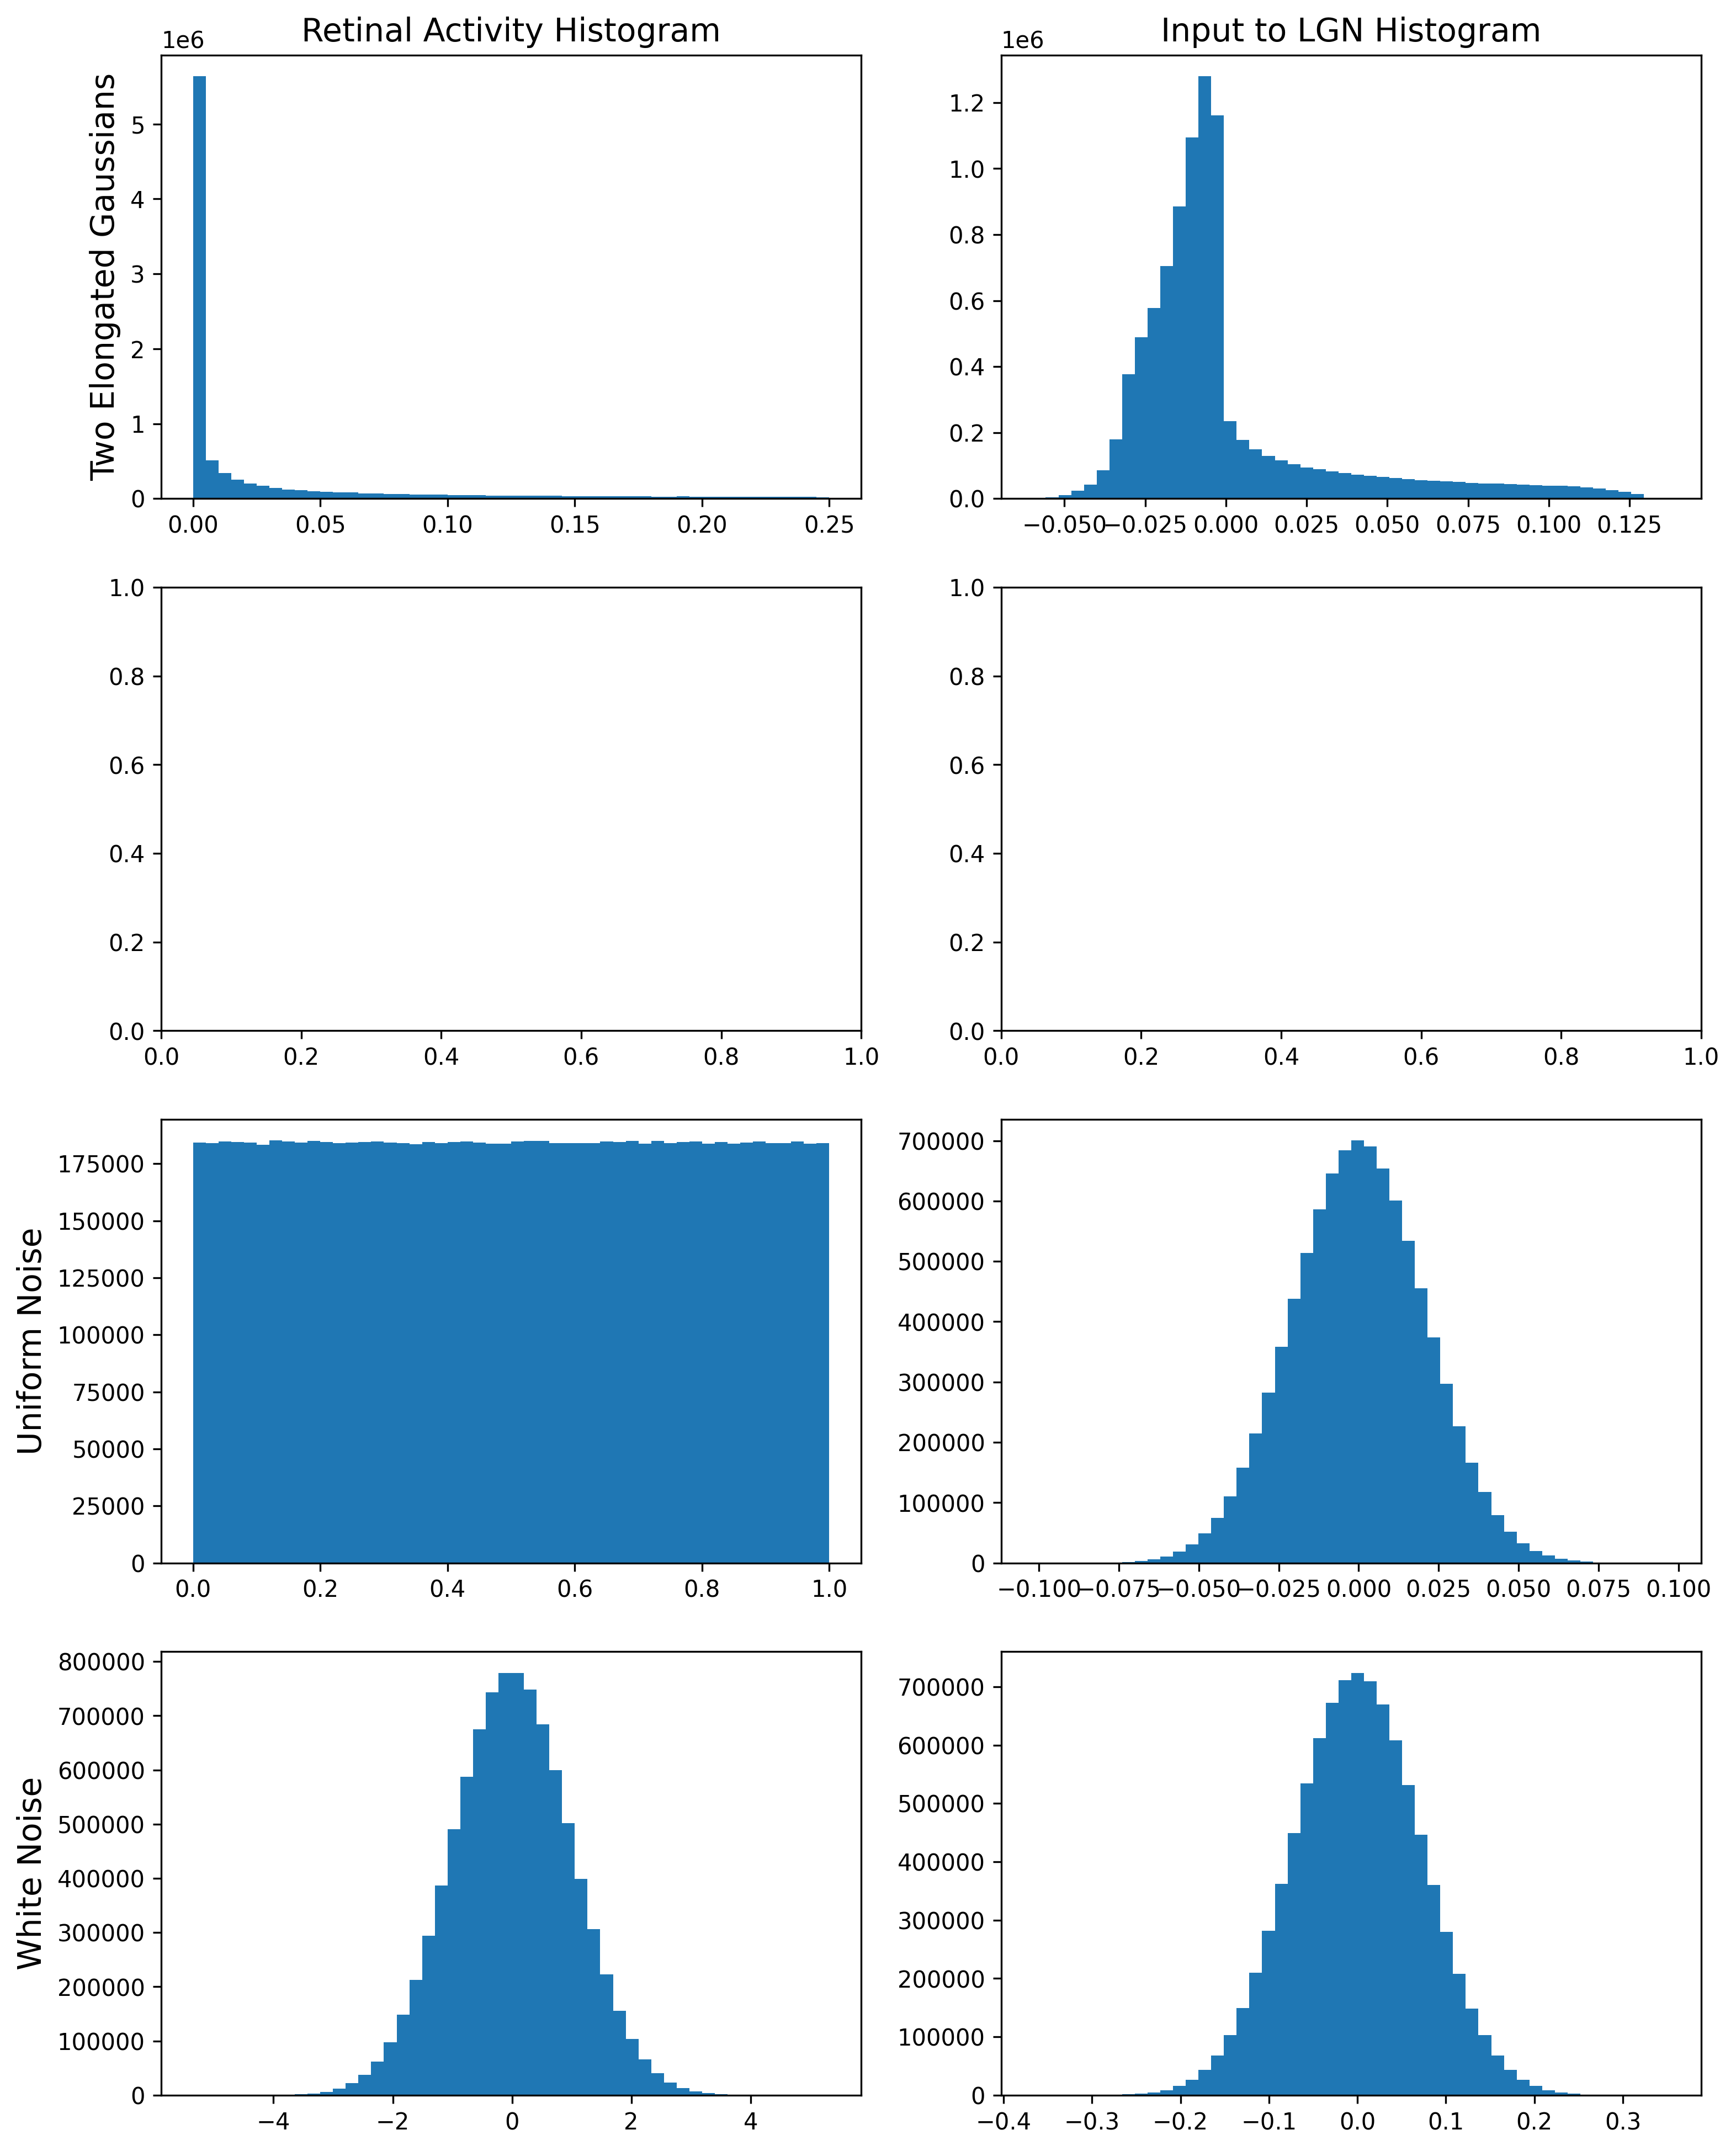

In [15]:
fig,axs = plt.subplots(4,2,figsize=(12,16),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0,0].hist(gaus_psis.flatten(),50)
axs[0,1].hist(gaus_Wpsis.flatten(),50)
# axs[1,0].hist(dipl_psis.flatten(),50)
# axs[1,1].hist(dipl_Wpsis.flatten(),50)
axs[2,0].hist(unif_psis.flatten(),50)
axs[2,1].hist(unif_Wpsis.flatten(),50)
axs[3,0].hist(norm_psis.flatten(),50)
axs[3,1].hist(norm_Wpsis.flatten(),50)

axs[0,0].set_ylabel('Two Elongated Gaussians',fontsize=14)
# axs[1,0].set_ylabel('Opp Polarity Gaussians',fontsize=14)
axs[2,0].set_ylabel('Uniform Noise',fontsize=14)
axs[3,0].set_ylabel('White Noise',fontsize=14)
axs[0,0].set_title('Retinal Activity Histogram',fontsize=14)
axs[0,1].set_title('Input to LGN Histogram',fontsize=14)

In [16]:
print(np.std(gaus_Wpsis.flatten()))
# print(np.std(dipl_Wpsis.flatten()))
print(np.std(unif_Wpsis.flatten()))
print(np.std(norm_Wpsis.flatten()))

0.03156616289324823
0.020842153439384604
0.07259555280647265


## Create LGN Activity Patterns

In [ ]:
gaus_N_act = fio_rect(14*-gaus_Wpsis)
gaus_F_act = fio_rect(14*gaus_Wpsis)

# dipl_N_act = fio_rect(14*dipl_Wpsis)
# dipl_F_act = fio_rect(14*-dipl_Wpsis)

unif_N_act = fio_rect(17*-unif_Wpsis)
unif_F_act = fio_rect(17*unif_Wpsis)

norm_N_act = fio_rect(5*-norm_Wpsis)
norm_F_act = fio_rect(5*norm_Wpsis)

Text(0.5, 1.0, 'Off Cell Activity Histogram')

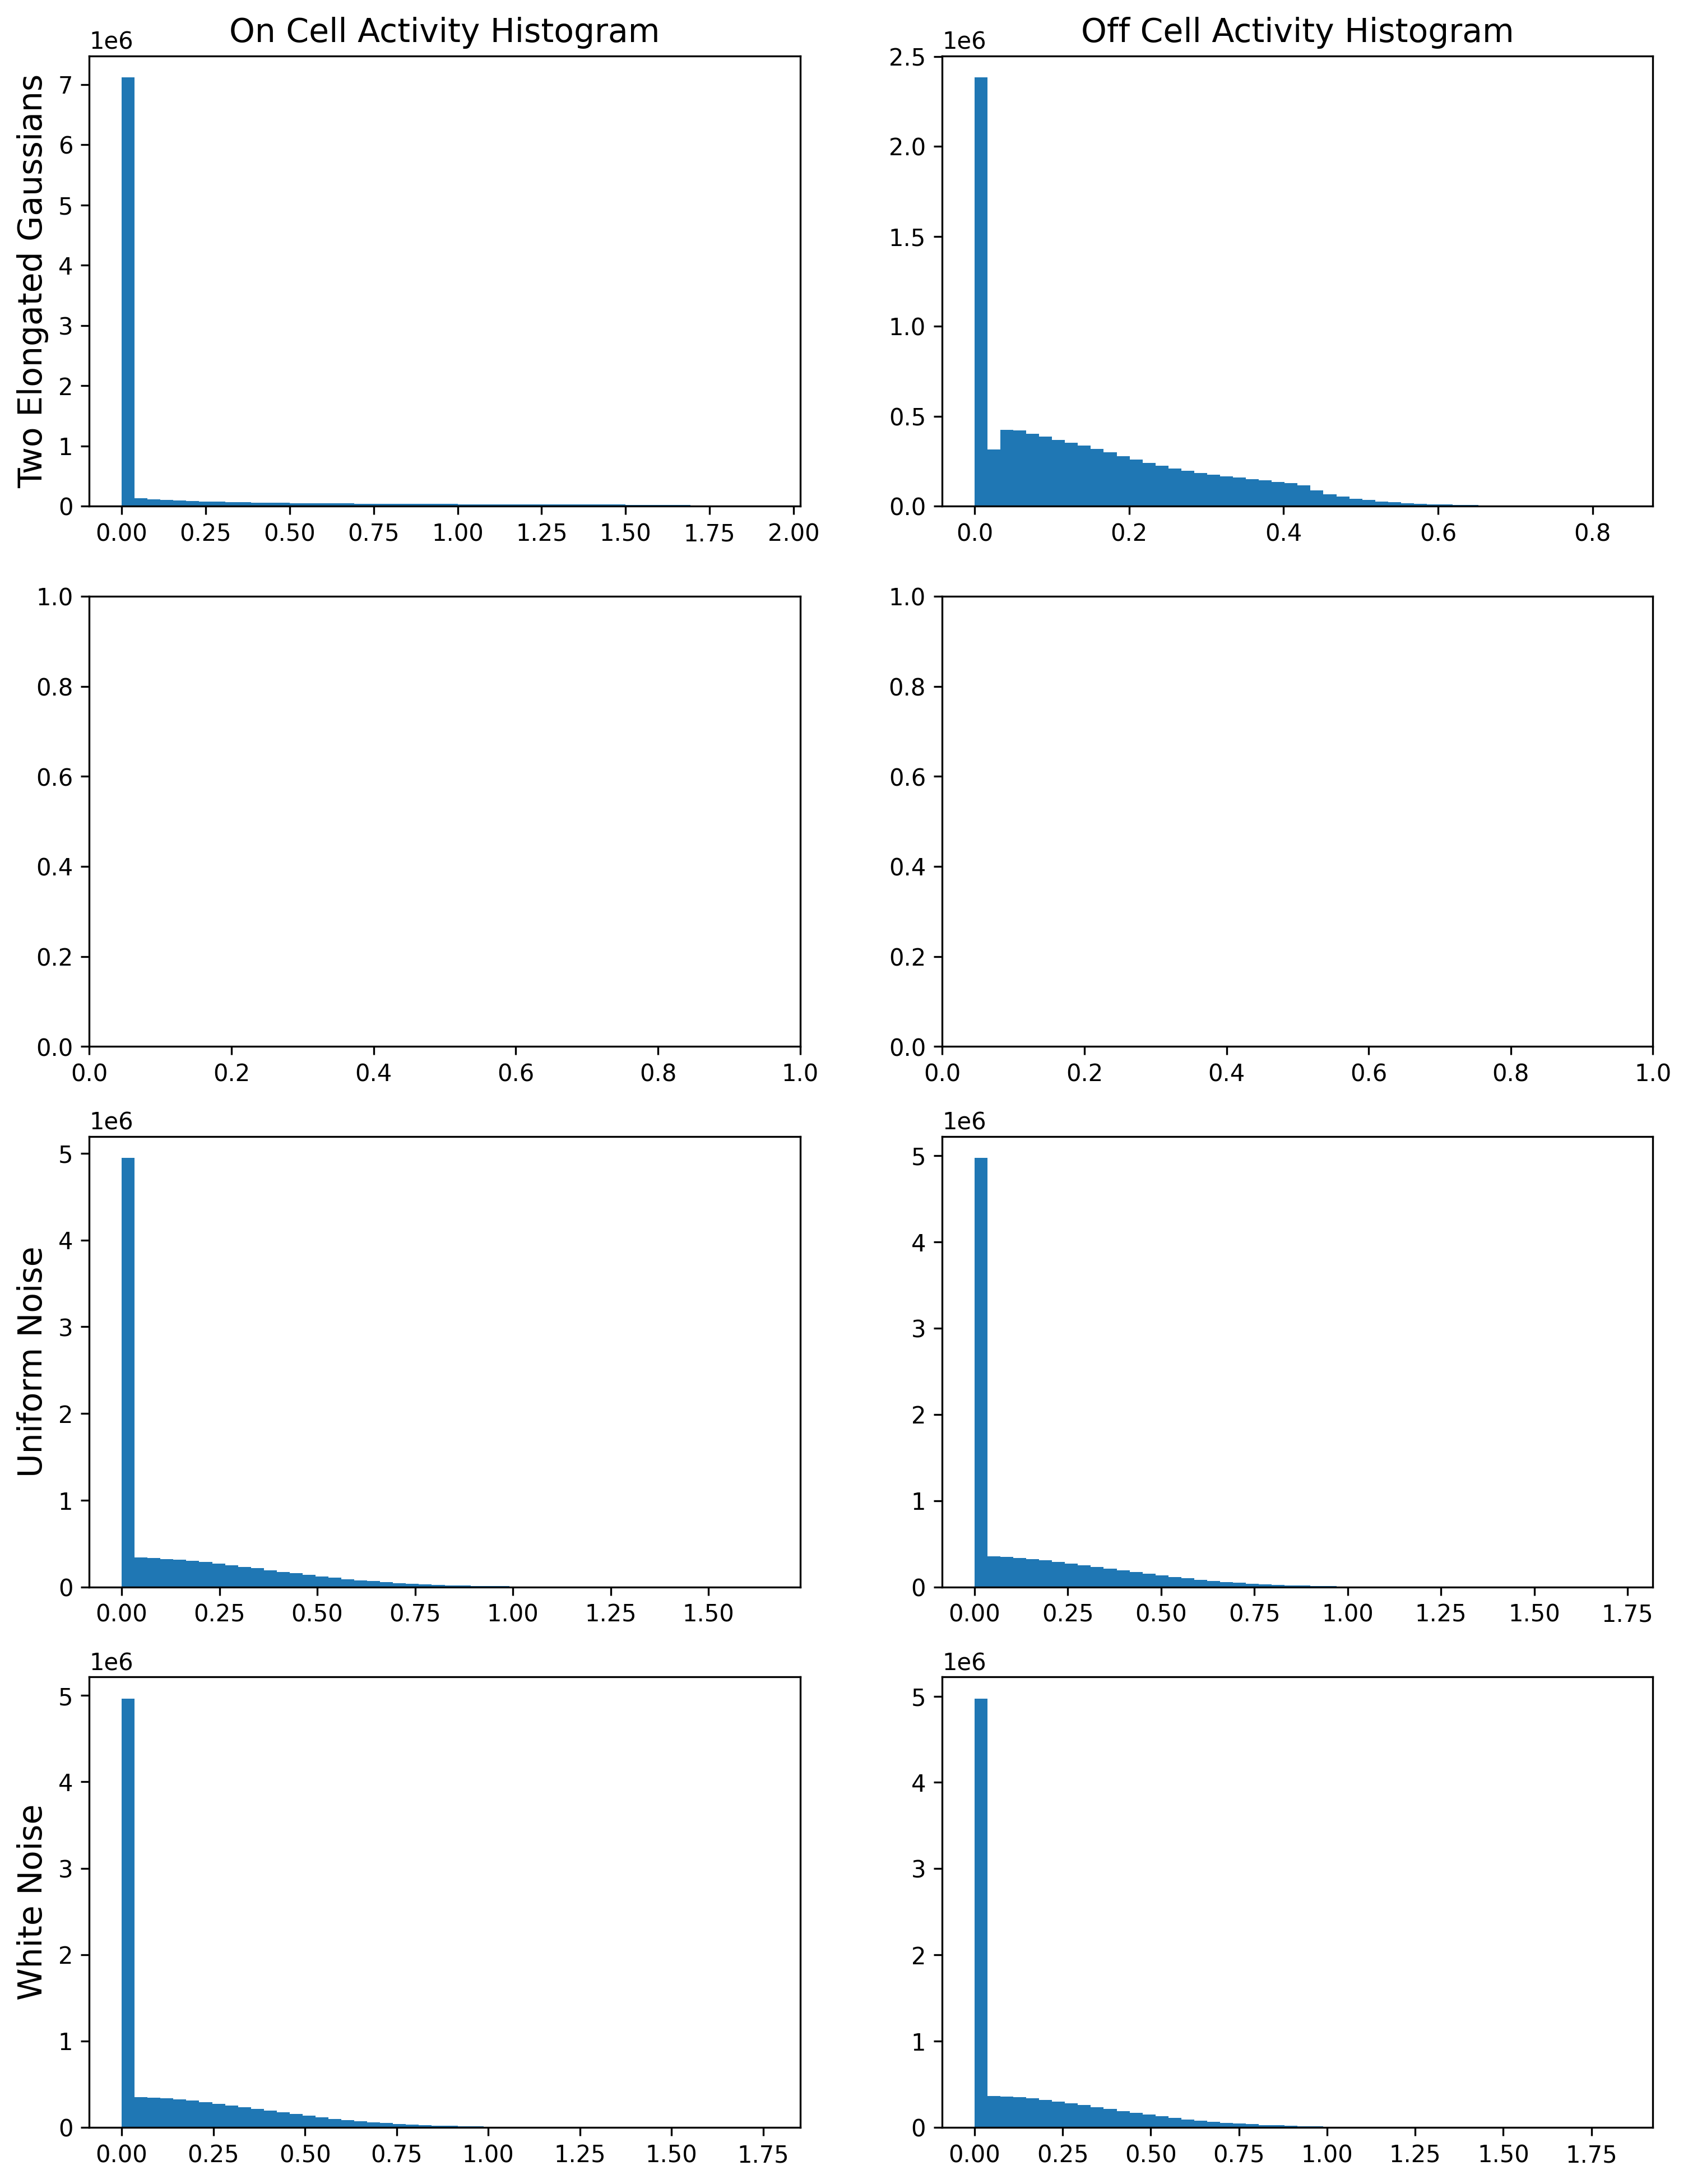

In [20]:
fig,axs = plt.subplots(4,2,figsize=(12,16),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0,0].hist(gaus_N_act.flatten(),50)
axs[0,1].hist(gaus_F_act.flatten(),50)
# axs[1,0].hist(dipl_N_act.flatten(),50)
# axs[1,1].hist(dipl_F_act.flatten(),50)
axs[2,0].hist(unif_N_act.flatten(),50)
axs[2,1].hist(unif_F_act.flatten(),50)
axs[3,0].hist(norm_N_act.flatten(),50)
axs[3,1].hist(norm_F_act.flatten(),50)

axs[0,0].set_ylabel('Two Elongated Gaussians',fontsize=14)
# axs[1,0].set_ylabel('Opp Polarity Gaussians',fontsize=14)
axs[2,0].set_ylabel('Uniform Noise',fontsize=14)
axs[3,0].set_ylabel('White Noise',fontsize=14)
axs[0,0].set_title('On Cell Activity Histogram',fontsize=14)
axs[0,1].set_title('Off Cell Activity Histogram',fontsize=14)

## Calculate Covariance Matrices

In [ ]:
gaus_full_cov = np.cov(gaus_N_act.T,gaus_F_act.T)
gaus_NN_cov = gaus_full_cov[:N**2,:N**2]
gaus_NF_cov = gaus_full_cov[:N**2,N**2:]
gaus_FN_cov = gaus_full_cov[N**2:,:N**2]
gaus_FF_cov = gaus_full_cov[N**2:,N**2:]

# dipl_full_cov = np.cov(dipl_N_act.T,dipl_F_act.T)
# dipl_NN_cov = dipl_full_cov[:N**2,:N**2]
# dipl_NF_cov = dipl_full_cov[:N**2,N**2:]
# dipl_FN_cov = dipl_full_cov[N**2:,:N**2]
# dipl_FF_cov = dipl_full_cov[N**2:,N**2:]

unif_full_cov = np.cov(unif_N_act.T,unif_F_act.T)
unif_NN_cov = unif_full_cov[:N**2,:N**2]
unif_NF_cov = unif_full_cov[:N**2,N**2:]
unif_FN_cov = unif_full_cov[N**2:,:N**2]
unif_FF_cov = unif_full_cov[N**2:,N**2:]

norm_full_cov = np.cov(norm_N_act.T,norm_F_act.T)
norm_NN_cov = norm_full_cov[:N**2,:N**2]
norm_NF_cov = norm_full_cov[:N**2,N**2:]
norm_FN_cov = norm_full_cov[N**2:,:N**2]
norm_FF_cov = norm_full_cov[N**2:,N**2:]

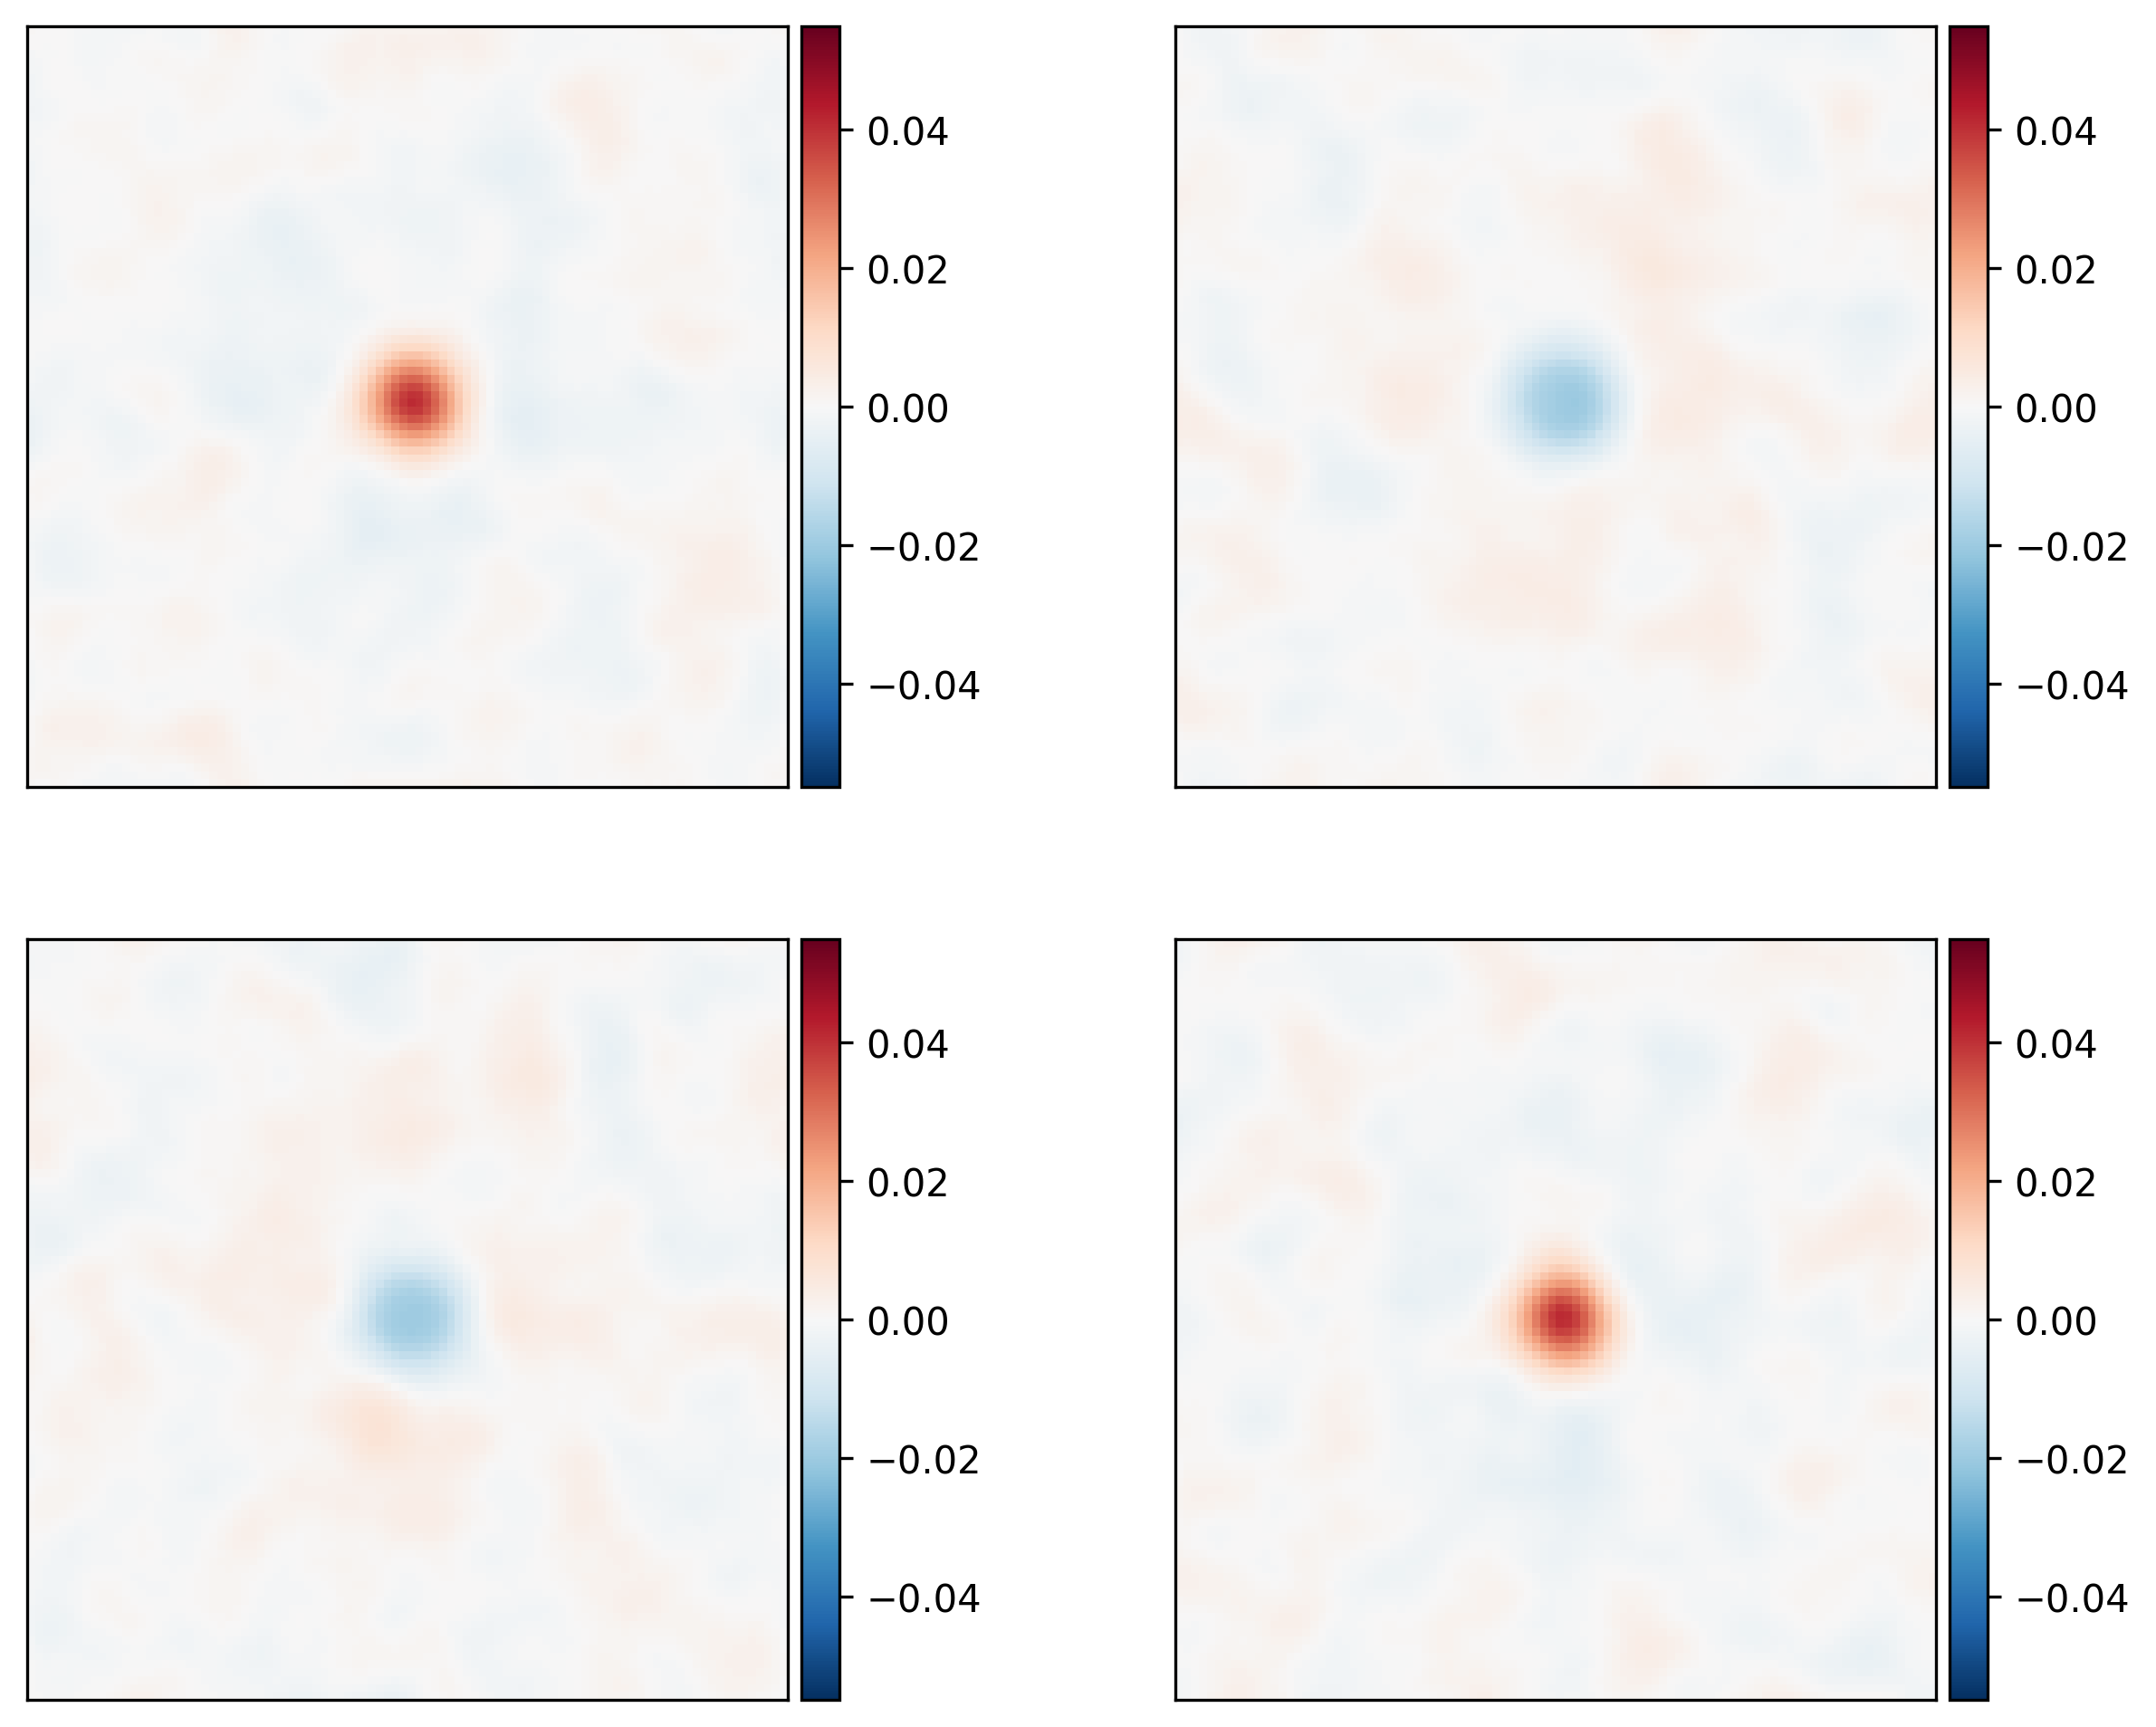

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

lim = np.max(np.abs(norm_full_cov))

pf.imshowbar(fig,axs[0,0],norm_NN_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim,origin='lower')
pf.imshowbar(fig,axs[0,1],norm_NF_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim,origin='lower')
pf.imshowbar(fig,axs[1,0],norm_FN_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim,origin='lower')
pf.imshowbar(fig,axs[1,1],norm_FF_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim,origin='lower')

## Extract Eigenvectors of Covariance Matrix

In [23]:
gaus_evals,gaus_evecs = sparse.linalg.eigsh(gaus_full_cov,4)
# dipl_evals,dipl_evecs = sparse.linalg.eigsh(dipl_full_cov,4)
norm_evals,norm_evecs = sparse.linalg.eigsh(norm_full_cov,4)

Text(6, 6, '61.15756806877075')

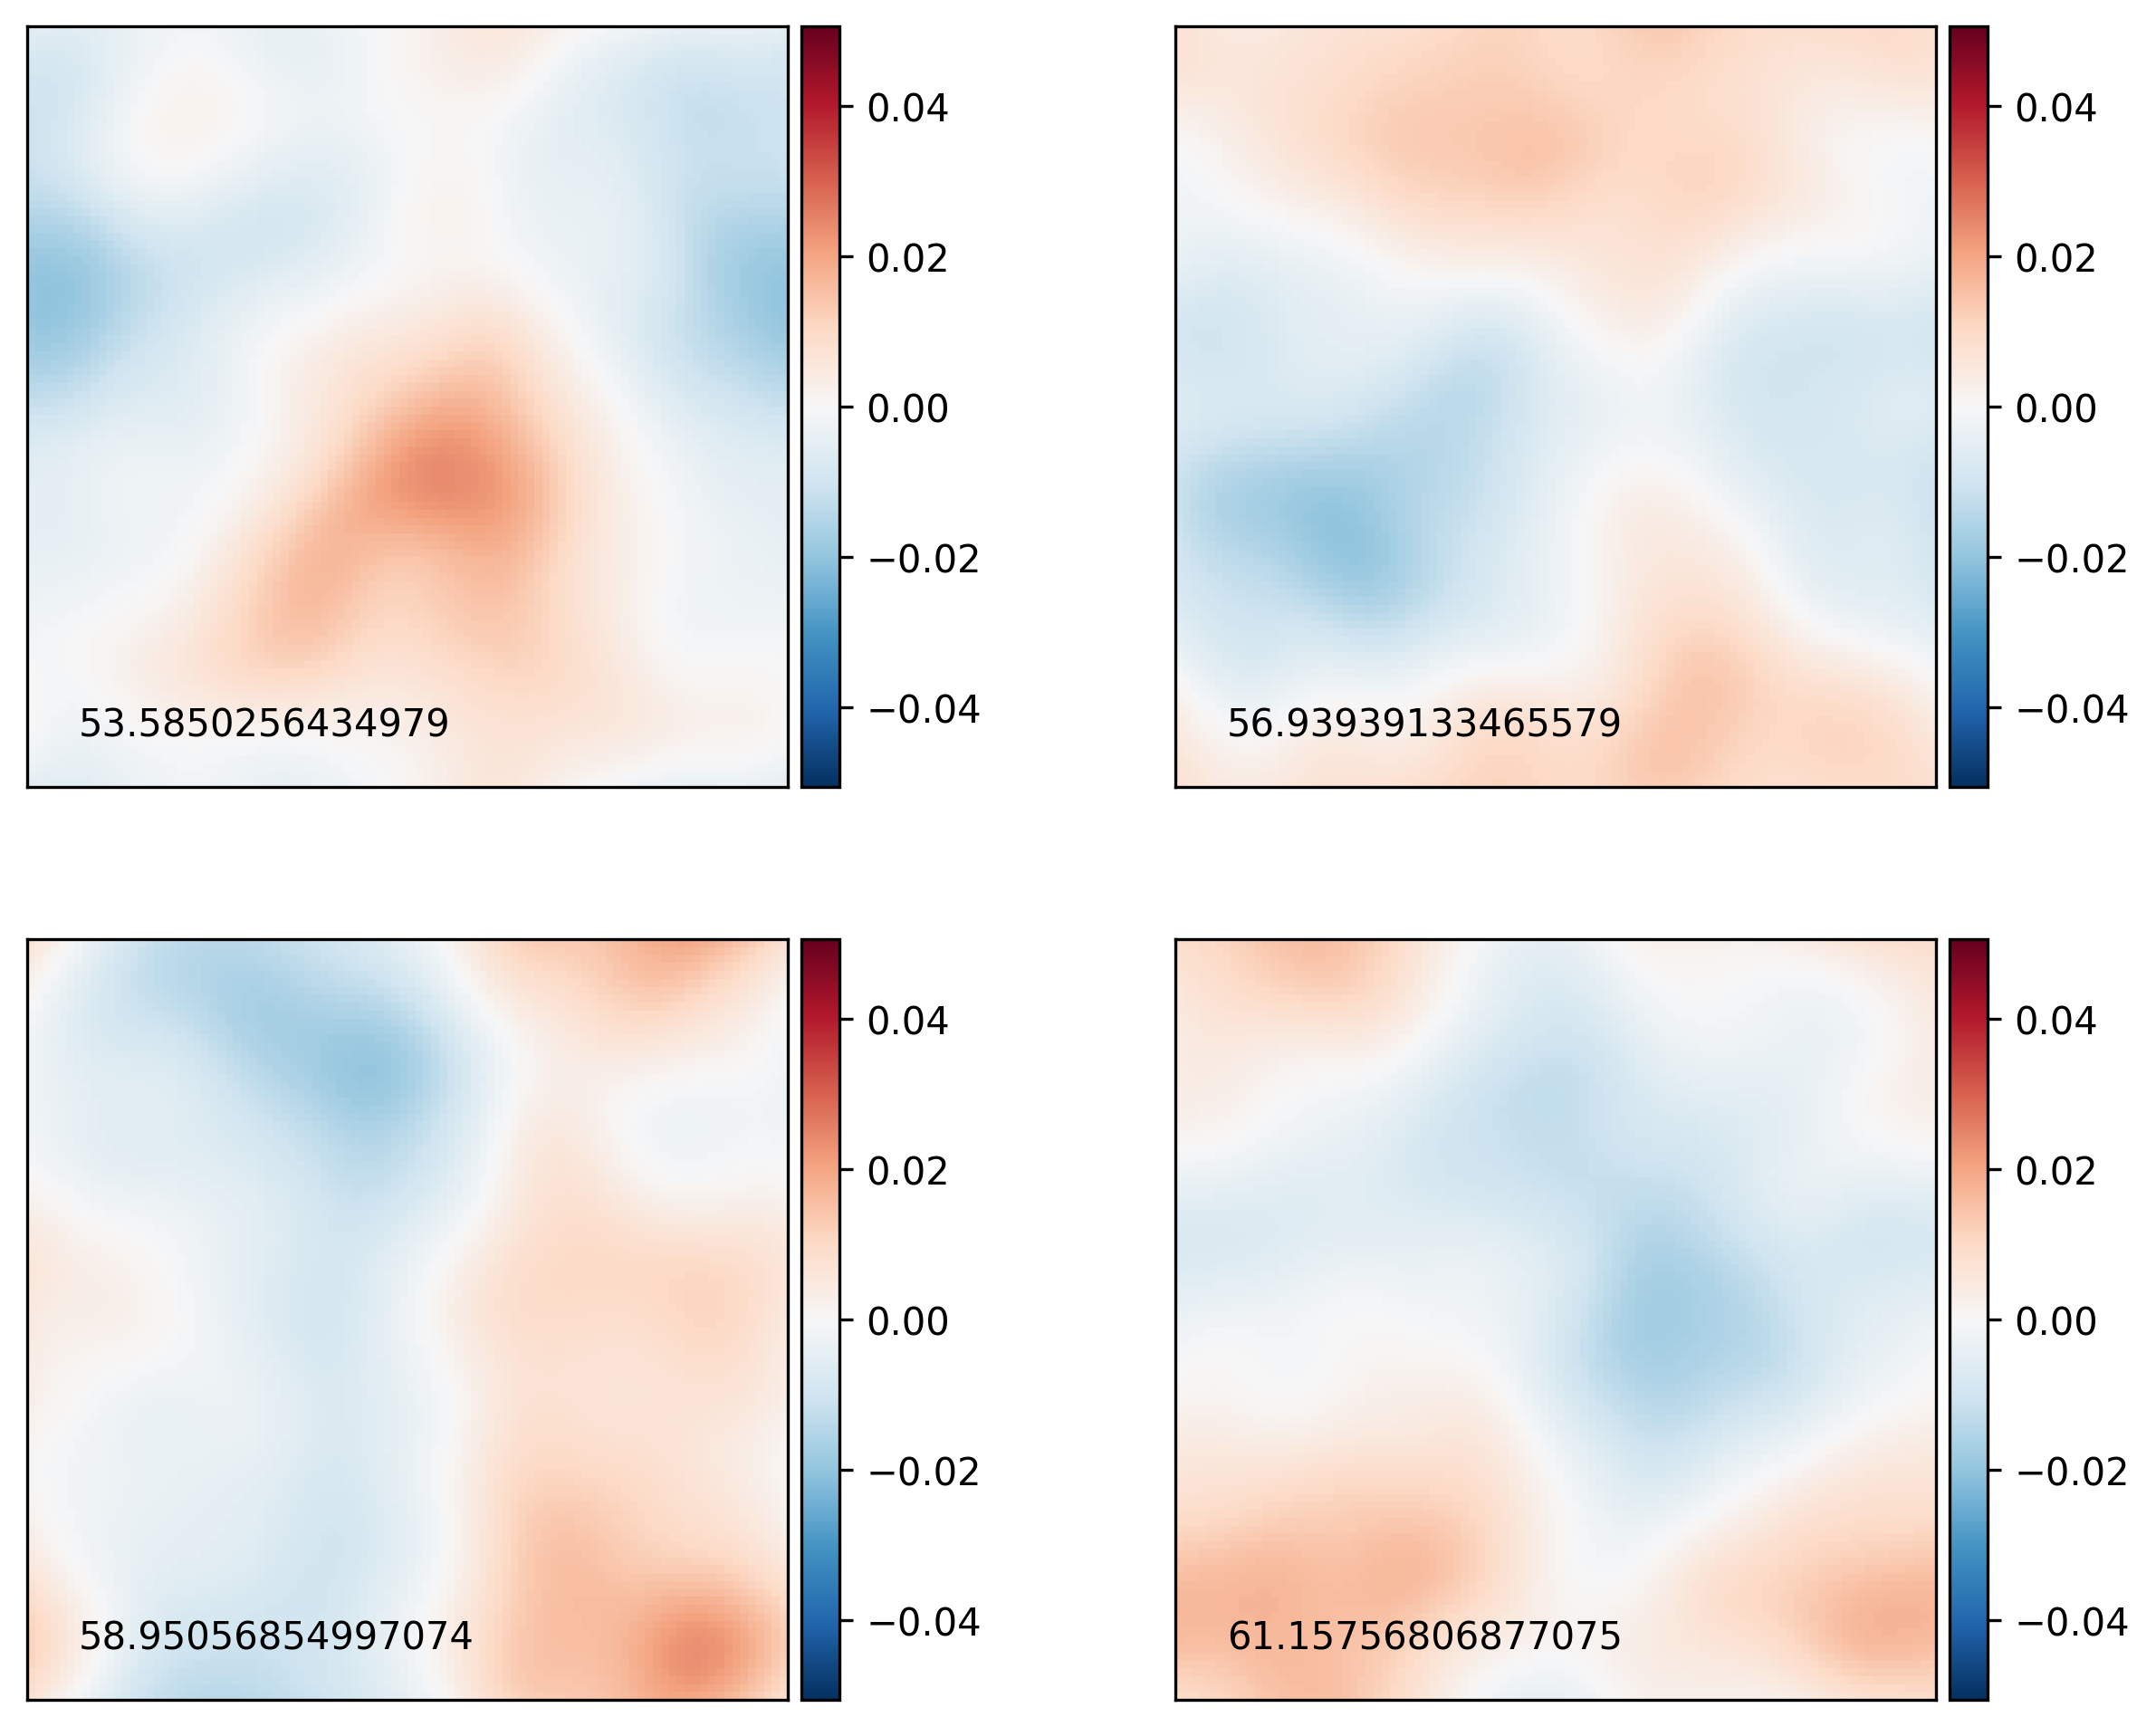

In [24]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

lim = 2*np.max(np.abs(gaus_evecs))

pf.imshowbar(fig,axs[0,0],np.roll((gaus_evecs[:N**2,0]-gaus_evecs[N**2:,0]).reshape(N,N),(N//2,N//2),(0,1)),
             vmin=-lim,vmax=lim,origin='lower')
axs[0,0].text(N//16,N//16,gaus_evals[0])
pf.imshowbar(fig,axs[0,1],np.roll((gaus_evecs[:N**2,1]-gaus_evecs[N**2:,1]).reshape(N,N),(N//2,N//2),(0,1)),
             vmin=-lim,vmax=lim,origin='lower')
axs[0,1].text(N//16,N//16,gaus_evals[1])
pf.imshowbar(fig,axs[1,0],np.roll((gaus_evecs[:N**2,2]-gaus_evecs[N**2:,2]).reshape(N,N),(N//2,N//2),(0,1)),
             vmin=-lim,vmax=lim,origin='lower')
axs[1,0].text(N//16,N//16,gaus_evals[2])
pf.imshowbar(fig,axs[1,1],np.roll((gaus_evecs[:N**2,3]-gaus_evecs[N**2:,3]).reshape(N,N),(N//2,N//2),(0,1)),
             vmin=-lim,vmax=lim,origin='lower')
axs[1,1].text(N//16,N//16,gaus_evals[3])

In [25]:
# fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=300)
# fig.subplots_adjust(hspace=.2, wspace=.2)

# lim = 2*np.max(np.abs(dipl_evecs))

# pf.imshowbar(fig,axs[0,0],np.roll((dipl_evecs[:N**2,0]-dipl_evecs[N**2:,0]).reshape(N,N),(N//2,N//2),(0,1)),
#              vmin=-lim,vmax=lim,origin='lower')
# axs[0,0].text(N//16,N//16,dipl_evals[0])
# pf.imshowbar(fig,axs[0,1],np.roll((dipl_evecs[:N**2,1]-dipl_evecs[N**2:,1]).reshape(N,N),(N//2,N//2),(0,1)),
#              vmin=-lim,vmax=lim,origin='lower')
# axs[0,1].text(N//16,N//16,dipl_evals[1])
# pf.imshowbar(fig,axs[1,0],np.roll((dipl_evecs[:N**2,2]-dipl_evecs[N**2:,2]).reshape(N,N),(N//2,N//2),(0,1)),
#              vmin=-lim,vmax=lim,origin='lower')
# axs[1,0].text(N//16,N//16,dipl_evals[2])
# pf.imshowbar(fig,axs[1,1],np.roll((dipl_evecs[:N**2,3]-dipl_evecs[N**2:,3]).reshape(N,N),(N//2,N//2),(0,1)),
#              vmin=-lim,vmax=lim,origin='lower')
# axs[1,1].text(N//16,N//16,dipl_evals[3])

Text(6, 6, '10.671079973791192')

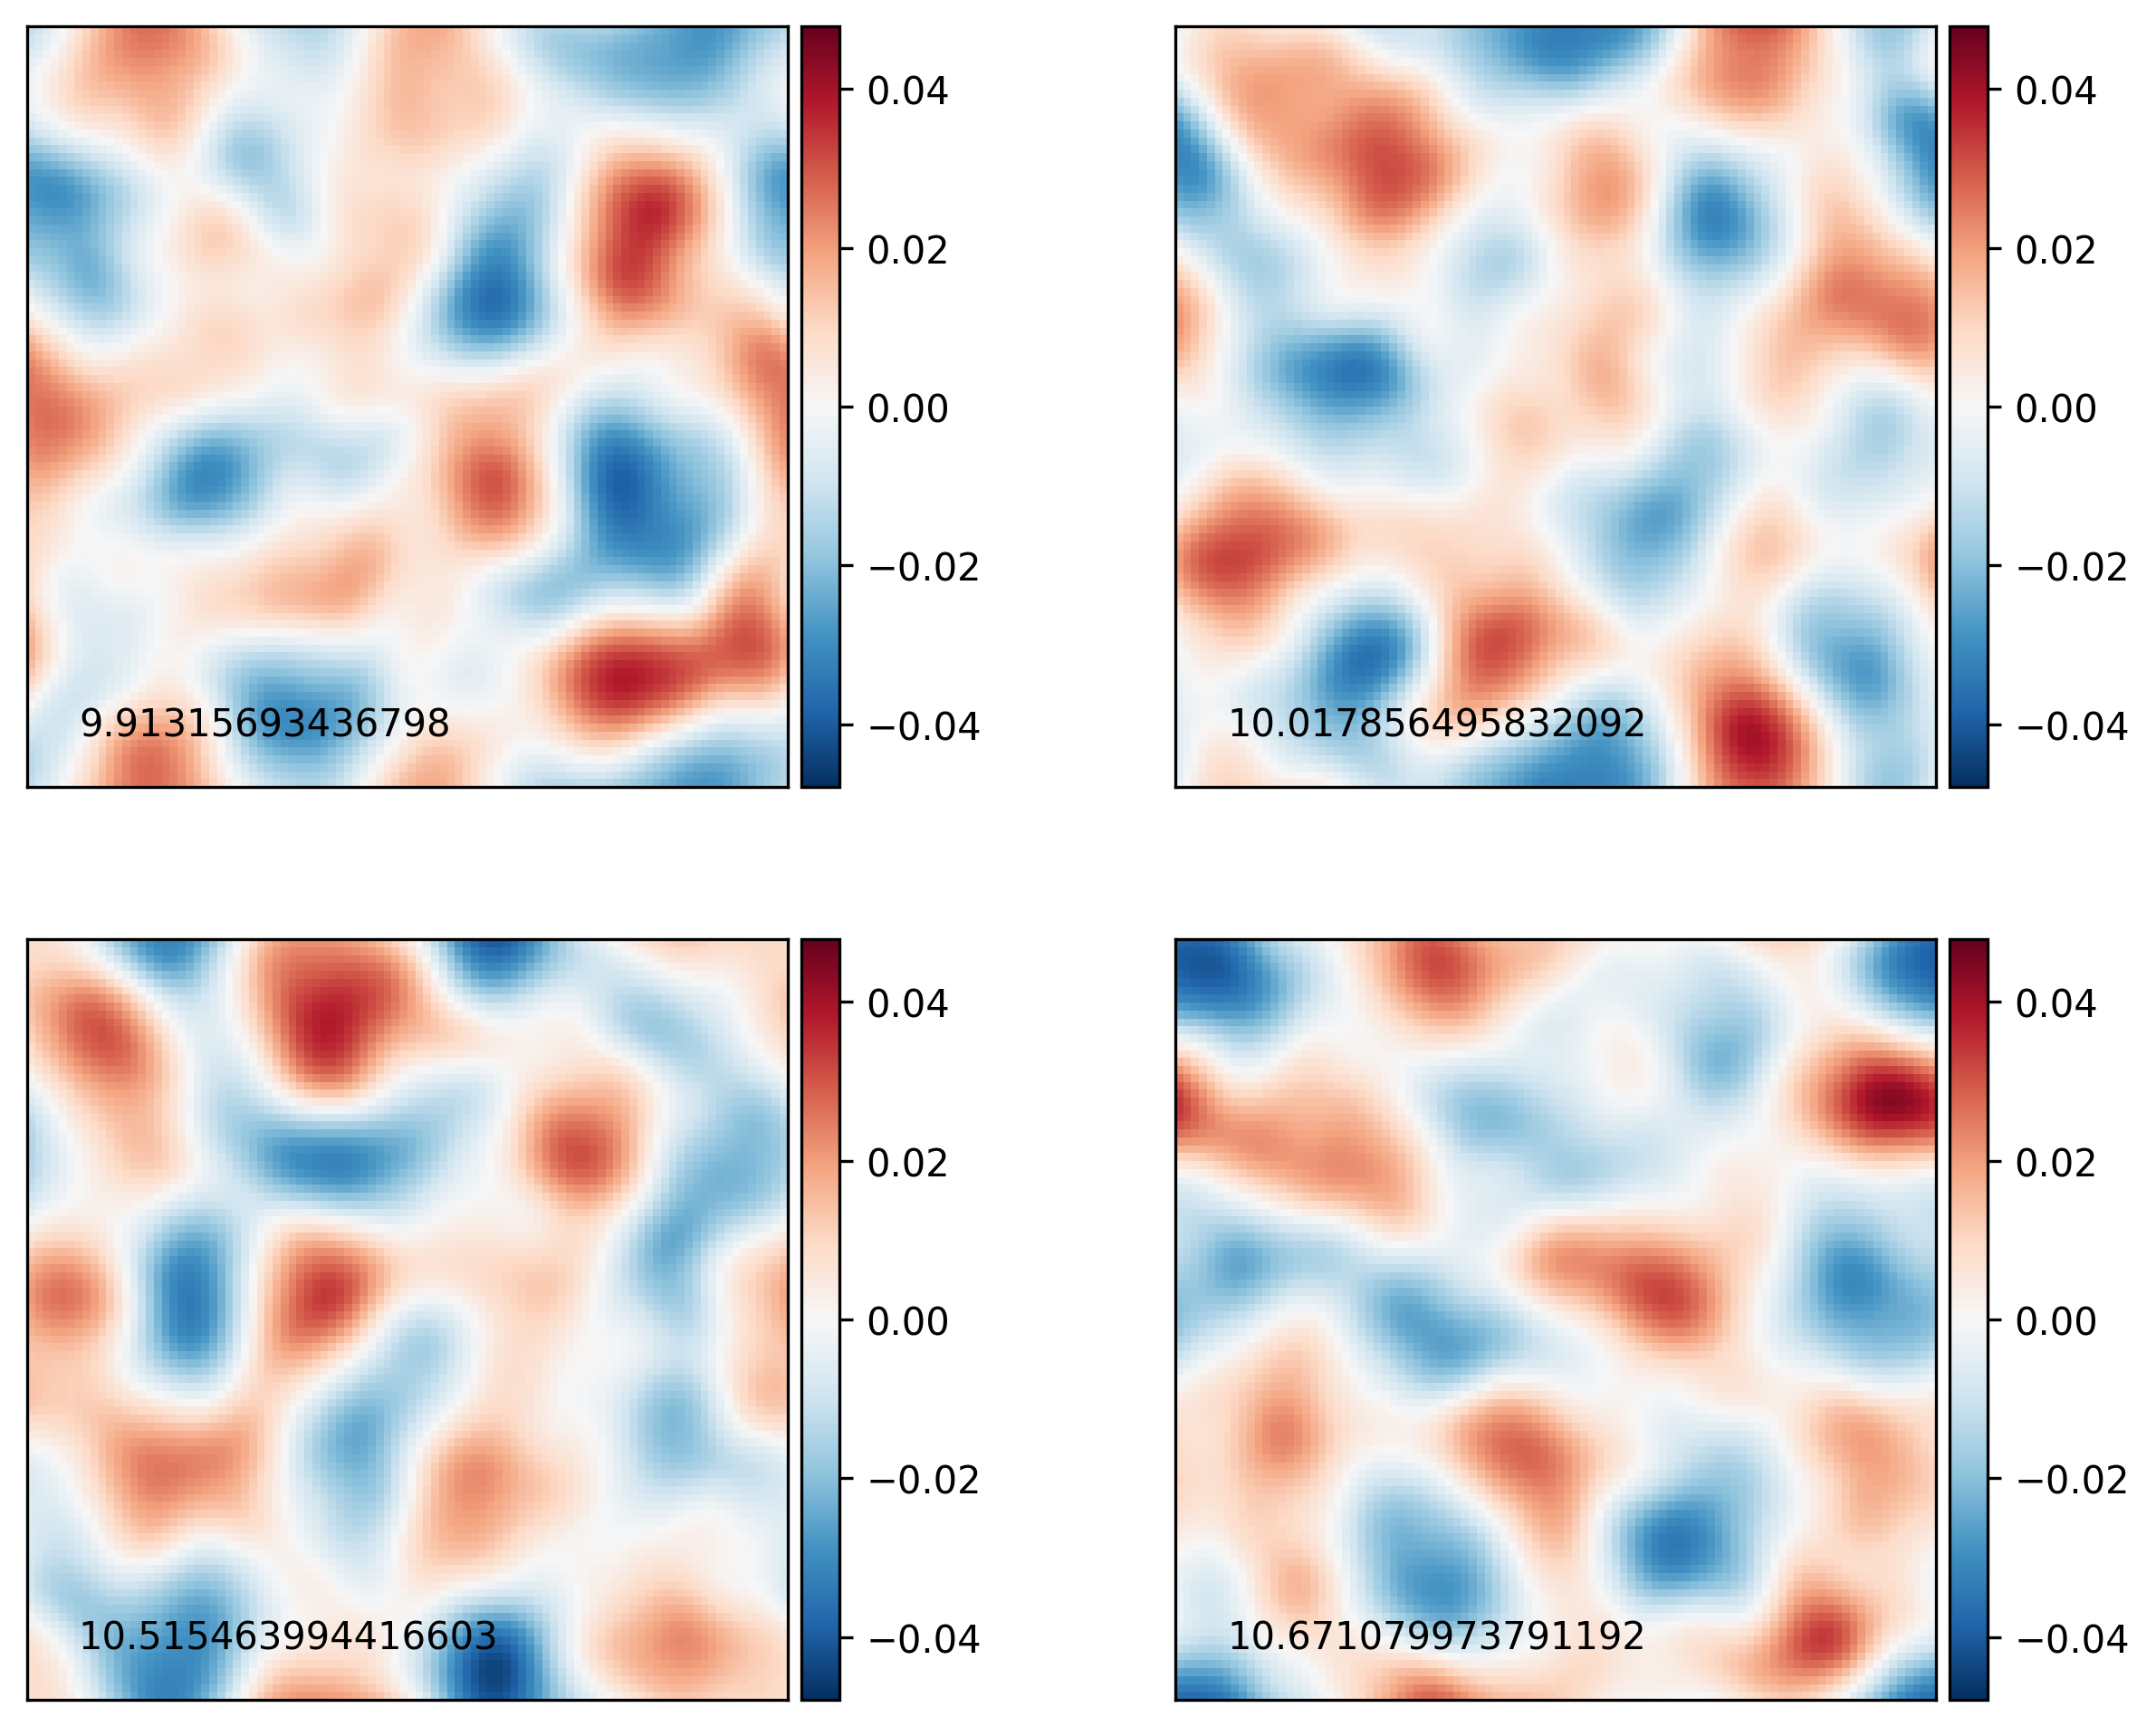

In [26]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

lim = 2*np.max(np.abs(norm_evecs))

pf.imshowbar(fig,axs[0,0],np.roll((norm_evecs[:N**2,0]-norm_evecs[N**2:,0]).reshape(N,N),(N//2,N//2),(0,1)),
             vmin=-lim,vmax=lim,origin='lower')
axs[0,0].text(N//16,N//16,norm_evals[0])
pf.imshowbar(fig,axs[0,1],np.roll((norm_evecs[:N**2,1]-norm_evecs[N**2:,1]).reshape(N,N),(N//2,N//2),(0,1)),
             vmin=-lim,vmax=lim,origin='lower')
axs[0,1].text(N//16,N//16,norm_evals[1])
pf.imshowbar(fig,axs[1,0],np.roll((norm_evecs[:N**2,2]-norm_evecs[N**2:,2]).reshape(N,N),(N//2,N//2),(0,1)),
             vmin=-lim,vmax=lim,origin='lower')
axs[1,0].text(N//16,N//16,norm_evals[2])
pf.imshowbar(fig,axs[1,1],np.roll((norm_evecs[:N**2,3]-norm_evecs[N**2:,3]).reshape(N,N),(N//2,N//2),(0,1)),
             vmin=-lim,vmax=lim,origin='lower')
axs[1,1].text(N//16,N//16,norm_evals[3])

## Calculate Spatial Distance Dependence of Eigenvectors

In [ ]:
dists = np.linspace(0,0.71,72)
bin_idxs_4d = np.digitize(ds,np.linspace(0,0.7,71)+0.005)
bin_idxs_2d = np.digitize(ds[0,:],np.linspace(0,0.7,71)+0.005)

gaus_SN_cov = np.zeros(72)
gaus_SN_cov_err = np.zeros(72)
gaus_SF_cov = np.zeros(72)
gaus_SF_cov_err = np.zeros(72)
gaus_D_cov = np.zeros(72)
gaus_D_cov_err = np.zeros(72)
gaus_evec = np.zeros((2,72))
gaus_evec_err = np.zeros((2,72))

# dipl_S_cov = np.zeros(72)
# dipl_S_cov_err = np.zeros(72)
# dipl_D_cov = np.zeros(72)
# dipl_D_cov_err = np.zeros(72)
# dipl_evec = np.zeros((2,72))
# dipl_evec_err = np.zeros((2,72))

norm_S_cov = np.zeros(72)
norm_S_cov_err = np.zeros(72)
norm_D_cov = np.zeros(72)
norm_D_cov_err = np.zeros(72)
norm_evec = np.zeros((2,72))
norm_evec_err = np.zeros((2,72))

for idx in range(72):
    gaus_SN_cov[idx] = np.mean(gaus_NN_cov[bin_idxs_4d == idx])
    gaus_SN_cov_err[idx] = np.sqrt(np.var(gaus_NN_cov[bin_idxs_4d == idx]))
    gaus_SF_cov[idx] = np.mean(gaus_FF_cov[bin_idxs_4d == idx])
    gaus_SF_cov_err[idx] = np.sqrt(np.var(gaus_FF_cov[bin_idxs_4d == idx]))
    gaus_D_cov[idx] = 0.5*(np.mean(gaus_NF_cov[bin_idxs_4d == idx]) +\
                           np.mean(gaus_NF_cov[bin_idxs_4d == idx]))
    gaus_D_cov_err[idx] = np.sqrt(np.var(gaus_NF_cov[bin_idxs_4d == idx]) +\
                                  np.var(gaus_NF_cov[bin_idxs_4d == idx]))
    for i in range(2):
        gaus_evec[i,idx] = np.mean((gaus_evecs[:N**2,-(i+1)]-gaus_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])
        gaus_evec_err[i,idx] = np.var((gaus_evecs[:N**2,-(i+1)]-gaus_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])
    
    # dipl_S_cov[idx] = 0.5*(np.mean(dipl_NN_cov[bin_idxs_4d == idx]) +\
    #                        np.mean(dipl_FF_cov[bin_idxs_4d == idx]))
    # dipl_S_cov_err[idx] = np.sqrt(np.var(dipl_NN_cov[bin_idxs_4d == idx]) +\
    #                               np.var(dipl_FF_cov[bin_idxs_4d == idx]))
    # dipl_D_cov[idx] = 0.5*(np.mean(dipl_NF_cov[bin_idxs_4d == idx]) +\
    #                        np.mean(dipl_NF_cov[bin_idxs_4d == idx]))
    # dipl_D_cov_err[idx] = np.sqrt(np.var(dipl_NF_cov[bin_idxs_4d == idx]) +\
    #                               np.var(dipl_NF_cov[bin_idxs_4d == idx]))
    # for i in range(2):
    #     dipl_evec[i,idx] = np.mean((dipl_evecs[:N**2,-(i+1)]-dipl_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])
    #     dipl_evec_err[i,idx] = np.var((dipl_evecs[:N**2,-(i+1)]-dipl_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])
    
    norm_S_cov[idx] = 0.5*(np.mean(norm_NN_cov[bin_idxs_4d == idx]) +\
                           np.mean(norm_FF_cov[bin_idxs_4d == idx]))
    norm_S_cov_err[idx] = np.sqrt(np.var(norm_NN_cov[bin_idxs_4d == idx]) +\
                                  np.var(norm_FF_cov[bin_idxs_4d == idx]))
    norm_D_cov[idx] = 0.5*(np.mean(norm_NF_cov[bin_idxs_4d == idx]) +\
                           np.mean(norm_NF_cov[bin_idxs_4d == idx]))
    norm_D_cov_err[idx] = np.sqrt(np.var(norm_NF_cov[bin_idxs_4d == idx]) +\
                                  np.var(norm_NF_cov[bin_idxs_4d == idx]))
    for i in range(2):
        norm_evec[i,idx] = np.mean((norm_evecs[:N**2,-(i+1)]-norm_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])
        norm_evec_err[i,idx] = np.var((norm_evecs[:N**2,-(i+1)]-norm_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])

Text(0.5, 1.0, 'Stevens et al LGN Covariance Eigenvector with Random Normal Retinal Activity')

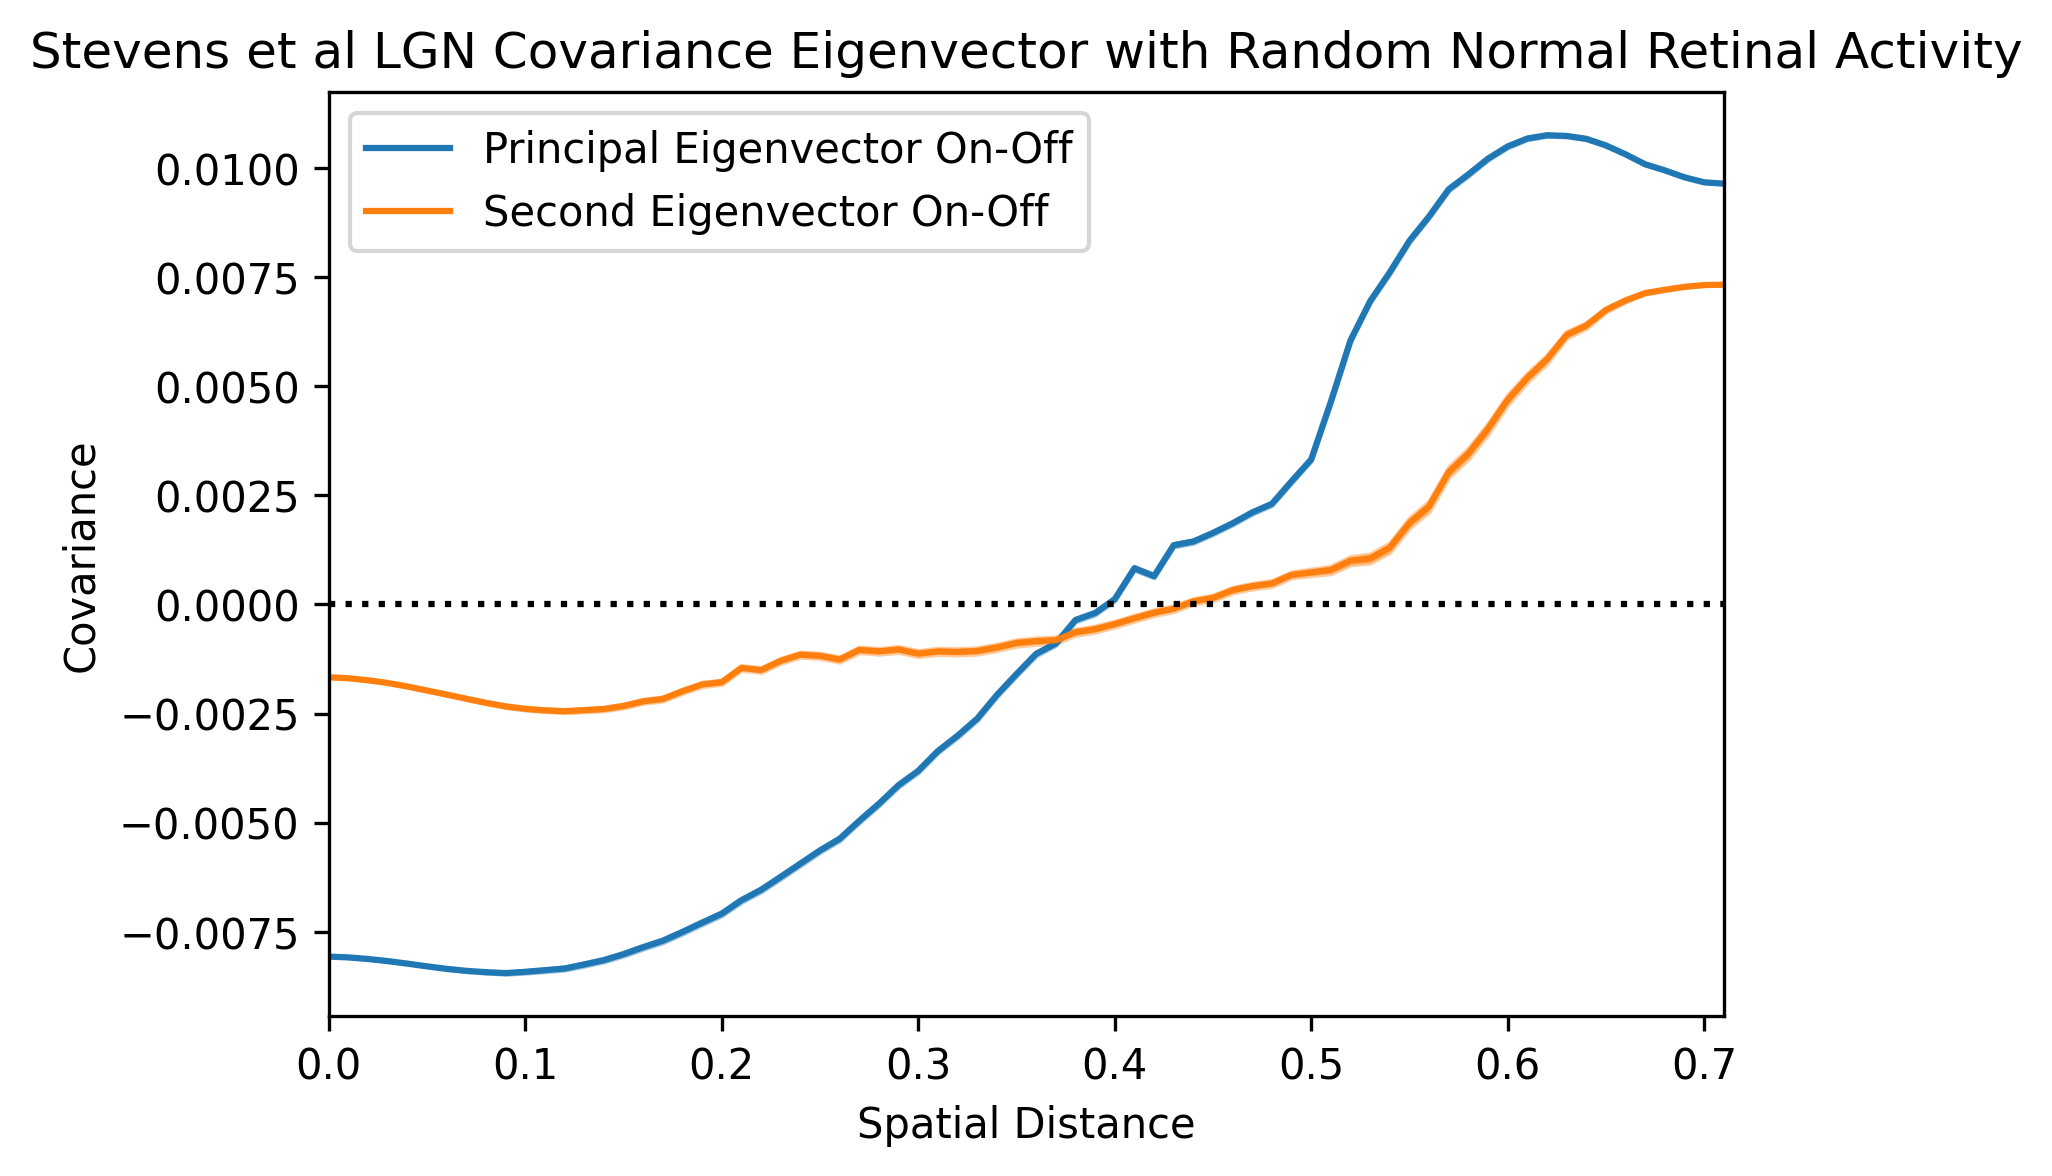

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,gaus_evec[0],c='C0',label='Principal Eigenvector On-Off')
axs.fill_between(dists,gaus_evec[0]-gaus_evec_err[0],gaus_evec[0]+gaus_evec_err[0],color='C0',alpha=0.4)
axs.plot(dists,gaus_evec[1],c='C1',label='Second Eigenvector On-Off')
axs.fill_between(dists,gaus_evec[1]-gaus_evec_err[1],gaus_evec[1]+gaus_evec_err[1],color='C1',alpha=0.4)
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Stevens et al LGN Covariance Eigenvector with Random Normal Retinal Activity')

Text(0.5, 1.0, 'Stevens et al LGN Covariance Eigenvector with Random Normal Retinal Activity')

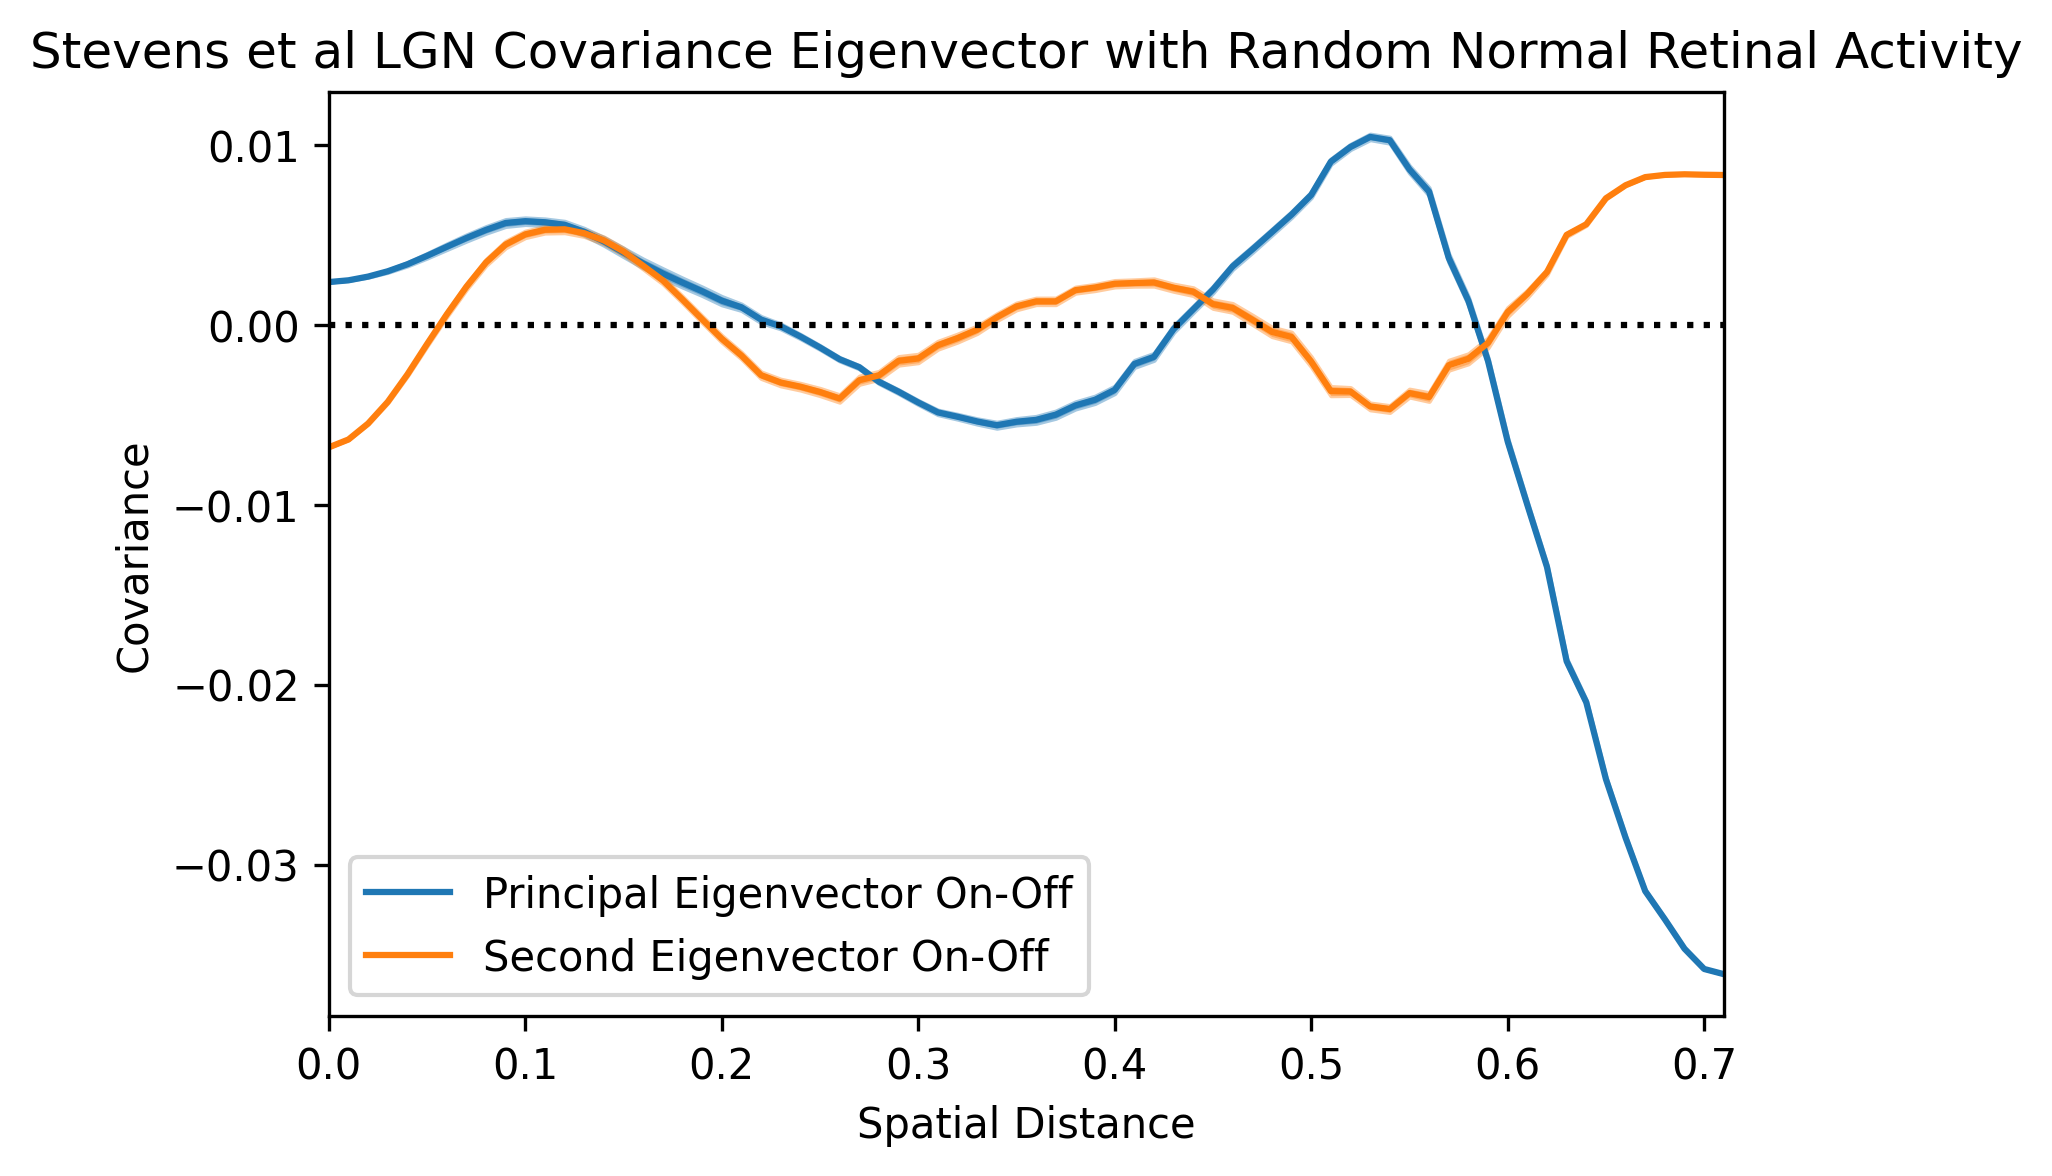

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,norm_evec[0],c='C0',label='Principal Eigenvector On-Off')
axs.fill_between(dists,norm_evec[0]-norm_evec_err[0],norm_evec[0]+norm_evec_err[0],color='C0',alpha=0.4)
axs.plot(dists,norm_evec[1],c='C1',label='Second Eigenvector On-Off')
axs.fill_between(dists,norm_evec[1]-norm_evec_err[1],norm_evec[1]+norm_evec_err[1],color='C1',alpha=0.4)
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Stevens et al LGN Covariance Eigenvector with Random Normal Retinal Activity')

Text(0.5, 1.0, 'Stevens et al LGN Activity Covariance with Gaussian Bars Retinal Activity')

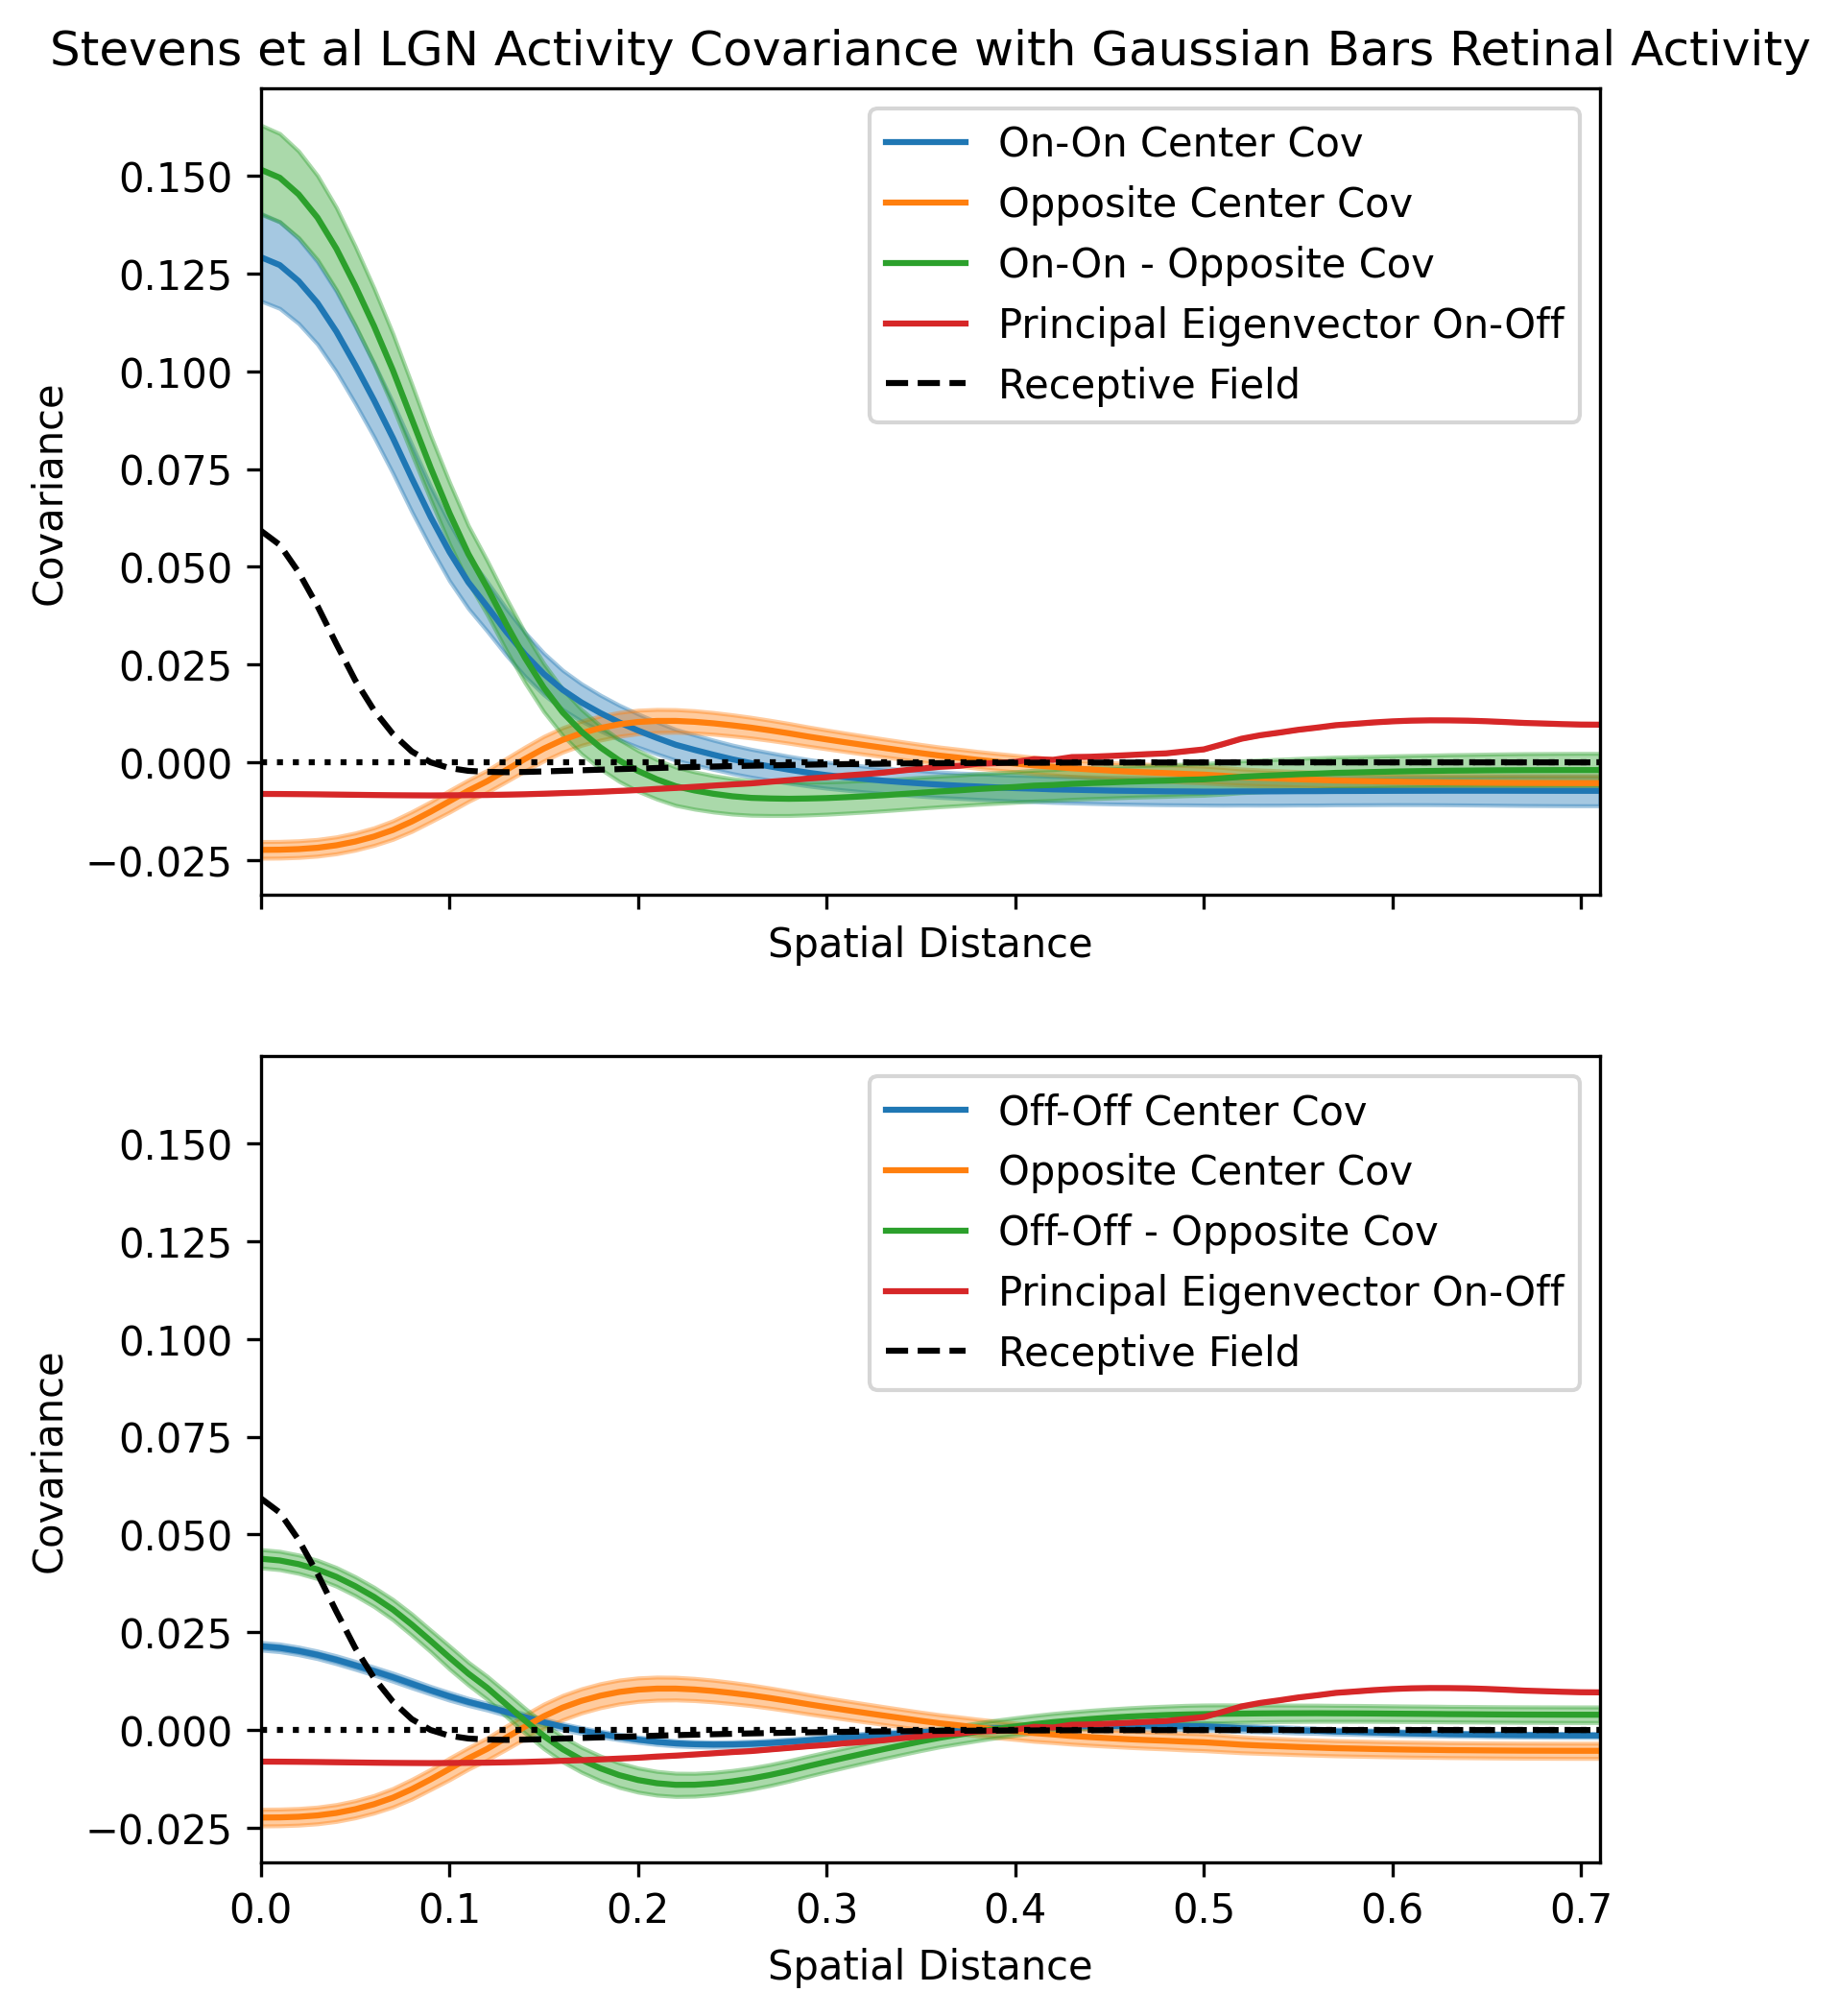

In [30]:
fig,axs = plt.subplots(2,1,figsize=(6,8),dpi=300,sharex=True,sharey=True)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0].plot(dists,gaus_SN_cov,c='C0',label='On-On Center Cov')
axs[0].fill_between(dists,gaus_SN_cov-gaus_SN_cov_err,gaus_SN_cov+gaus_SN_cov_err,color='C0',alpha=0.4)
axs[1].plot(dists,gaus_SF_cov,c='C0',label='Off-Off Center Cov')
axs[1].fill_between(dists,gaus_SF_cov-gaus_SF_cov_err,gaus_SF_cov+gaus_SF_cov_err,color='C0',alpha=0.4)
axs[0].plot(dists,gaus_D_cov,c='C1',label='Opposite Center Cov')
axs[0].fill_between(dists,gaus_D_cov-gaus_D_cov_err,gaus_D_cov+gaus_D_cov_err,color='C1',alpha=0.4)
axs[1].plot(dists,gaus_D_cov,c='C1',label='Opposite Center Cov')
axs[1].fill_between(dists,gaus_D_cov-gaus_D_cov_err,gaus_D_cov+gaus_D_cov_err,color='C1',alpha=0.4)
axs[0].plot(dists,gaus_SN_cov-gaus_D_cov,c='C2',label='On-On - Opposite Cov')
axs[0].fill_between(dists,gaus_SN_cov-gaus_D_cov-np.sqrt(gaus_SN_cov_err**2+gaus_D_cov_err**2),
                 gaus_SN_cov-gaus_D_cov+np.sqrt(gaus_SN_cov_err**2+gaus_D_cov_err**2),color='C2',alpha=0.4)
axs[1].plot(dists,gaus_SF_cov-gaus_D_cov,c='C2',label='Off-Off - Opposite Cov')
axs[1].fill_between(dists,gaus_SF_cov-gaus_D_cov-np.sqrt(gaus_SF_cov_err**2+gaus_D_cov_err**2),
                 gaus_SF_cov-gaus_D_cov+np.sqrt(gaus_SF_cov_err**2+gaus_D_cov_err**2),color='C2',alpha=0.4)
axs[0].plot(dists,gaus_evec[0],c='C3',label='Principal Eigenvector On-Off')
axs[0].fill_between(dists,gaus_evec[0]-gaus_evec_err[0],gaus_evec[0]+gaus_evec_err[0],color='C3',alpha=0.4)
axs[1].plot(dists,gaus_evec[0],c='C3',label='Principal Eigenvector On-Off')
axs[1].fill_between(dists,gaus_evec[0]-gaus_evec_err[0],gaus_evec[0]+gaus_evec_err[0],color='C3',alpha=0.4)

for i in range(2):
    axs[i].plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
    axs[i].axhline(0,c='k',ls=':')
    
    axs[i].legend()
    
    axs[i].set_xlim(dists[0],dists[-1])
    
    axs[i].set_xlabel('Spatial Distance')
    axs[i].set_ylabel('Covariance')
    
axs[0].set_title('Stevens et al LGN Activity Covariance with Gaussian Bars Retinal Activity')

In [31]:
# fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
# fig.subplots_adjust(hspace=.2, wspace=.2)

# axs.plot(dists,dipl_S_cov,c='C0',label='Same Center Cov')
# axs.fill_between(dists,dipl_S_cov-dipl_S_cov_err,dipl_S_cov+dipl_S_cov_err,color='C0',alpha=0.4)
# axs.plot(dists,dipl_D_cov,c='C1',label='Opposite Center Cov')
# axs.fill_between(dists,dipl_D_cov-dipl_D_cov_err,dipl_D_cov+dipl_D_cov_err,color='C1',alpha=0.4)
# axs.plot(dists,dipl_S_cov-dipl_D_cov,c='C2',label='Same - Opposite Cov')
# axs.fill_between(dists,dipl_S_cov-dipl_D_cov-np.sqrt(dipl_S_cov_err**2+dipl_D_cov_err**2),
#                  dipl_S_cov-dipl_D_cov+np.sqrt(dipl_S_cov_err**2+dipl_D_cov_err**2),color='C2',alpha=0.4)
# axs.plot(dists,dipl_evec[0],c='C3',label='Principal Eigenvector On-Off')
# axs.fill_between(dists,dipl_evec[0]-dipl_evec_err[0],dipl_evec[0]+dipl_evec_err[0],color='C3',alpha=0.4)
# axs.plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
# axs.axhline(0,c='k',ls=':')

# axs.legend()

# axs.set_xlim(dists[0],dists[-1])

# axs.set_xlabel('Spatial Distance')
# axs.set_ylabel('Covariance')
# axs.set_title('Stevens et al LGN Activity Covariance with Dipolar Gaussian Bars Retinal Activity')

Text(0.5, 1.0, 'Stevens et al LGN Activity Covariance with Random Normal Retinal Activity')

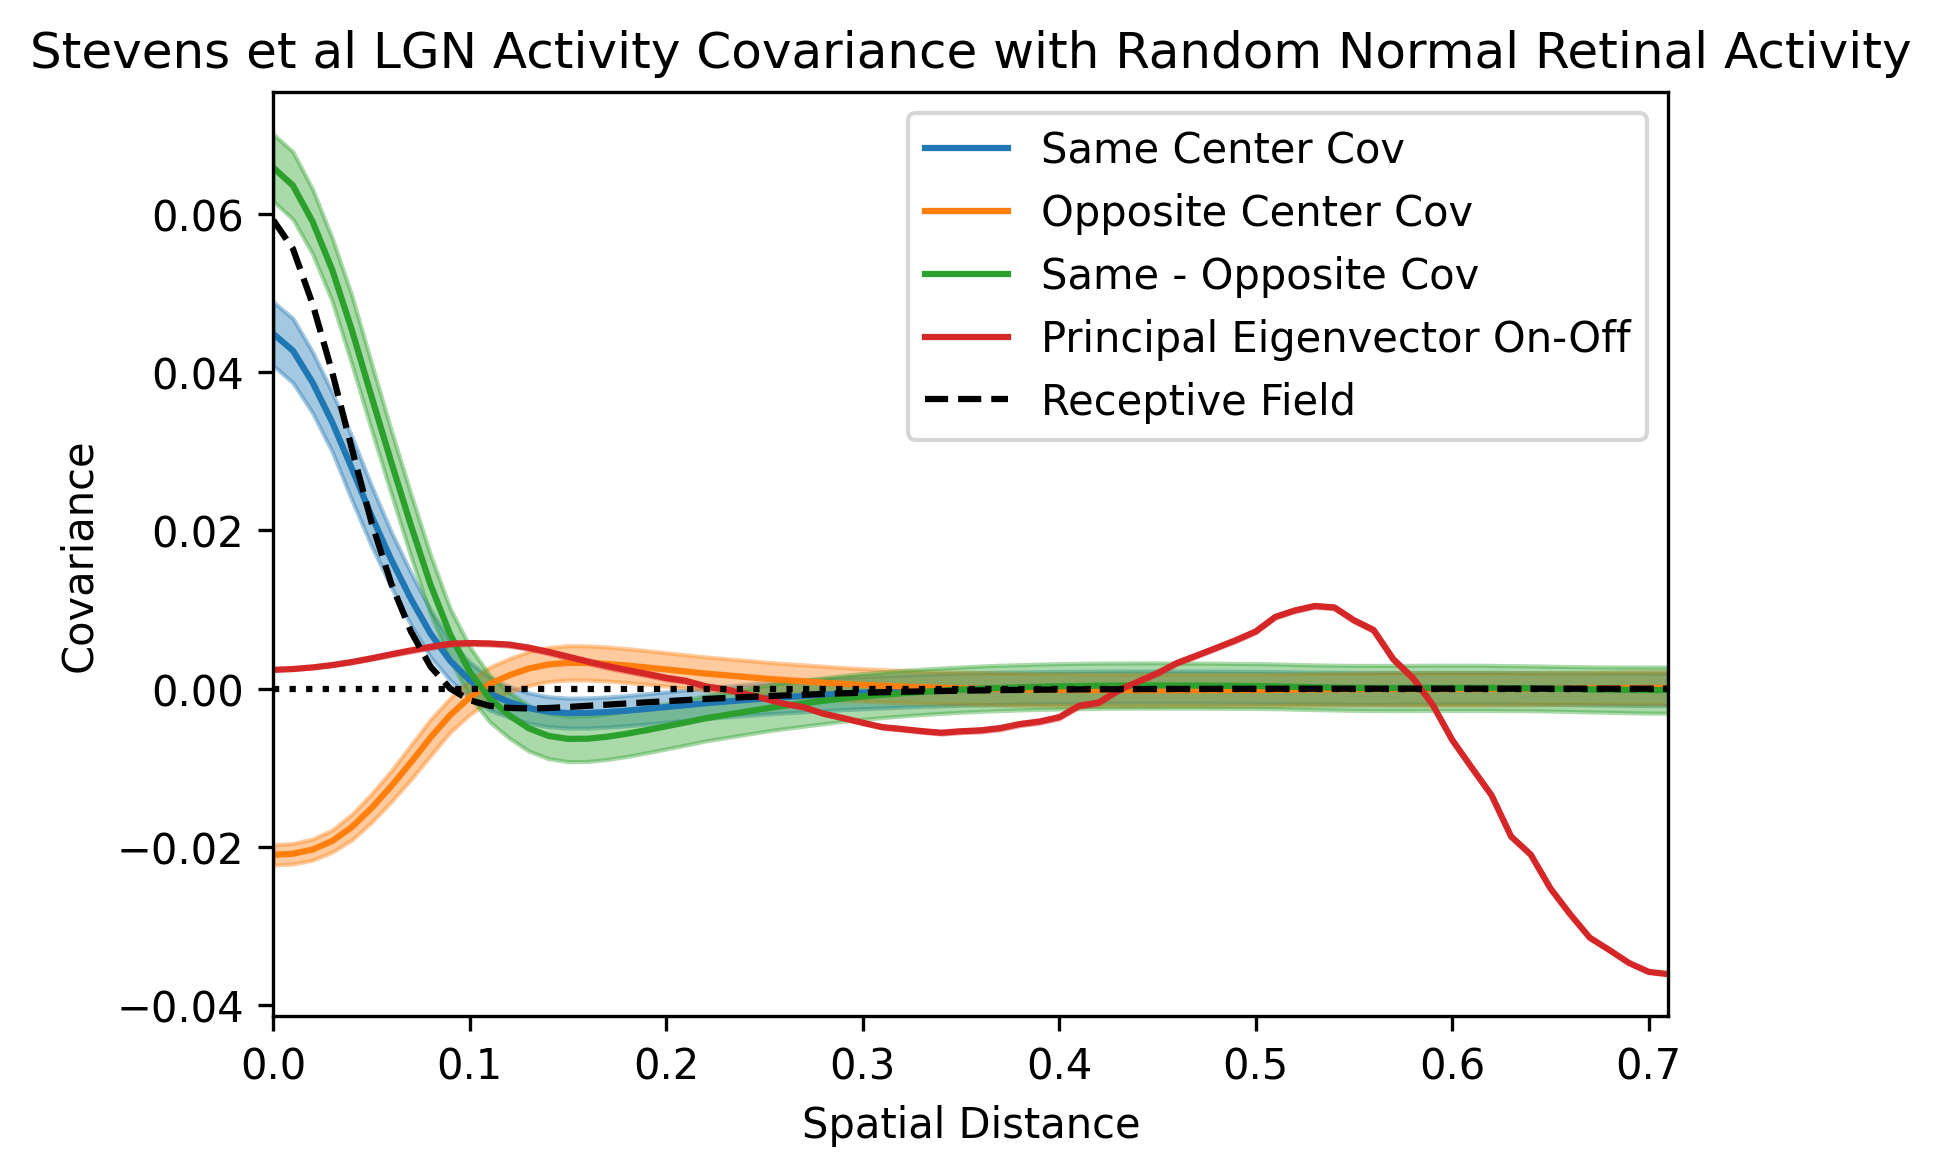

In [32]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,norm_S_cov,c='C0',label='Same Center Cov')
axs.fill_between(dists,norm_S_cov-norm_S_cov_err,norm_S_cov+norm_S_cov_err,color='C0',alpha=0.4)
axs.plot(dists,norm_D_cov,c='C1',label='Opposite Center Cov')
axs.fill_between(dists,norm_D_cov-norm_D_cov_err,norm_D_cov+norm_D_cov_err,color='C1',alpha=0.4)
axs.plot(dists,norm_S_cov-norm_D_cov,c='C2',label='Same - Opposite Cov')
axs.fill_between(dists,norm_S_cov-norm_D_cov-np.sqrt(norm_S_cov_err**2+norm_D_cov_err**2),
                 norm_S_cov-norm_D_cov+np.sqrt(norm_S_cov_err**2+norm_D_cov_err**2),color='C2',alpha=0.4)
axs.plot(dists,norm_evec[0],c='C3',label='Principal Eigenvector On-Off')
axs.fill_between(dists,norm_evec[0]-norm_evec_err[0],norm_evec[0]+norm_evec_err[0],color='C3',alpha=0.4)
axs.plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Stevens et al LGN Activity Covariance with Random Normal Retinal Activity')

# Look at Effect of Gain Control

In [13]:
gcconn_params = {
    'sigma':  0.037,
    'ampl':   1.0,
    'noise':   0.0,
    'profile': 'Gaussian',
    'stevensetal': True
}

In [14]:
reload(connectivity)

Wgc,_ = conn.create_matrix(gcconn_params,gcconn_params['profile'])

In [15]:
from scipy.integrate import solve_ivp

def dynamics_system(y,inp_ff,Wrec,gam_o=14.0,gam_s=1.02,k=0.11):
    return fio_rect(gam_o*inp_ff/(k+np.matmul(Wrec,y)))

def integrate(y0,inp,Nt,Wrec,gam_o=14.0,gam_s=1.02,k=0.11):
    y = y0
    for t_idx in range(Nt):
        out = dynamics_system(y,inp,Wrec,gam_o,gam_s,k)
        y = out
    return y

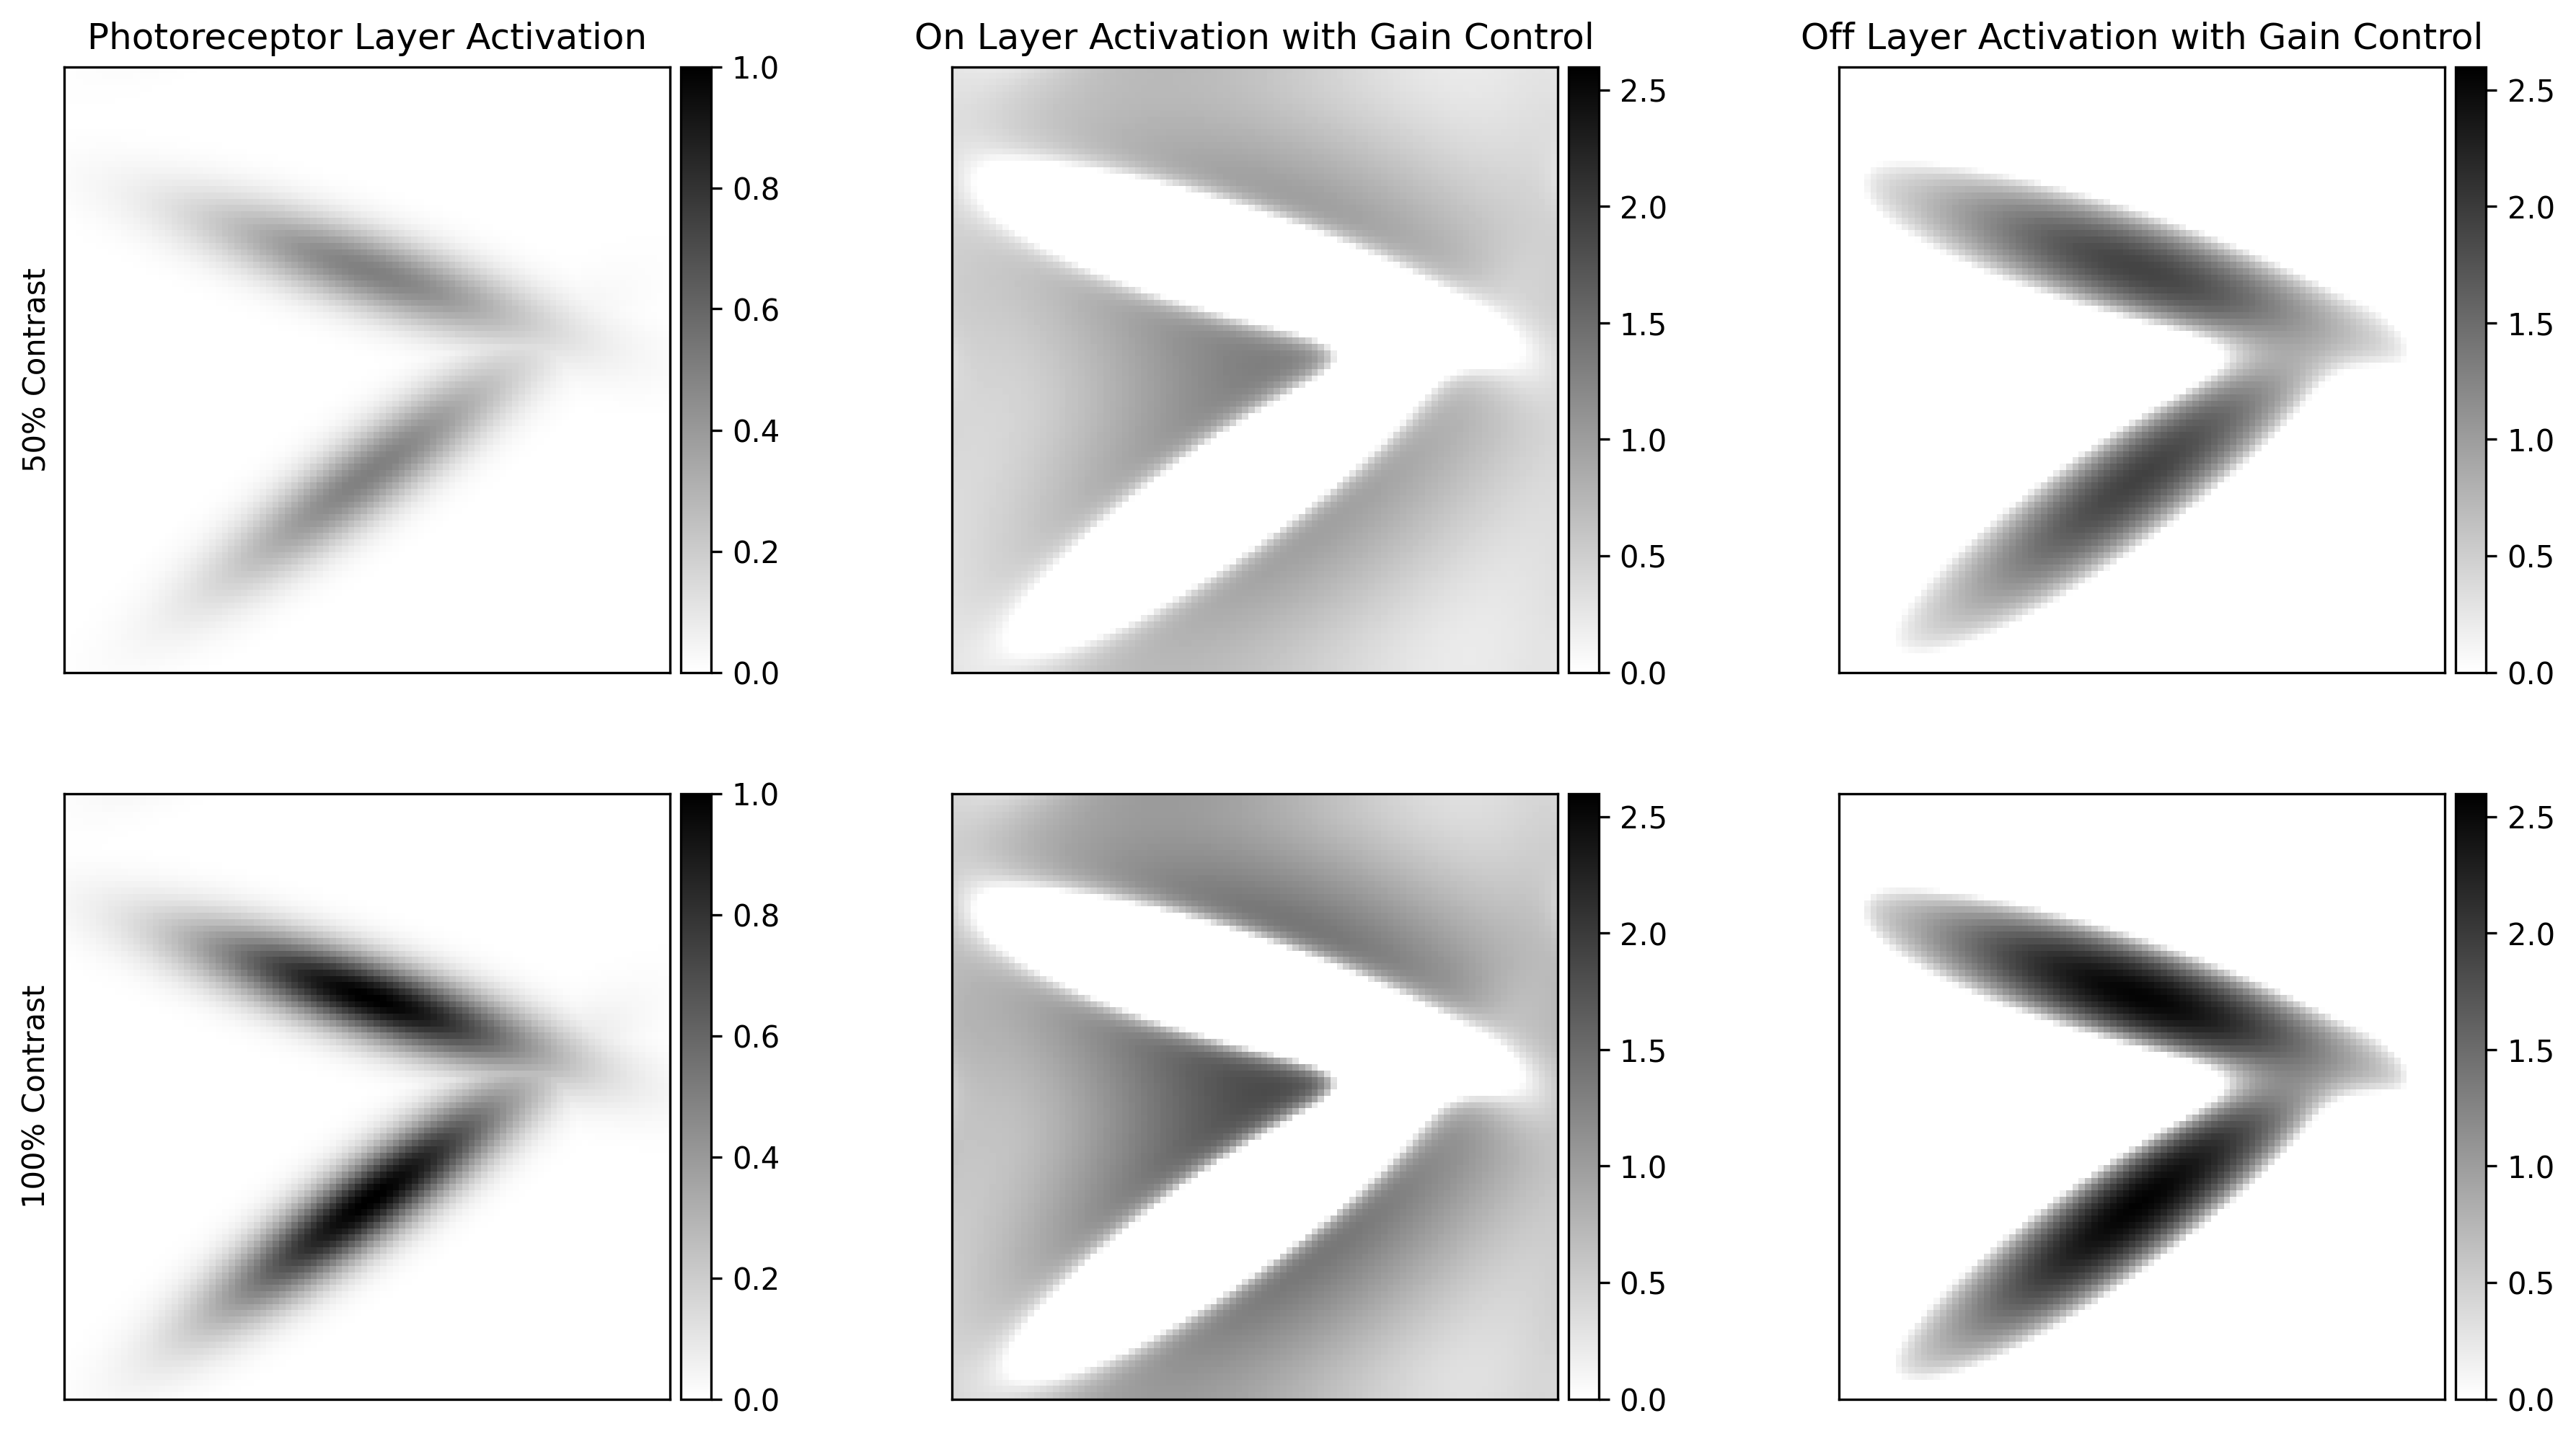

In [17]:
fig,axs = plt.subplots(2,3,figsize=(15,8),dpi=300)

psi = 0.5*np.fmax(stevens_gauss(Nret//3,Nret//2,np.pi*0.9),stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
N_act = integrate(np.zeros(Nret**2),-Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
F_act = integrate(np.zeros(Nret**2),Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
pf.imshowbar(fig,axs[0,0],psi,cmap='binary',vmin=0,vmax=1)
pf.imshowbar(fig,axs[0,1],N_act,cmap='binary',vmin=0,vmax=2.6)
pf.imshowbar(fig,axs[0,2],F_act,cmap='binary',vmin=0,vmax=2.6)

psi = np.fmax(stevens_gauss(Nret//3,Nret//2,np.pi*0.9),stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
N_act = integrate(np.zeros(Nret**2),-Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
F_act = integrate(np.zeros(Nret**2),Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
pf.imshowbar(fig,axs[1,0],psi,cmap='binary',vmin=0,vmax=1)
pf.imshowbar(fig,axs[1,1],N_act,cmap='binary',vmin=0,vmax=2.6)
pf.imshowbar(fig,axs[1,2],F_act,cmap='binary',vmin=0,vmax=2.6)

axs[0,0].set_title('Photoreceptor Layer Activation')
axs[0,1].set_title('On Layer Activation with Gain Control')
axs[0,2].set_title('Off Layer Activation with Gain Control')

axs[0,0].set_ylabel('50% Contrast')
axs[1,0].set_ylabel('100% Contrast')

fig.savefig('./stevens_inputs.pdf')

Text(0, 0.5, '100% Contrast')

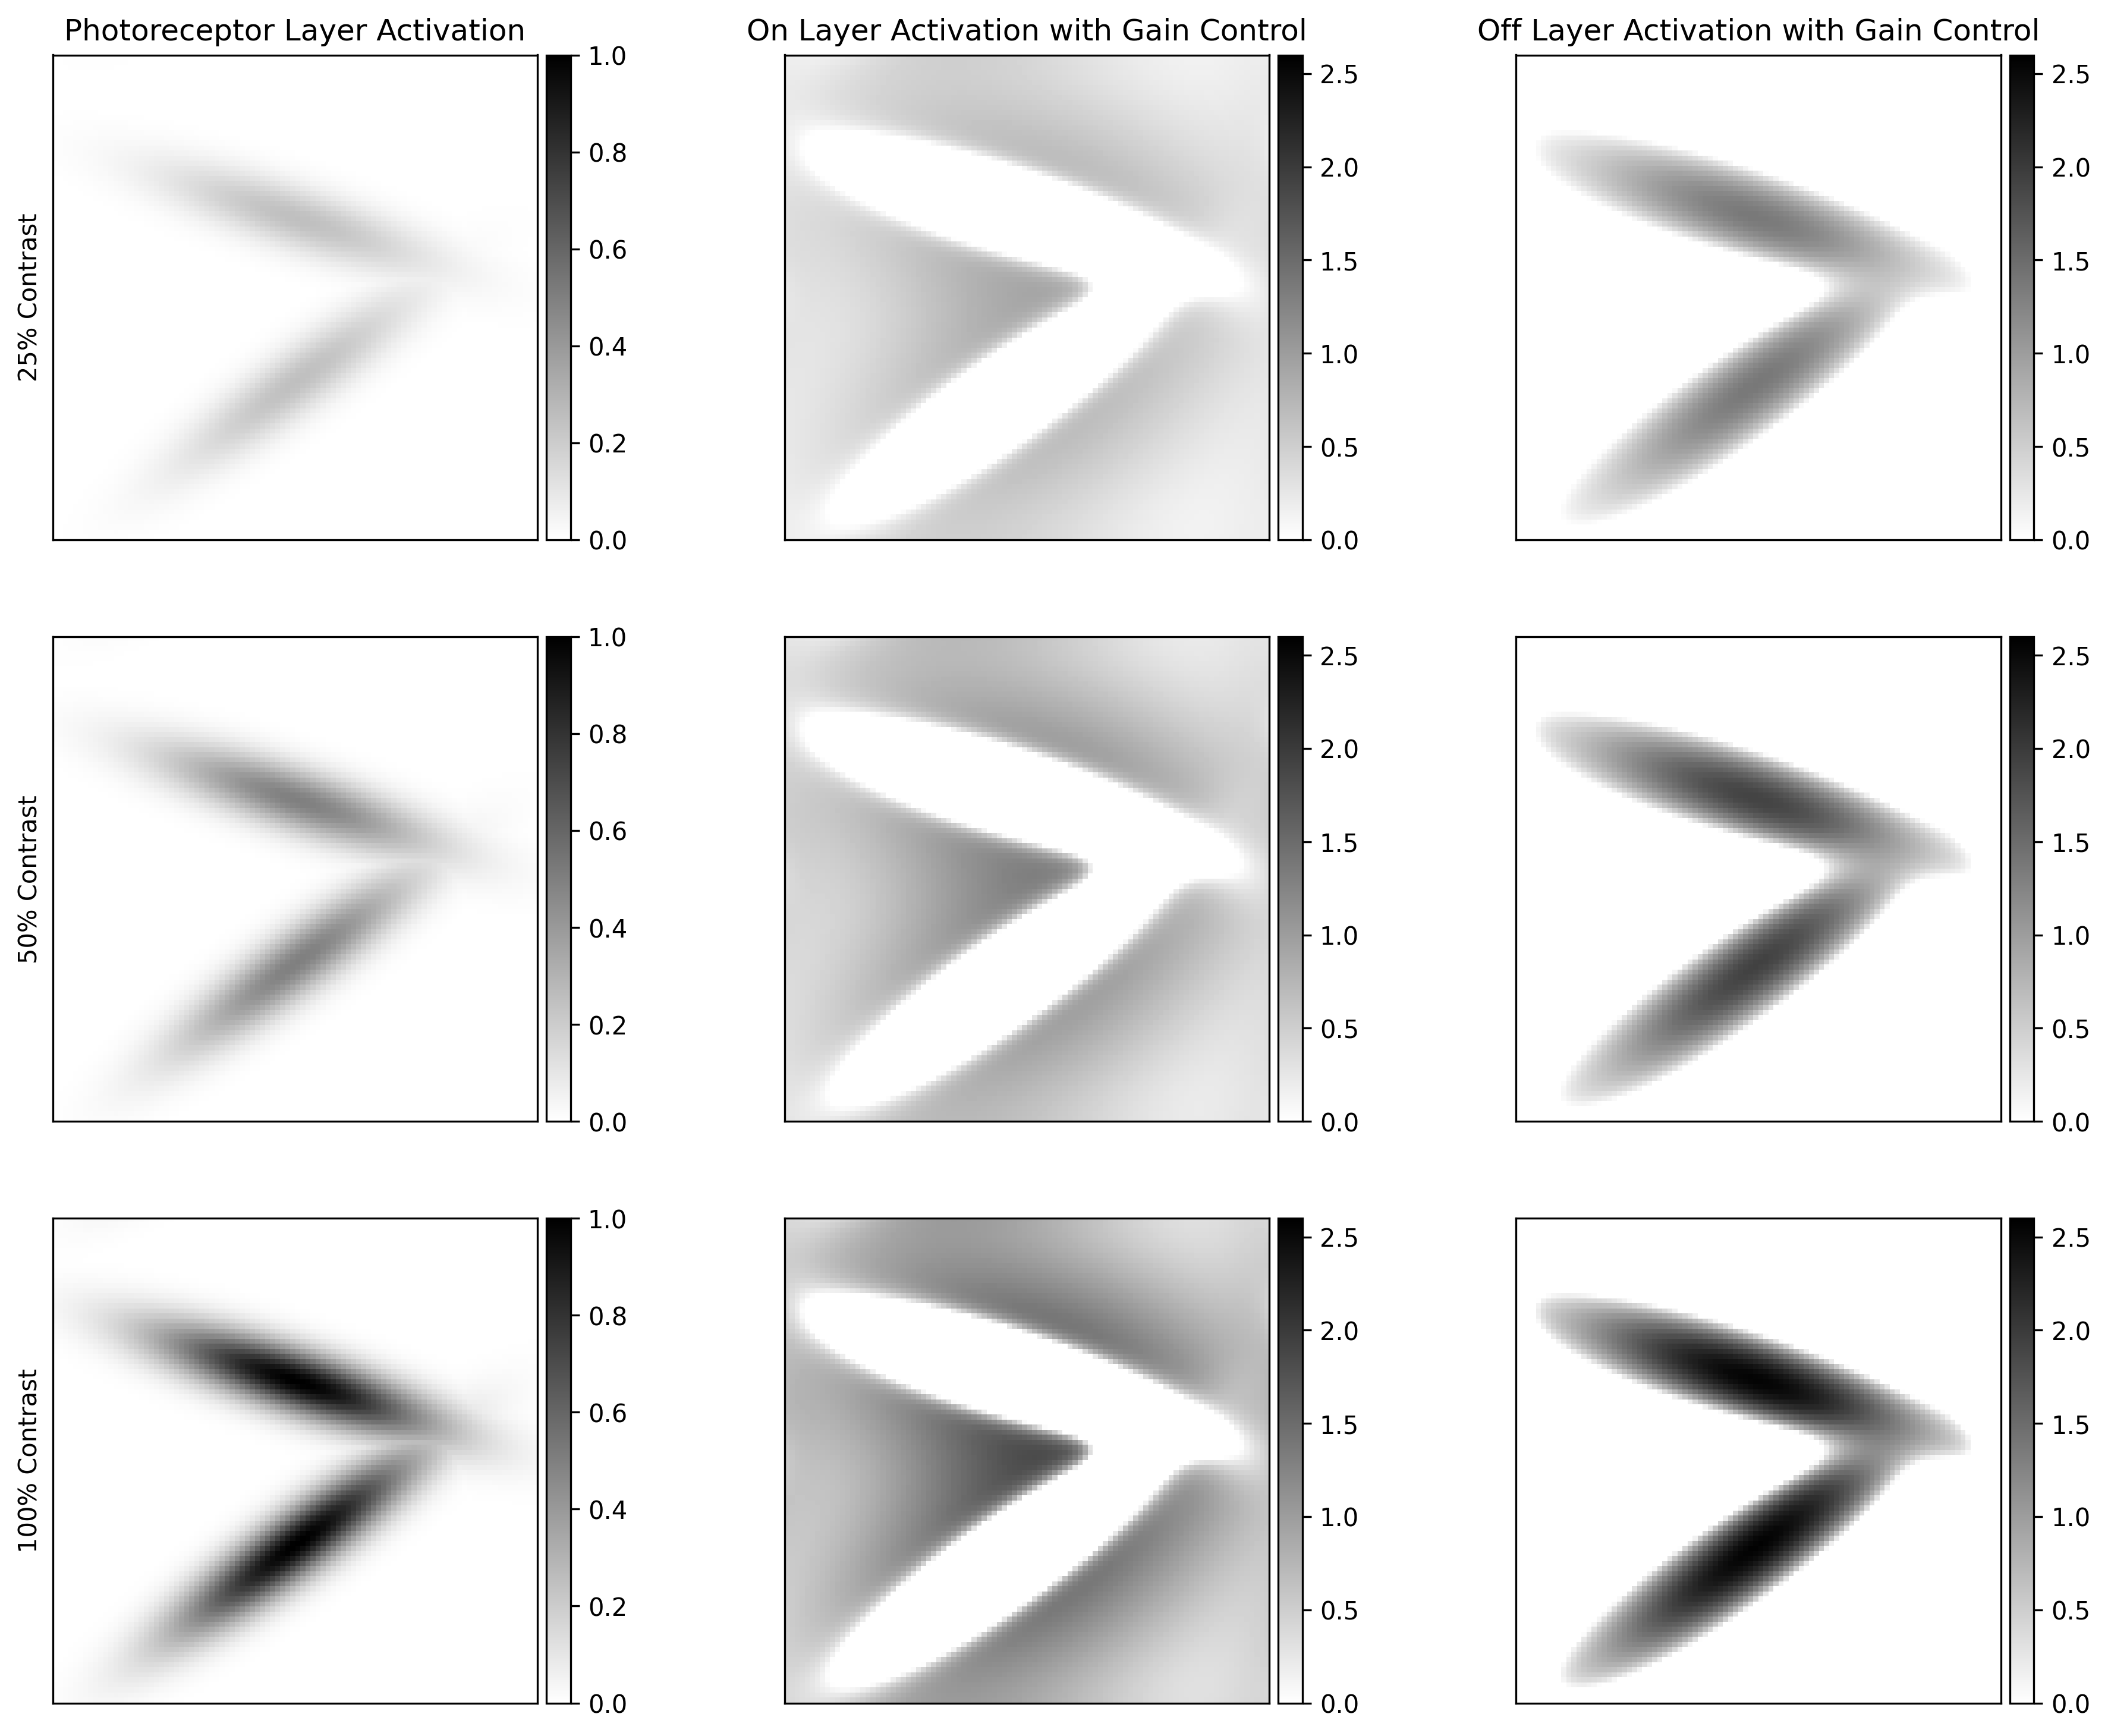

In [22]:
fig,axs = plt.subplots(3,3,figsize=(15,12),dpi=300)

psi = 0.25*np.fmax(stevens_gauss(Nret//3,Nret//2,np.pi*0.9),stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
N_act = integrate(np.zeros(Nret**2),-Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
F_act = integrate(np.zeros(Nret**2),Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
pf.imshowbar(fig,axs[0,0],psi,cmap='binary',vmin=0,vmax=1)
pf.imshowbar(fig,axs[0,1],N_act,cmap='binary',vmin=0,vmax=2.6)
pf.imshowbar(fig,axs[0,2],F_act,cmap='binary',vmin=0,vmax=2.6)

psi = 0.5*np.fmax(stevens_gauss(Nret//3,Nret//2,np.pi*0.9),stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
N_act = integrate(np.zeros(Nret**2),-Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
F_act = integrate(np.zeros(Nret**2),Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
pf.imshowbar(fig,axs[1,0],psi,cmap='binary',vmin=0,vmax=1)
pf.imshowbar(fig,axs[1,1],N_act,cmap='binary',vmin=0,vmax=2.6)
pf.imshowbar(fig,axs[1,2],F_act,cmap='binary',vmin=0,vmax=2.6)

psi = np.fmax(stevens_gauss(Nret//3,Nret//2,np.pi*0.9),stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
N_act = integrate(np.zeros(Nret**2),-Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
F_act = integrate(np.zeros(Nret**2),Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
pf.imshowbar(fig,axs[2,0],psi,cmap='binary',vmin=0,vmax=1)
pf.imshowbar(fig,axs[2,1],N_act,cmap='binary',vmin=0,vmax=2.6)
pf.imshowbar(fig,axs[2,2],F_act,cmap='binary',vmin=0,vmax=2.6)

axs[0,0].set_title('Photoreceptor Layer Activation')
axs[0,1].set_title('On Layer Activation with Gain Control')
axs[0,2].set_title('Off Layer Activation with Gain Control')

axs[0,0].set_ylabel('25% Contrast')
axs[1,0].set_ylabel('50% Contrast')
axs[2,0].set_ylabel('100% Contrast')

Text(0, 0.5, '100% Contrast')

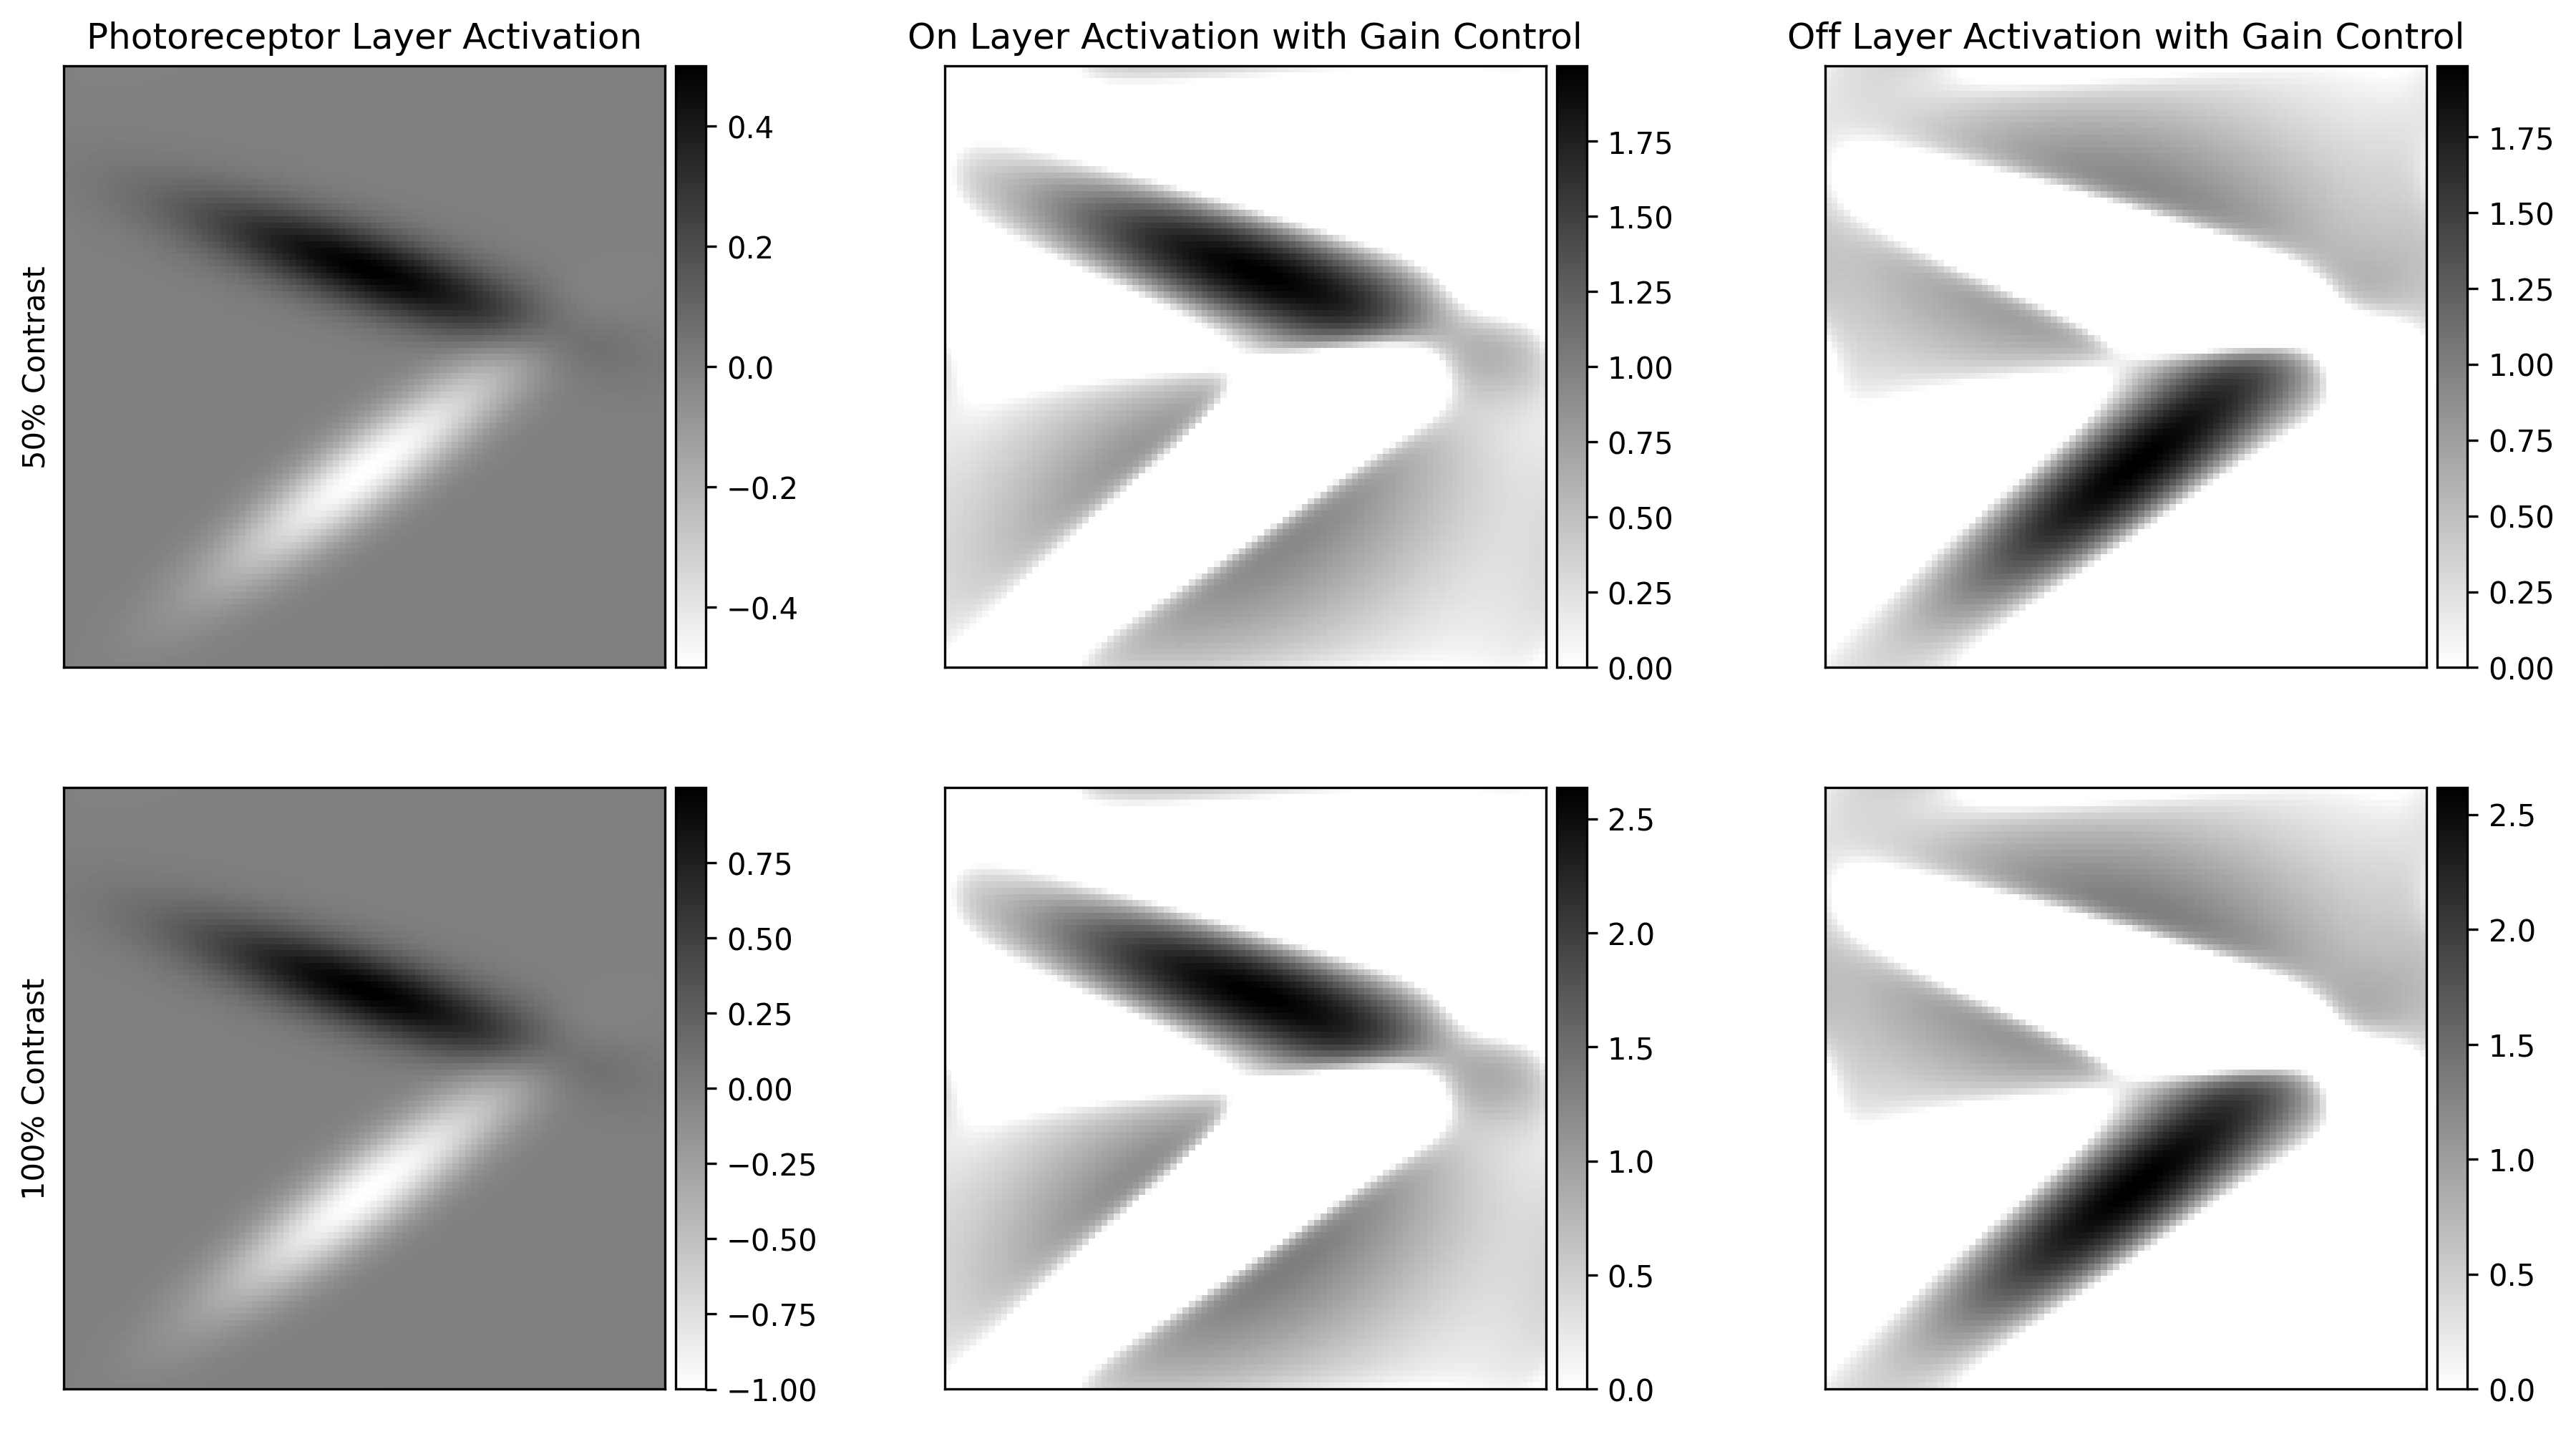

In [17]:
fig,axs = plt.subplots(2,3,figsize=(15,8),dpi=300)

psi = 0.5*(stevens_gauss(Nret//3,Nret//2,np.pi*0.9)-stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
N_act = integrate(np.zeros(Nret**2),Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
F_act = integrate(np.zeros(Nret**2),-Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
pf.imshowbar(fig,axs[0,0],psi,cmap='binary')
pf.imshowbar(fig,axs[0,1],N_act,cmap='binary')
pf.imshowbar(fig,axs[0,2],F_act,cmap='binary')

psi = (stevens_gauss(Nret//3,Nret//2,np.pi*0.9)-stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
N_act = integrate(np.zeros(Nret**2),Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
F_act = integrate(np.zeros(Nret**2),-Wpatt.flatten(),50,Wgc).reshape((Nret,Nret))
pf.imshowbar(fig,axs[1,0],psi,cmap='binary')
pf.imshowbar(fig,axs[1,1],N_act,cmap='binary')
pf.imshowbar(fig,axs[1,2],F_act,cmap='binary')

axs[0,0].set_title('Photoreceptor Layer Activation')
axs[0,1].set_title('On Layer Activation with Gain Control')
axs[0,2].set_title('Off Layer Activation with Gain Control')

axs[0,0].set_ylabel('50% Contrast')
axs[1,0].set_ylabel('100% Contrast')

In [18]:
# gaus_N_act = np.zeros_like(gaus_Wpsis)
# gaus_F_act = np.zeros_like(gaus_Wpsis)

# dipl_N_act = np.zeros_like(gaus_Wpsis)
# dipl_F_act = np.zeros_like(gaus_Wpsis)

# unif_N_act = np.zeros_like(unif_Wpsis)
# unif_F_act = np.zeros_like(unif_Wpsis)

# norm_N_act = np.zeros_like(norm_Wpsis)
# norm_F_act = np.zeros_like(norm_Wpsis)

# for i in range(n_ret_patts):
#     start = time.process_time()
#     gaus_N_act[i] = integrate(np.zeros(Nret**2),gaus_Wpsis[i],50,Wgc)
#     gaus_F_act[i] = integrate(np.zeros(Nret**2),-gaus_Wpsis[i],50,Wgc)

#     dipl_N_act[i] = integrate(np.zeros(Nret**2),dipl_Wpsis[i],50,Wgc)
#     dipl_F_act[i] = integrate(np.zeros(Nret**2),-dipl_Wpsis[i],50,Wgc)
    
#     unif_N_act[i] = integrate(np.zeros(Nret**2),unif_Wpsis[i],50,Wgc,17)
#     unif_F_act[i] = integrate(np.zeros(Nret**2),-unif_Wpsis[i],50,Wgc,17)
    
#     norm_N_act[i] = integrate(np.zeros(Nret**2),norm_Wpsis[i],50,Wgc,5)
#     norm_F_act[i] = integrate(np.zeros(Nret**2),-norm_Wpsis[i],50,Wgc,5)
    
#     print('integrating retinal pattern #',i,'took',time.process_time()-start)
    
# np.save('gaus_N_act.npy',gaus_N_act)
# np.save('gaus_F_act.npy',gaus_F_act)
# np.save('dipl_N_act.npy',dipl_N_act)
# np.save('dipl_F_act.npy',dipl_F_act)
# np.save('unif_N_act.npy',unif_N_act)
# np.save('unif_F_act.npy',unif_F_act)
# np.save('norm_N_act.npy',norm_N_act)
# np.save('norm_F_act.npy',norm_F_act)
    
gaus_N_act = np.load('gaus_N_act.npy')
gaus_F_act = np.load('gaus_F_act.npy')
# dipl_N_act = np.load('dipl_N_act.npy')
# dipl_F_act = np.load('dipl_F_act.npy')
# unif_N_act = np.load('unif_N_act.npy')
# unif_F_act = np.load('unif_F_act.npy')
# norm_N_act = np.load('norm_N_act.npy')
# norm_F_act = np.load('norm_F_act.npy')

Text(0.5, 1.0, 'Off Cell Activity Histogram')

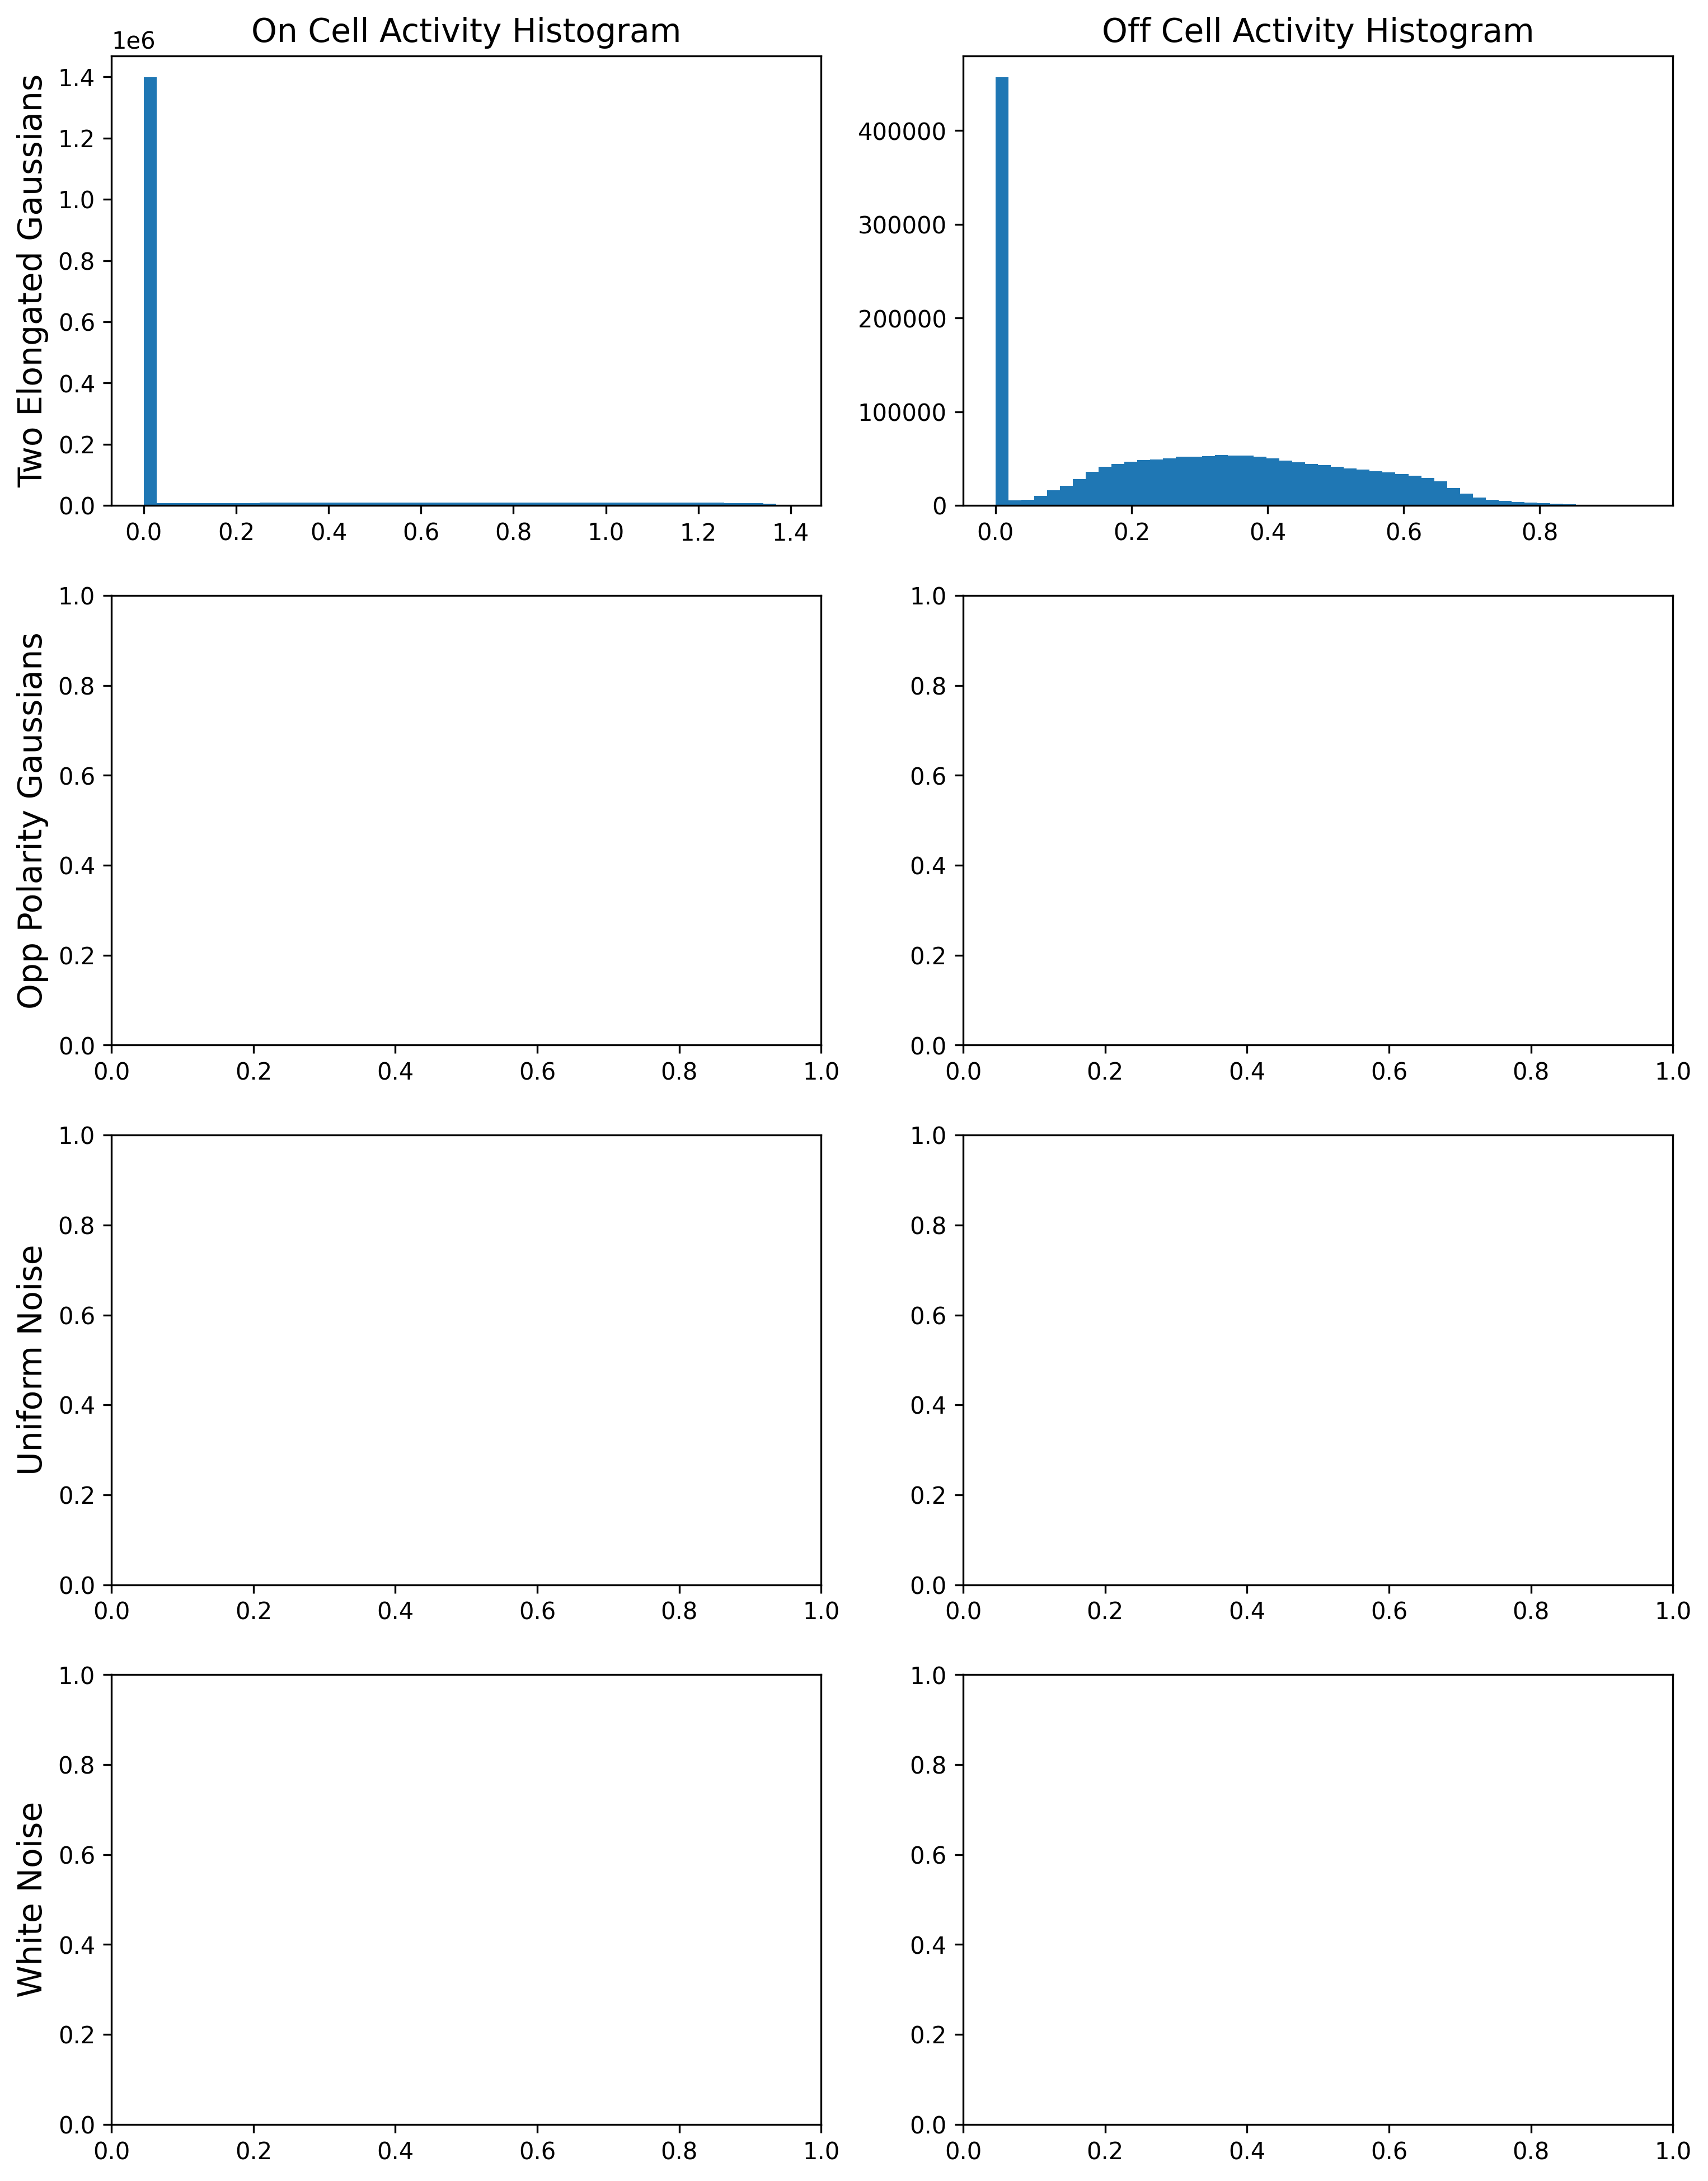

In [25]:
fig,axs = plt.subplots(4,2,figsize=(12,16),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0,0].hist(gaus_N_act.flatten(),50)
axs[0,1].hist(gaus_F_act.flatten(),50)
# axs[1,0].hist(dipl_N_act.flatten(),50)
# axs[1,1].hist(dipl_F_act.flatten(),50)
# axs[2,0].hist(unif_N_act.flatten(),50)
# axs[2,1].hist(unif_F_act.flatten(),50)
# axs[3,0].hist(norm_N_act.flatten(),50)
# axs[3,1].hist(norm_F_act.flatten(),50)

axs[0,0].set_ylabel('Two Elongated Gaussians',fontsize=14)
axs[1,0].set_ylabel('Opp Polarity Gaussians',fontsize=14)
axs[2,0].set_ylabel('Uniform Noise',fontsize=14)
axs[3,0].set_ylabel('White Noise',fontsize=14)
axs[0,0].set_title('On Cell Activity Histogram',fontsize=14)
axs[0,1].set_title('Off Cell Activity Histogram',fontsize=14)

(array([  1.,   1.,   1.,   3.,   0.,   8.,   7.,  23.,  22.,  33.,  52.,
         75.,  90., 107., 164., 202., 260., 306., 375., 480., 529., 546.,
        572., 634., 622., 635., 587., 533., 518., 447., 430., 371., 321.,
        256., 211., 171., 126.,  83.,  62.,  36.,  37.,  24.,  15.,  10.,
          3.,   2.,   5.,   0.,   2.,   2.]),
 array([-0.56539259, -0.5310634 , -0.49673421, -0.46240502, -0.42807582,
        -0.39374663, -0.35941744, -0.32508825, -0.29075905, -0.25642986,
        -0.22210067, -0.18777148, -0.15344229, -0.11911309, -0.0847839 ,
        -0.05045471, -0.01612552,  0.01820368,  0.05253287,  0.08686206,
         0.12119125,  0.15552045,  0.18984964,  0.22417883,  0.25850802,
         0.29283722,  0.32716641,  0.3614956 ,  0.39582479,  0.43015399,
         0.46448318,  0.49881237,  0.53314156,  0.56747076,  0.60179995,
         0.63612914,  0.67045833,  0.70478753,  0.73911672,  0.77344591,
         0.8077751 ,  0.8421043 ,  0.87643349,  0.91076268,  0.94509187,
 

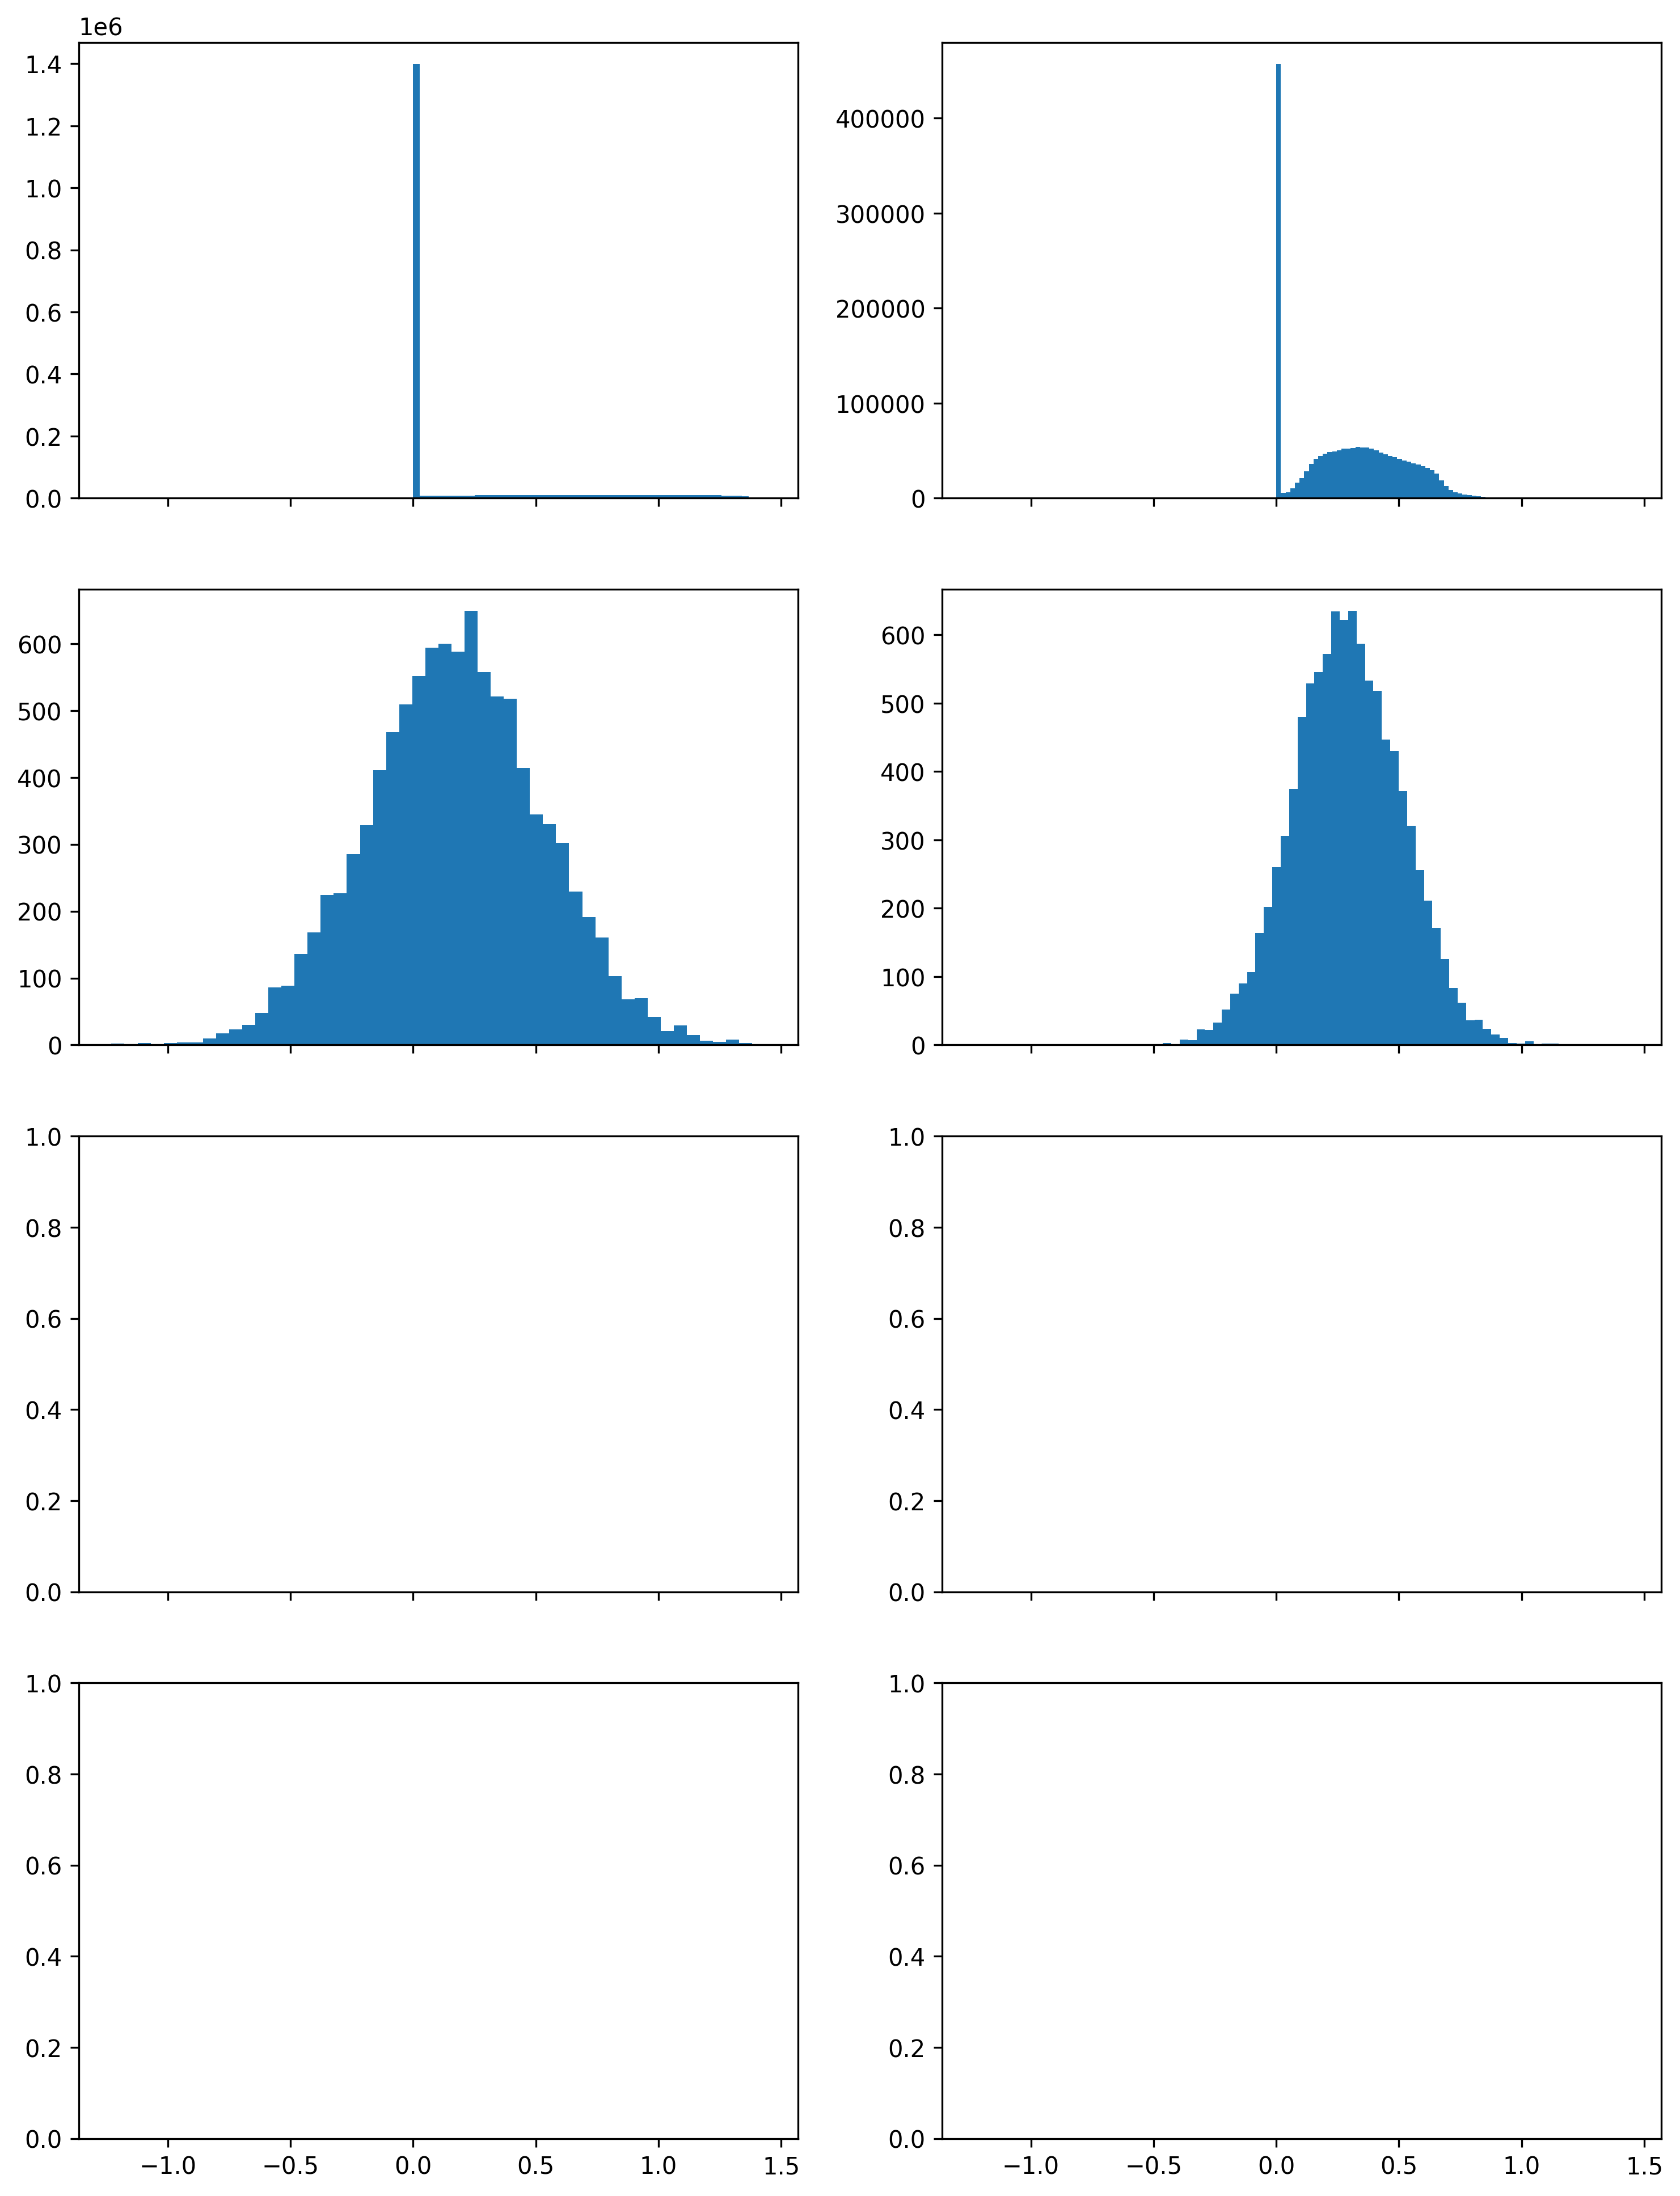

In [14]:
fig,axs = plt.subplots(4,2,figsize=(12,16),dpi=300,sharex=True)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0,0].hist(gaus_N_act.flatten(),50)
axs[0,1].hist(gaus_F_act.flatten(),50)
axs[1,0].hist(np.random.normal(loc=np.mean(gaus_N_act),scale=np.std(gaus_N_act),size=10000),50)
axs[1,1].hist(np.random.normal(loc=np.mean(gaus_F_act),scale=np.std(gaus_F_act),size=10000),50)

In [19]:
print(np.mean(gaus_N_act))
print(np.mean(gaus_F_act))
print()
print(np.std(gaus_N_act))
print(np.std(gaus_F_act))
print()
print(np.mean(gaus_N_act[gaus_N_act > 0]))
print(np.mean(gaus_F_act[gaus_F_act > 0]))
print()
print(np.std(gaus_N_act[gaus_N_act > 0]))
print(np.std(gaus_F_act[gaus_F_act > 0]))
print()
print(np.mean(gaus_N_act > 0))
print(np.mean(gaus_F_act > 0))

0.16991828770795417
0.2849416036708087

0.35228433161191264
0.22063209400988587

0.692856673649877
0.37752763425124397

0.3791102479548492
0.1718773981050248

0.24524305555555556
0.7547569444444444


In [20]:
def phi(x):
    return np.exp(-0.5*x**2)/np.sqrt(2*np.pi)

def Phi(x):
    return 0.5*(1+special.erf(x/np.sqrt(2)))

def trunc_norm_stats(mu,sig,a=0,b=1e12):
    alp = (a-mu)/sig
    bet = (b-mu)/sig
    phi_alp = phi(alp)
    phi_bet = phi(bet)
    Phi_alp = Phi(alp)
    Phi_bet = Phi(bet)
    Z = Phi_bet - Phi_alp
    
    return (mu+(phi_alp-phi_bet)/Z*sig,sig*np.sqrt(1-(bet*phi_bet-alp*phi_alp)/Z-((phi_alp-phi_bet)/Z)**2))

In [21]:
def res(x):
    mup,sigp = trunc_norm_stats(x[0],x[1])
    return [mup-np.mean(gaus_N_act),sigp-np.std(gaus_N_act)]

sol = optimize.least_squares(res,[np.mean(gaus_N_act),2*np.std(gaus_N_act)],
                             max_nfev=2000,ftol=None,xtol=None)
print(sol)
print()
print(sol.x)
trunc_gaus_N_mean,trunc_gaus_N_std = sol.x

print()

def res(x):
    mup,sigp = trunc_norm_stats(x[0],x[1])
    return [mup-np.mean(gaus_F_act),sigp-np.std(gaus_F_act)]

sol = optimize.least_squares(res,[np.mean(gaus_F_act),2*np.std(gaus_F_act)],
                             max_nfev=2000,ftol=None,xtol=None)
print(sol)
print()
print(sol.x)
trunc_gaus_F_mean,trunc_gaus_F_std = sol.x

print()

def res(x):
    mup,sigp = trunc_norm_stats(x[0],x[1])
    return [mup-np.mean(np.concatenate((norm_N_act,norm_F_act))),
            sigp-np.std(np.concatenate((norm_N_act,norm_F_act)))]

sol = optimize.least_squares(res,[np.mean(np.concatenate((norm_N_act,norm_F_act))),
                                  2*np.std(np.concatenate((norm_N_act,norm_F_act)))],
                             max_nfev=2000,ftol=None,xtol=None)
print(sol)
print()
print(sol.x)
trunc_norm_mean,trunc_norm_std = sol.x

/usr/local/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/usr/local/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = phi / phi_prime
/usr/local/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:166: RuntimeWarning: divide by zero encountered in scalar divide
  p *= Delta / norm(p)
/usr/local/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:166: RuntimeWarning: invalid value encountered in multiply
  p *= Delta / norm(p)
/usr/local/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: invalid value encountered in scalar divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm


     message: The maximum number of function evaluations is exceeded.
     success: False
      status: 0
         fun: [ 8.897e-02 -9.962e-02]
           x: [-9.183e+00  1.584e+00]
        cost: 0.008919684681797942
         jac: [[-1.048e+00  7.357e+00]
               [ 2.063e+01 -1.350e+02]]
        grad: [-2.149e+00  1.410e+01]
  optimality: 14.098931840125882
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 2000
        njev: 22

[-9.18339375  1.58377762]

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 4.291e-14  1.241e-14]
           x: [-6.374e-02  3.848e-01]
        cost: 9.976028222434224e-28
         jac: [[ 3.288e-01  7.951e-01]
               [ 1.736e-01  6.022e-01]]
        grad: [ 1.626e-14  4.159e-14]
  optimality: 4.158766994510604e-14
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 6
        njev: 6

[-0.06374231  0.38475066]



NameError: name 'norm_N_act' is not defined

In [22]:
gaus_full_cov = np.cov(gaus_N_act.T,gaus_F_act.T)
gaus_NN_cov = gaus_full_cov[:N**2,:N**2]
gaus_NF_cov = gaus_full_cov[:N**2,N**2:]
gaus_FN_cov = gaus_full_cov[N**2:,:N**2]
gaus_FF_cov = gaus_full_cov[N**2:,N**2:]

# dipl_full_cov = np.cov(dipl_N_act.T,dipl_F_act.T)
# dipl_NN_cov = dipl_full_cov[:N**2,:N**2]
# dipl_NF_cov = dipl_full_cov[:N**2,N**2:]
# dipl_FN_cov = dipl_full_cov[N**2:,:N**2]
# dipl_FF_cov = dipl_full_cov[N**2:,N**2:]

# # unif_full_cov = np.cov(unif_N_act.T,unif_F_act.T)
# # unif_NN_cov = unif_full_cov[:N**2,:N**2]
# # unif_NF_cov = unif_full_cov[:N**2,N**2:]
# # unif_FN_cov = unif_full_cov[N**2:,:N**2]
# # unif_FF_cov = unif_full_cov[N**2:,N**2:]

# norm_full_cov = np.cov(norm_N_act.T,norm_F_act.T)
# norm_NN_cov = norm_full_cov[:N**2,:N**2]
# norm_NF_cov = norm_full_cov[:N**2,N**2:]
# norm_FN_cov = norm_full_cov[N**2:,:N**2]
# norm_FF_cov = norm_full_cov[N**2:,N**2:]

In [12]:
gaus_evals,gaus_evecs = sparse.linalg.eigsh(gaus_full_cov,4)
# dipl_evals,dipl_evecs = sparse.linalg.eigsh(dipl_full_cov,4)
# norm_evals,norm_evecs = sparse.linalg.eigsh(norm_full_cov,4)

In [23]:
dists = np.linspace(0,0.71,72)
bin_idxs_4d = np.digitize(ds,np.linspace(0,0.7,71)+0.005)
bin_idxs_2d = np.digitize(ds[0,:],np.linspace(0,0.7,71)+0.005)

# gaus_SN_cov = np.zeros(72)
# gaus_SN_cov_err = np.zeros(72)
# gaus_SF_cov = np.zeros(72)
# gaus_SF_cov_err = np.zeros(72)
# gaus_D_cov = np.zeros(72)
# gaus_D_cov_err = np.zeros(72)
# gaus_evec = np.zeros((2,72))
# gaus_evec_err = np.zeros((2,72))

# dipl_S_cov = np.zeros(72)
# dipl_S_cov_err = np.zeros(72)
# dipl_D_cov = np.zeros(72)
# dipl_D_cov_err = np.zeros(72)
# dipl_evec = np.zeros((2,72))
# dipl_evec_err = np.zeros((2,72))

# norm_S_cov = np.zeros(72)
# norm_S_cov_err = np.zeros(72)
# norm_D_cov = np.zeros(72)
# norm_D_cov_err = np.zeros(72)
# norm_evec = np.zeros((2,72))
# norm_evec_err = np.zeros((2,72))

# for idx in range(72):
#     gaus_SN_cov[idx] = np.mean(gaus_NN_cov[bin_idxs_4d == idx])
#     gaus_SN_cov_err[idx] = np.sqrt(np.var(gaus_NN_cov[bin_idxs_4d == idx]))
#     gaus_SF_cov[idx] = np.mean(gaus_FF_cov[bin_idxs_4d == idx])
#     gaus_SF_cov_err[idx] = np.sqrt(np.var(gaus_FF_cov[bin_idxs_4d == idx]))
#     gaus_D_cov[idx] = 0.5*(np.mean(gaus_NF_cov[bin_idxs_4d == idx]) +\
#                            np.mean(gaus_NF_cov[bin_idxs_4d == idx]))
#     gaus_D_cov_err[idx] = np.sqrt(np.var(gaus_NF_cov[bin_idxs_4d == idx]) +\
#                                   np.var(gaus_NF_cov[bin_idxs_4d == idx]))
#     for i in range(2):
#         gaus_evec[i,idx] = np.mean((gaus_evecs[:N**2,-(i+1)]-gaus_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])
#         gaus_evec_err[i,idx] = np.var((gaus_evecs[:N**2,-(i+1)]-gaus_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])
    
#     dipl_S_cov[idx] = 0.5*(np.mean(dipl_NN_cov[bin_idxs_4d == idx]) +\
#                            np.mean(dipl_FF_cov[bin_idxs_4d == idx]))
#     dipl_S_cov_err[idx] = np.sqrt(np.var(dipl_NN_cov[bin_idxs_4d == idx]) +\
#                                   np.var(dipl_FF_cov[bin_idxs_4d == idx]))
#     dipl_D_cov[idx] = 0.5*(np.mean(dipl_NF_cov[bin_idxs_4d == idx]) +\
#                            np.mean(dipl_NF_cov[bin_idxs_4d == idx]))
#     dipl_D_cov_err[idx] = np.sqrt(np.var(dipl_NF_cov[bin_idxs_4d == idx]) +\
#                                   np.var(dipl_NF_cov[bin_idxs_4d == idx]))
#     for i in range(2):
#         dipl_evec[i,idx] = np.mean((dipl_evecs[:N**2,-(i+1)]-dipl_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])
#         dipl_evec_err[i,idx] = np.var((dipl_evecs[:N**2,-(i+1)]-dipl_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])
    
#     norm_S_cov[idx] = 0.5*(np.mean(norm_NN_cov[bin_idxs_4d == idx]) +\
#                            np.mean(norm_FF_cov[bin_idxs_4d == idx]))
#     norm_S_cov_err[idx] = np.sqrt(np.var(norm_NN_cov[bin_idxs_4d == idx]) +\
#                                   np.var(norm_FF_cov[bin_idxs_4d == idx]))
#     norm_D_cov[idx] = 0.5*(np.mean(norm_NF_cov[bin_idxs_4d == idx]) +\
#                            np.mean(norm_NF_cov[bin_idxs_4d == idx]))
#     norm_D_cov_err[idx] = np.sqrt(np.var(norm_NF_cov[bin_idxs_4d == idx]) +\
#                                   np.var(norm_NF_cov[bin_idxs_4d == idx]))
#     for i in range(2):
#         norm_evec[i,idx] = np.mean((norm_evecs[:N**2,-(i+1)]-norm_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])
#         norm_evec_err[i,idx] = np.var((norm_evecs[:N**2,-(i+1)]-norm_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])

# np.save('gaus_SN_cov.npy',gaus_SN_cov)
# np.save('gaus_SN_cov_err.npy',gaus_SN_cov_err)
# np.save('gaus_SF_cov.npy',gaus_SF_cov)
# np.save('gaus_SF_cov_err.npy',gaus_SF_cov_err)
# np.save('gaus_D_cov.npy',gaus_D_cov)
# np.save('gaus_D_cov_err.npy',gaus_D_cov_err)

gaus_SN_cov = np.load('gaus_SN_cov.npy')
gaus_SN_cov_err = np.load('gaus_SN_cov_err.npy')
gaus_SF_cov = np.load('gaus_SF_cov.npy')
gaus_SF_cov_err = np.load('gaus_SF_cov_err.npy')
gaus_D_cov = np.load('gaus_D_cov.npy')
gaus_D_cov_err = np.load('gaus_D_cov_err.npy')

Text(0.5, 1.0, 'Stevens et al LGN Activity Covariance with Gaussian Bar Retinal Activity')

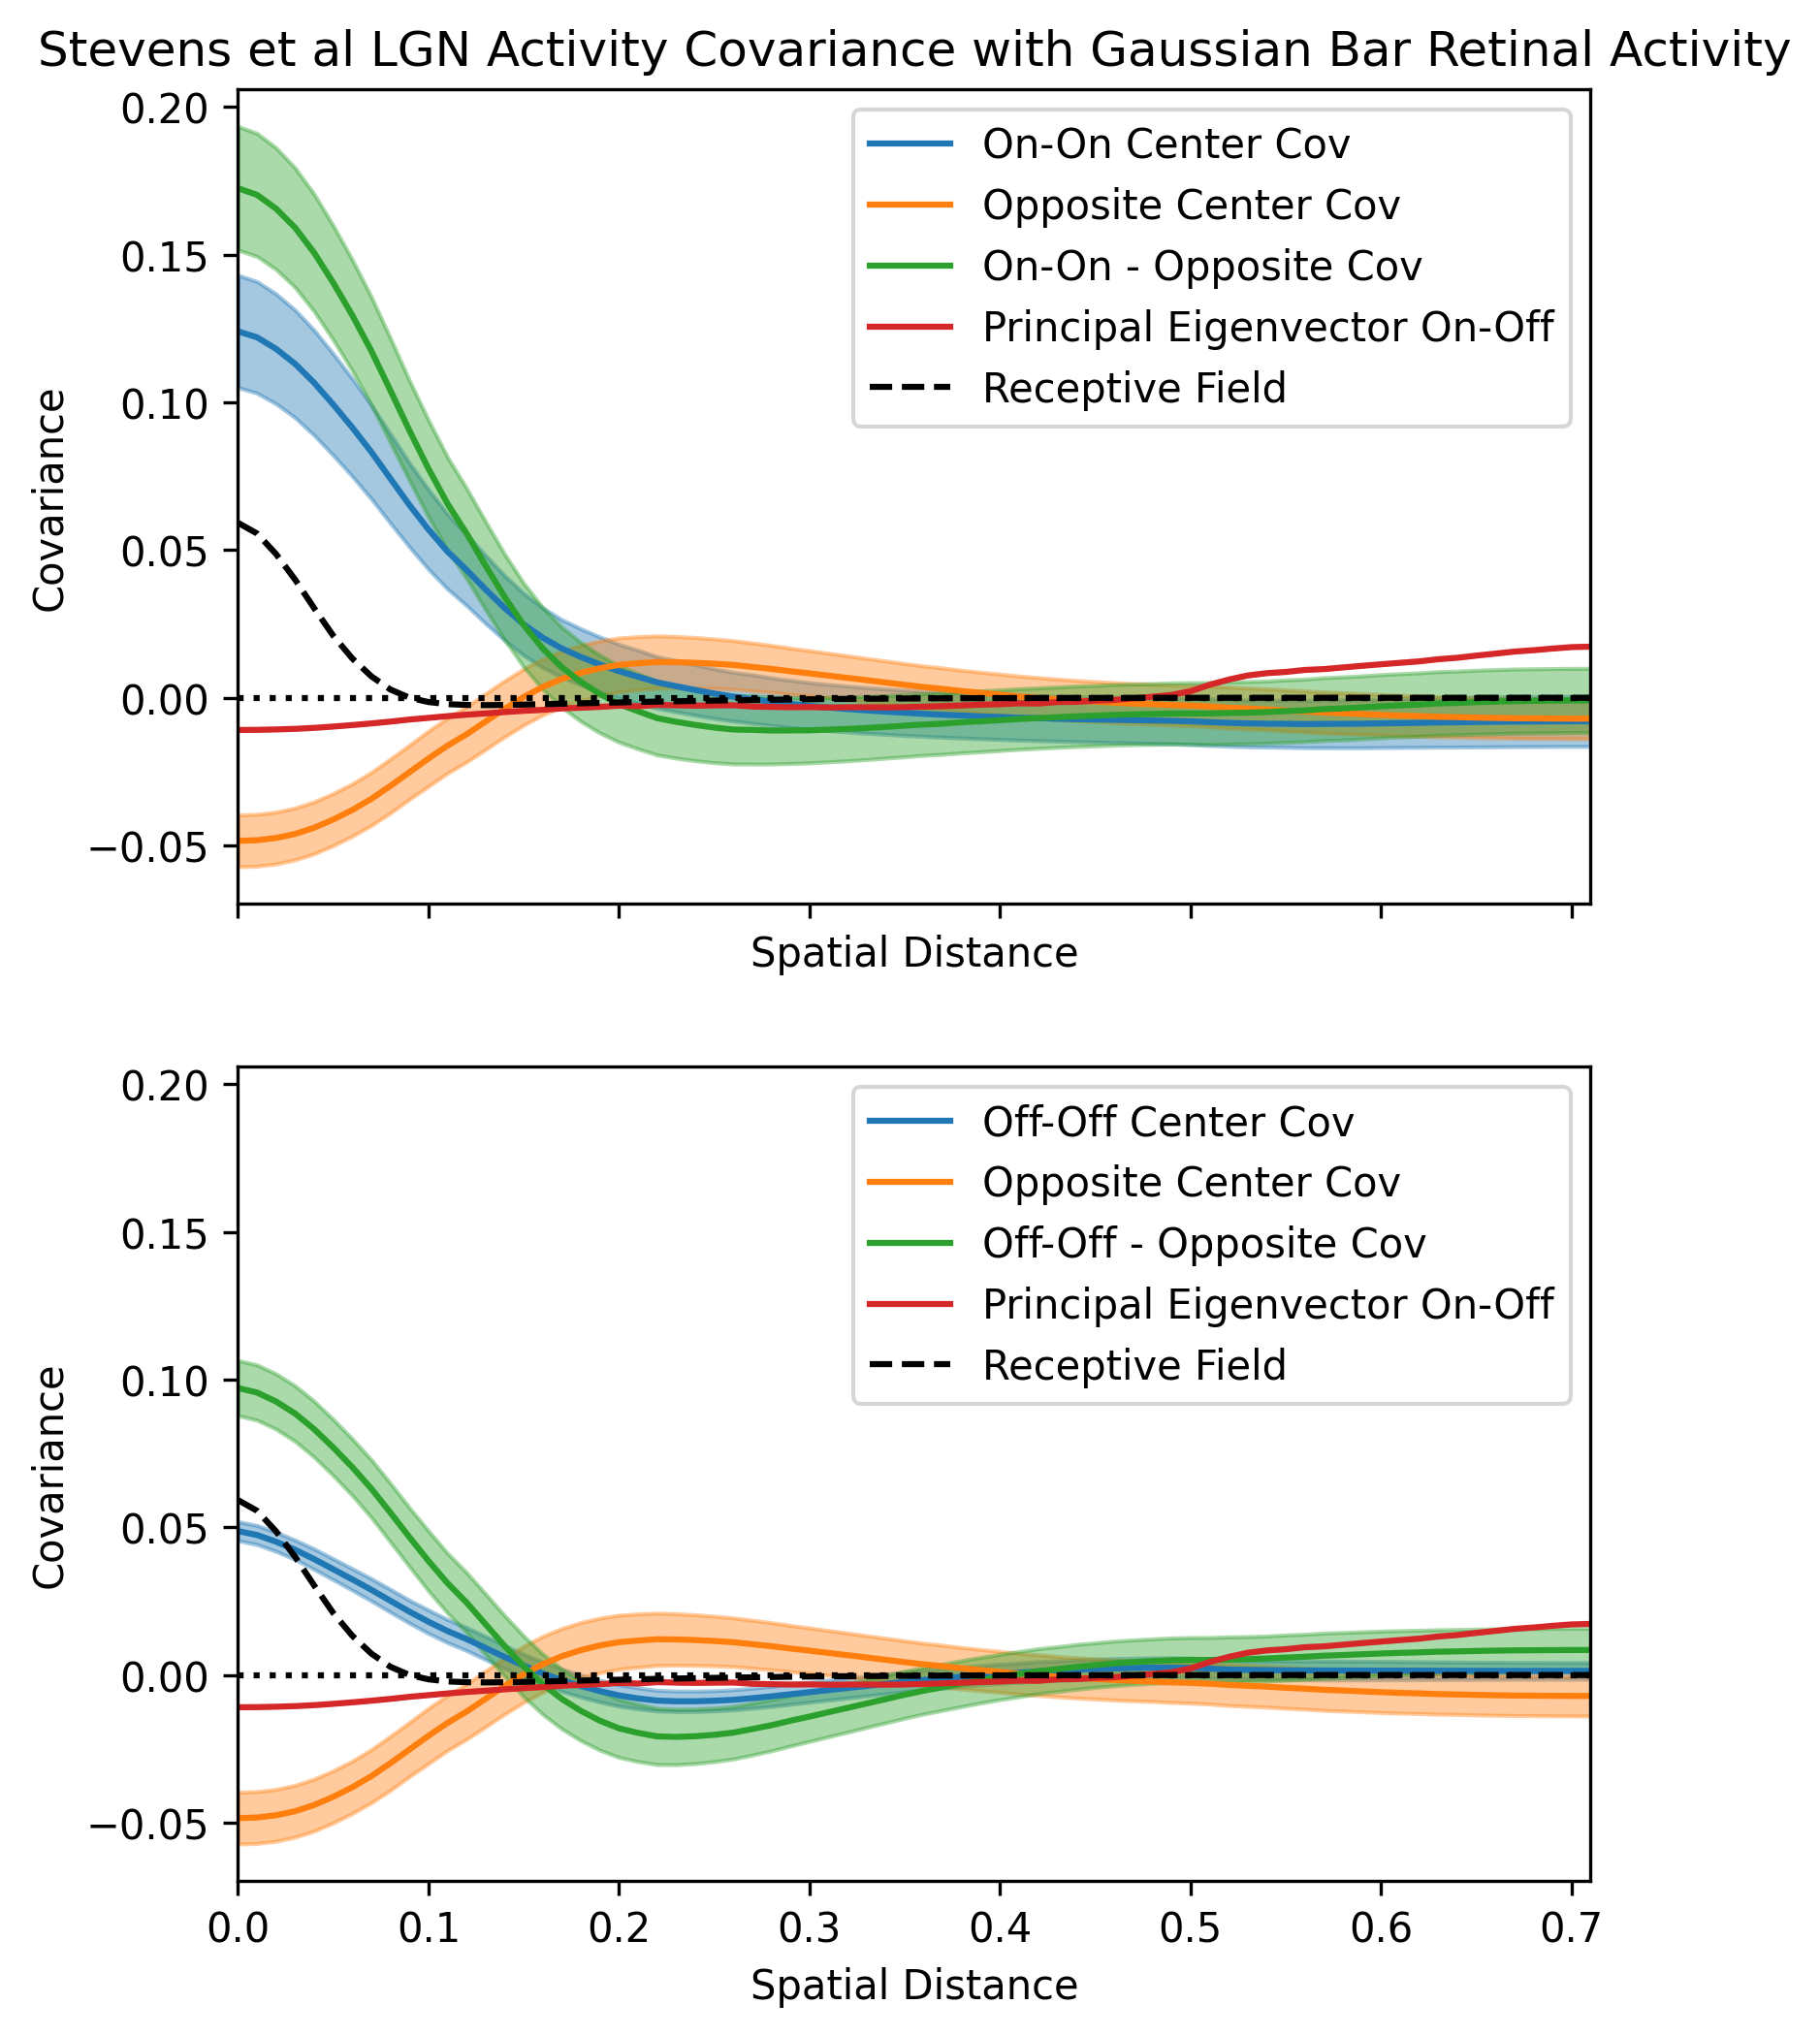

In [22]:
fig,axs = plt.subplots(2,1,figsize=(6,8),dpi=300,sharex=True,sharey=True)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0].plot(dists,gaus_SN_cov,c='C0',label='On-On Center Cov')
axs[0].fill_between(dists,gaus_SN_cov-gaus_SN_cov_err,gaus_SN_cov+gaus_SN_cov_err,color='C0',alpha=0.4)
axs[1].plot(dists,gaus_SF_cov,c='C0',label='Off-Off Center Cov')
axs[1].fill_between(dists,gaus_SF_cov-gaus_SF_cov_err,gaus_SF_cov+gaus_SF_cov_err,color='C0',alpha=0.4)
axs[0].plot(dists,gaus_D_cov,c='C1',label='Opposite Center Cov')
axs[0].fill_between(dists,gaus_D_cov-gaus_D_cov_err,gaus_D_cov+gaus_D_cov_err,color='C1',alpha=0.4)
axs[1].plot(dists,gaus_D_cov,c='C1',label='Opposite Center Cov')
axs[1].fill_between(dists,gaus_D_cov-gaus_D_cov_err,gaus_D_cov+gaus_D_cov_err,color='C1',alpha=0.4)
axs[0].plot(dists,gaus_SN_cov-gaus_D_cov,c='C2',label='On-On - Opposite Cov')
axs[0].fill_between(dists,gaus_SN_cov-gaus_D_cov-np.sqrt(gaus_SN_cov_err**2+gaus_D_cov_err**2),
                 gaus_SN_cov-gaus_D_cov+np.sqrt(gaus_SN_cov_err**2+gaus_D_cov_err**2),color='C2',alpha=0.4)
axs[1].plot(dists,gaus_SF_cov-gaus_D_cov,c='C2',label='Off-Off - Opposite Cov')
axs[1].fill_between(dists,gaus_SF_cov-gaus_D_cov-np.sqrt(gaus_SF_cov_err**2+gaus_D_cov_err**2),
                 gaus_SF_cov-gaus_D_cov+np.sqrt(gaus_SF_cov_err**2+gaus_D_cov_err**2),color='C2',alpha=0.4)
axs[0].plot(dists,gaus_evec[0],c='C3',label='Principal Eigenvector On-Off')
axs[0].fill_between(dists,gaus_evec[0]-gaus_evec_err[0],gaus_evec[0]+gaus_evec_err[0],color='C3',alpha=0.4)
axs[1].plot(dists,gaus_evec[0],c='C3',label='Principal Eigenvector On-Off')
axs[1].fill_between(dists,gaus_evec[0]-gaus_evec_err[0],gaus_evec[0]+gaus_evec_err[0],color='C3',alpha=0.4)

for i in range(2):
    axs[i].plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
    axs[i].axhline(0,c='k',ls=':')
    
    axs[i].legend()
    
    axs[i].set_xlim(dists[0],dists[-1])
    
    axs[i].set_xlabel('Spatial Distance')
    axs[i].set_ylabel('Covariance')
    
axs[0].set_title('Stevens et al LGN Activity Covariance with Gaussian Bar Retinal Activity')

Text(0.5, 1.0, 'Stevens et al LGN Activity Covariance with Dipolar Gaussian Bars Retinal Activity')

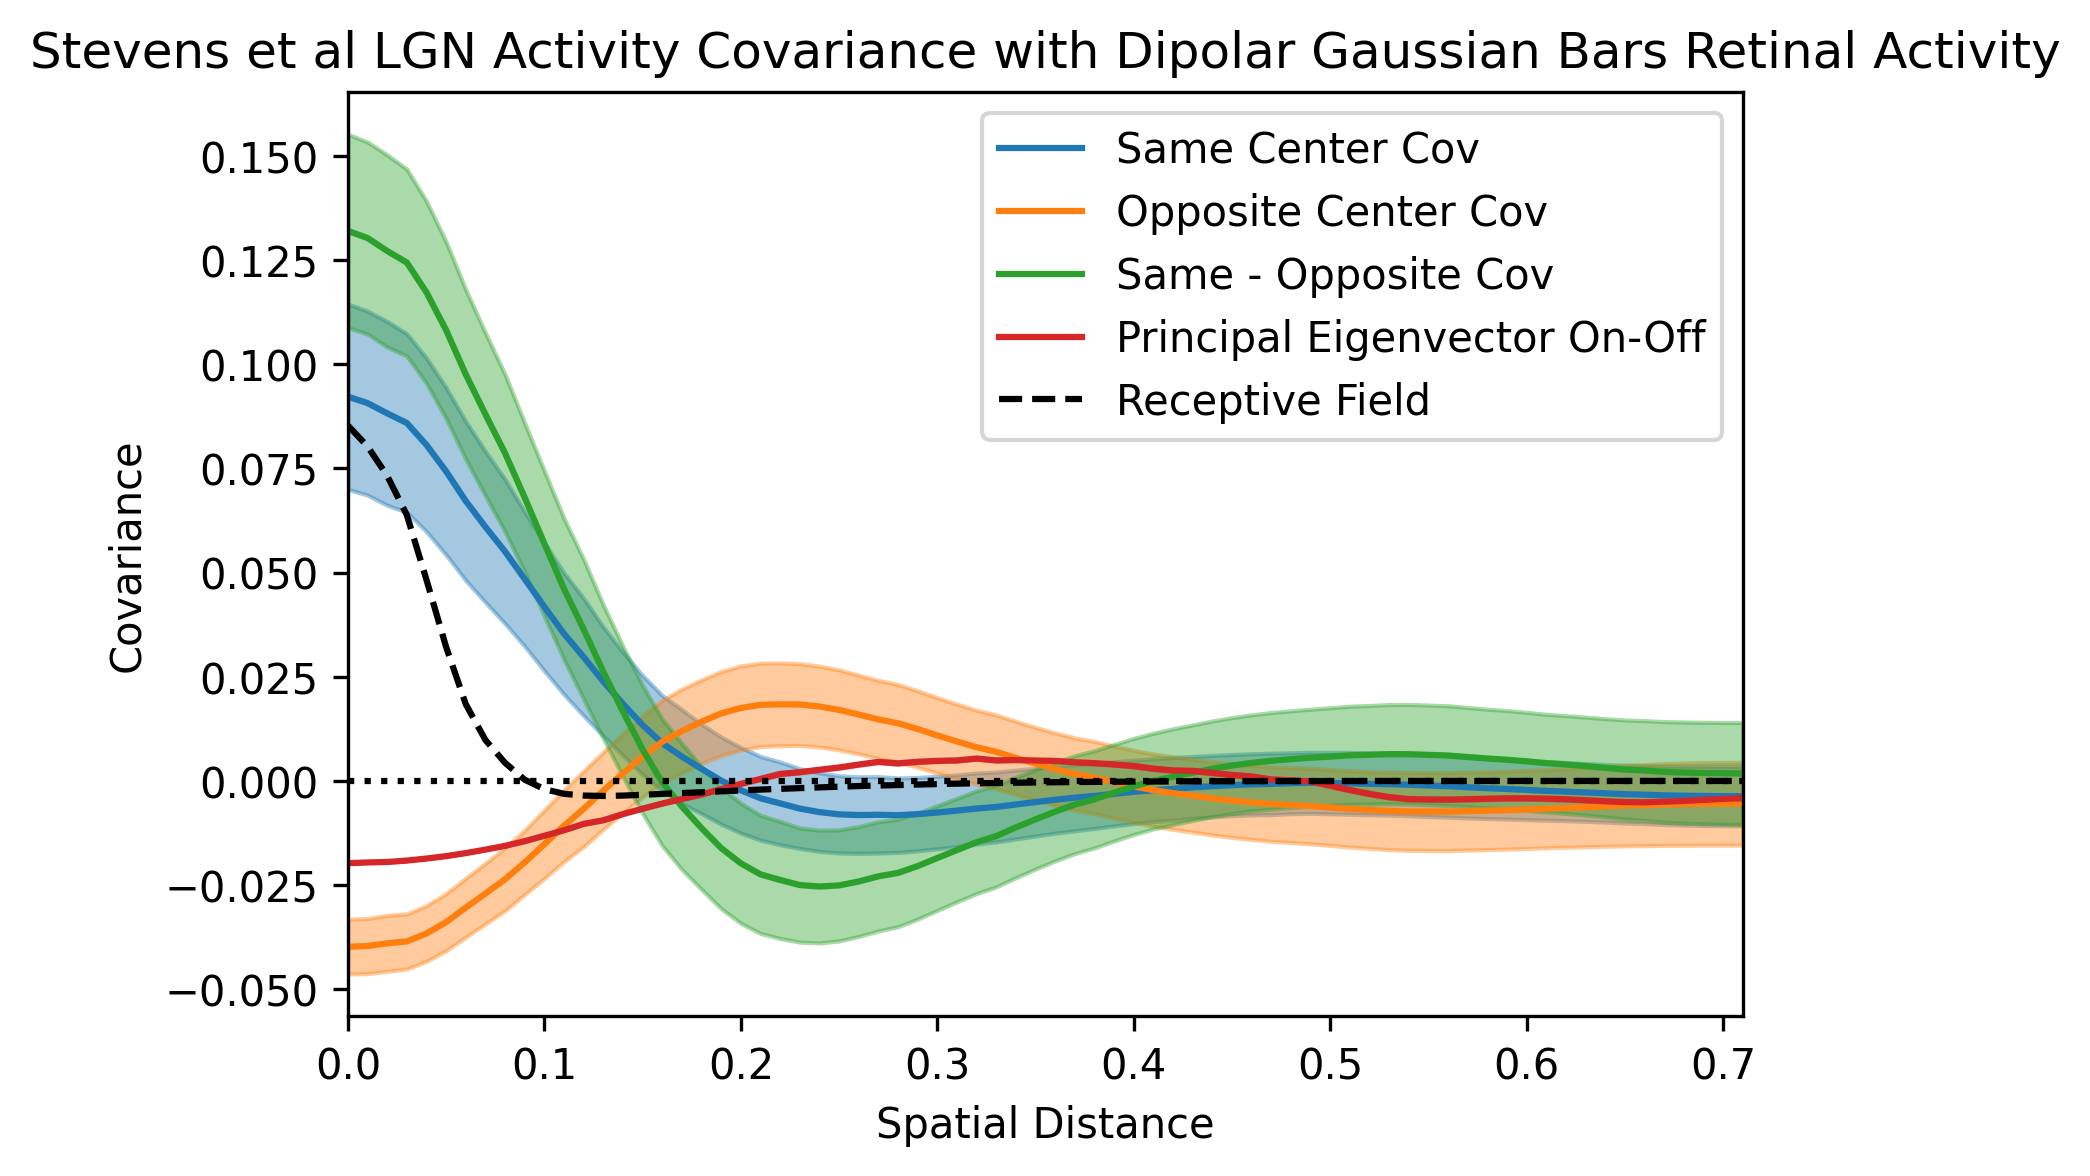

In [49]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,dipl_S_cov,c='C0',label='Same Center Cov')
axs.fill_between(dists,dipl_S_cov-dipl_S_cov_err,dipl_S_cov+dipl_S_cov_err,color='C0',alpha=0.4)
axs.plot(dists,dipl_D_cov,c='C1',label='Opposite Center Cov')
axs.fill_between(dists,dipl_D_cov-dipl_D_cov_err,dipl_D_cov+dipl_D_cov_err,color='C1',alpha=0.4)
axs.plot(dists,dipl_S_cov-dipl_D_cov,c='C2',label='Same - Opposite Cov')
axs.fill_between(dists,dipl_S_cov-dipl_D_cov-np.sqrt(dipl_S_cov_err**2+dipl_D_cov_err**2),
                 dipl_S_cov-dipl_D_cov+np.sqrt(dipl_S_cov_err**2+dipl_D_cov_err**2),color='C2',alpha=0.4)
axs.plot(dists,dipl_evec[0],c='C3',label='Principal Eigenvector On-Off')
axs.fill_between(dists,dipl_evec[0]-dipl_evec_err[0],dipl_evec[0]+dipl_evec_err[0],color='C3',alpha=0.4)
axs.plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Stevens et al LGN Activity Covariance with Dipolar Gaussian Bars Retinal Activity')

Text(0.5, 1.0, 'Stevens et al LGN Activity Covariance with Random Normal Retinal Activity')

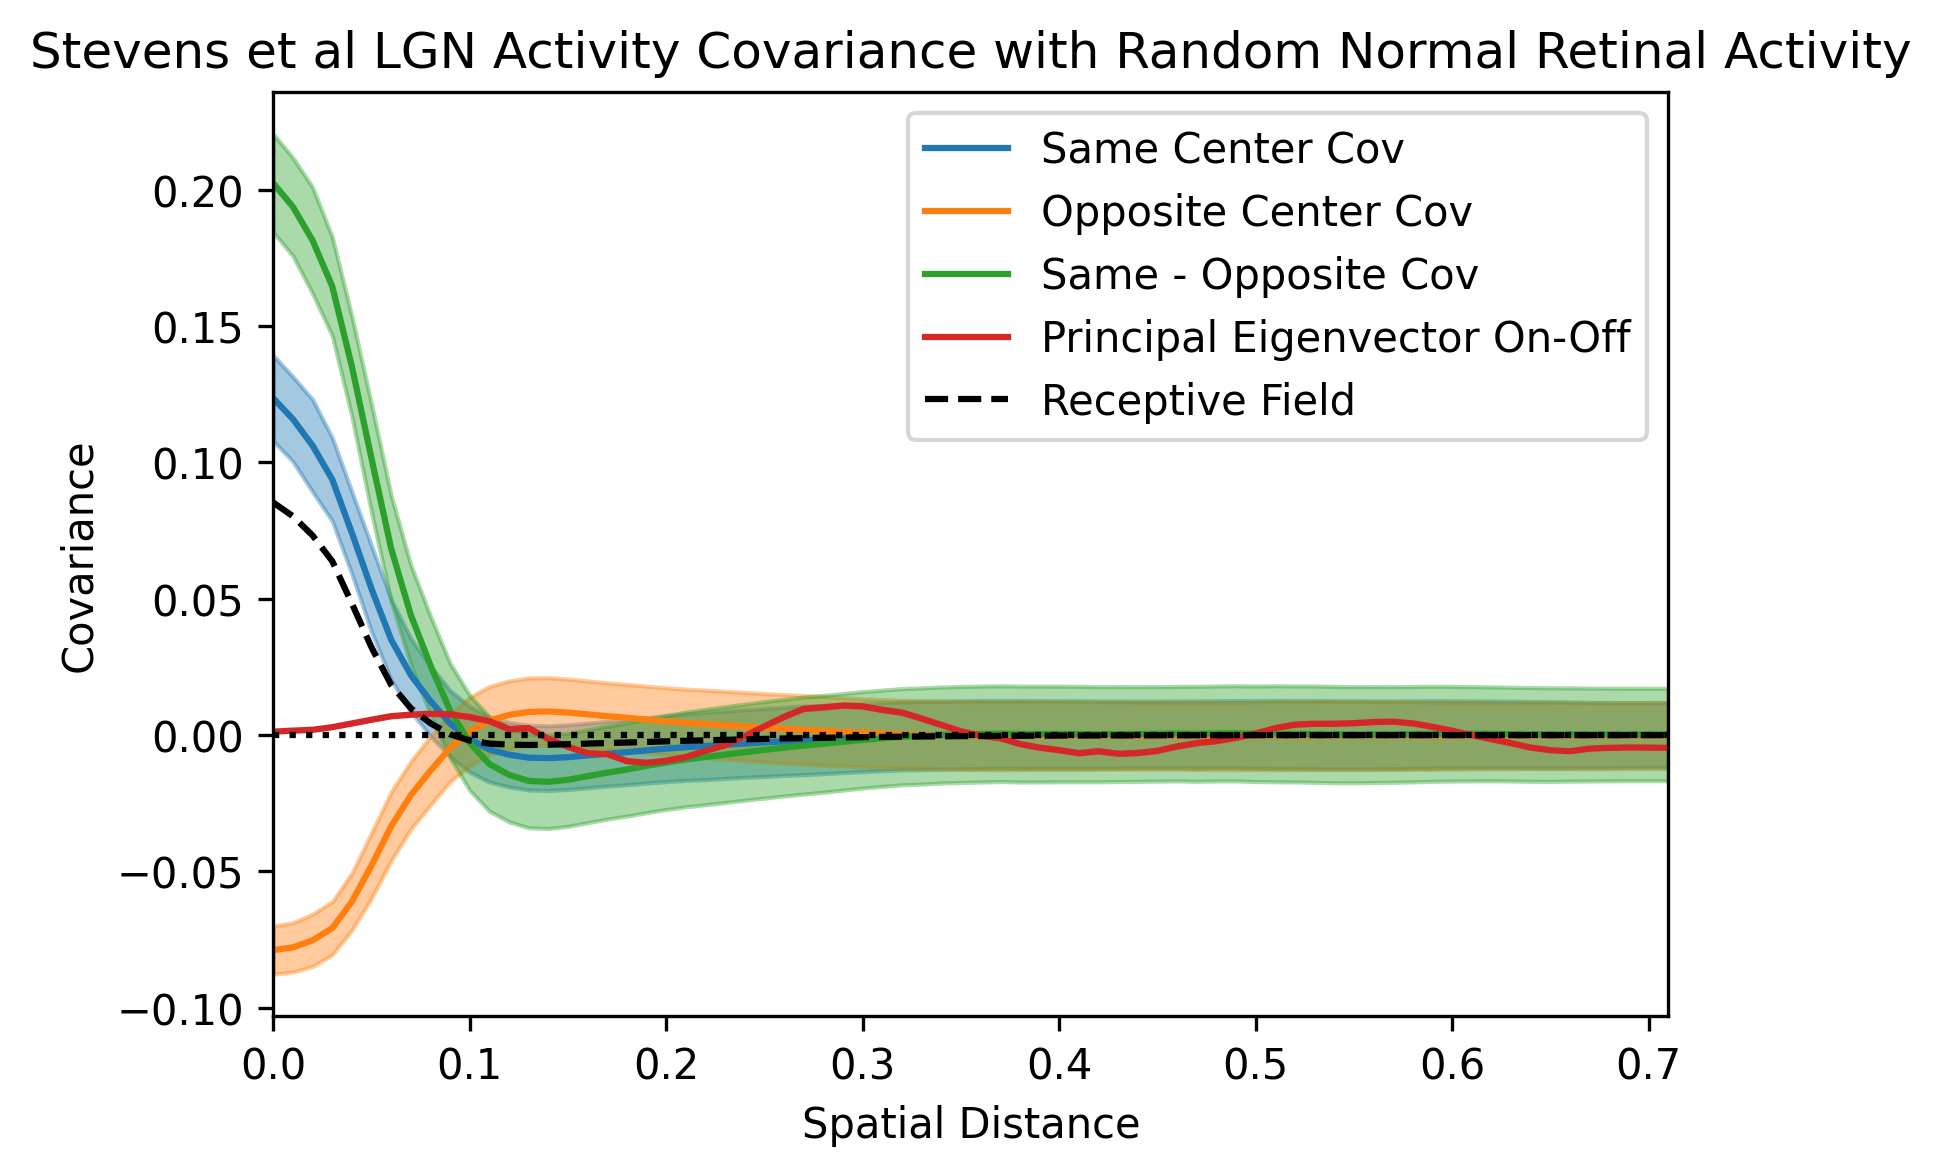

In [50]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,norm_S_cov,c='C0',label='Same Center Cov')
axs.fill_between(dists,norm_S_cov-norm_S_cov_err,norm_S_cov+norm_S_cov_err,color='C0',alpha=0.4)
axs.plot(dists,norm_D_cov,c='C1',label='Opposite Center Cov')
axs.fill_between(dists,norm_D_cov-norm_D_cov_err,norm_D_cov+norm_D_cov_err,color='C1',alpha=0.4)
axs.plot(dists,norm_S_cov-norm_D_cov,c='C2',label='Same - Opposite Cov')
axs.fill_between(dists,norm_S_cov-norm_D_cov-np.sqrt(norm_S_cov_err**2+norm_D_cov_err**2),
                 norm_S_cov-norm_D_cov+np.sqrt(norm_S_cov_err**2+norm_D_cov_err**2),color='C2',alpha=0.4)
axs.plot(dists,norm_evec[0],c='C3',label='Principal Eigenvector On-Off')
axs.fill_between(dists,norm_evec[0]-norm_evec_err[0],norm_evec[0]+norm_evec_err[0],color='C3',alpha=0.4)
axs.plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Stevens et al LGN Activity Covariance with Random Normal Retinal Activity')

## Fit Difference of Gaussians to Gauss Bars Covariance

In [24]:
def diff_gauss_wbase(x,b,a1,a2,s1,s2):
    return b + a1*np.exp(-0.5*(x/s1)**2) + a2*np.exp(-0.5*(x/s2)**2)

In [25]:
SN_popt,SN_pcov = optimize.curve_fit(diff_gauss_wbase,dists,gaus_SN_cov,p0=(0,0.1,0,0.1,10))
SF_popt,SF_pcov = optimize.curve_fit(diff_gauss_wbase,dists,gaus_SF_cov,p0=(0,0.06,-0.01,0.05,0.3))
D_popt,D_pcov = optimize.curve_fit(diff_gauss_wbase,dists,gaus_D_cov,p0=(0,-0.06,0.01,0.05,0.3))
print(SN_popt)
print(SF_popt)
print(D_popt)

[-0.00834099  0.09809787  0.03235812  0.07343857  0.16119628]
[ 0.00189555  0.11992125 -0.0764389   0.10819111  0.14820545]
[-0.00673917 -0.08525667  0.0420941   0.09874045  0.21926803]


In [26]:
SN_params = {
    'sigma1':  SN_popt[3],
    'sigma2':  SN_popt[4],
    'ampl1':   SN_popt[1],
    'ampl2':   -SN_popt[2],
    'noise':   0.0,
    'profile': 'Mexican-hat',
    'nosumdiv': True,
}

SF_params = {
    'sigma1':  SF_popt[3],
    'sigma2':  SF_popt[4],
    'ampl1':   SF_popt[1],
    'ampl2':   -SF_popt[2],
    'noise':   0.0,
    'profile': 'Mexican-hat',
    'nosumdiv': True,
}

D_params = {
    'sigma1':  D_popt[3],
    'sigma2':  D_popt[4],
    'ampl1':   D_popt[1],
    'ampl2':   -D_popt[2],
    'noise':   0.0,
    'profile': 'Mexican-hat',
    'nosumdiv': True,
}

In [27]:
reload(connectivity)

SN_cov,_ = conn.create_matrix(SN_params,SN_params['profile'])
SN_cov *= N**2
SN_cov += SN_popt[0]

SF_cov,_ = conn.create_matrix(SF_params,SF_params['profile'])
SF_cov *= N**2
SF_cov += SF_popt[0]

D_cov,_ = conn.create_matrix(D_params,D_params['profile'])
D_cov *= N**2
D_cov += D_popt[0]

In [28]:
dists = np.linspace(0,0.71,72)
bin_idxs = np.digitize(ds,np.linspace(0,0.7,71)+0.005)

SN_cov_d = np.zeros(72)
SF_cov_d = np.zeros(72)
D_cov_d = np.zeros(72)

for idx in range(72):
    SN_cov_d[idx] = np.mean(SN_cov[bin_idxs == idx])
    SF_cov_d[idx] = np.mean(SF_cov[bin_idxs == idx])
    D_cov_d[idx] = np.mean(D_cov[bin_idxs == idx])

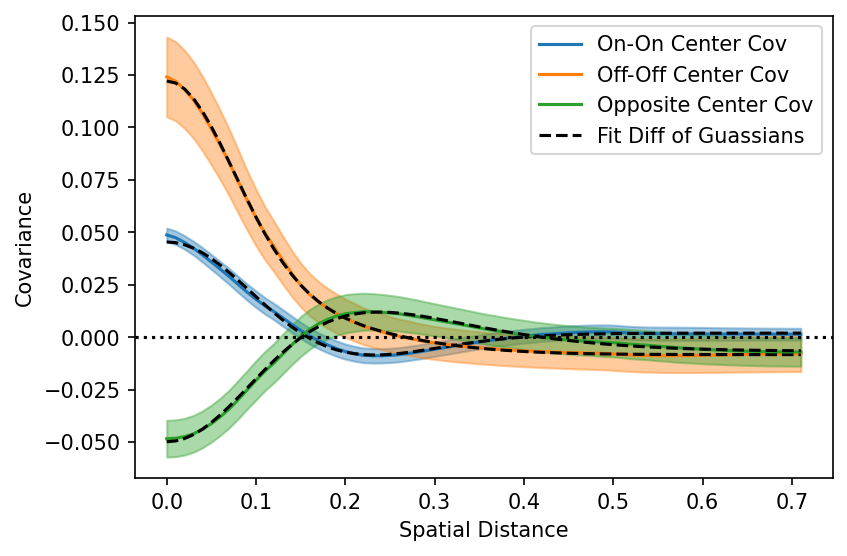

In [32]:
fig,ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

ax.plot(dists,gaus_SF_cov,c='C0',label='On-On Center Cov')
ax.fill_between(dists,gaus_SF_cov-gaus_SF_cov_err,gaus_SF_cov+gaus_SF_cov_err,color='C0',alpha=0.4)
ax.plot(dists,diff_gauss_wbase(dists,*SF_popt),'k--')#,label='Fit Diff of Guassians')
# ax.plot(dists,SF_cov_d,'k-.')#,label='Constructed Cov')

ax.plot(dists,gaus_SN_cov,c='C1',label='Off-Off Center Cov')
ax.fill_between(dists,gaus_SN_cov-gaus_SN_cov_err,gaus_SN_cov+gaus_SN_cov_err,color='C1',alpha=0.4)
ax.plot(dists,diff_gauss_wbase(dists,*SN_popt),'k--')#,label='Fit Diff of Guassians')
# ax.plot(dists,SN_cov_d,'k-.')#,label='Constructed Cov')

ax.plot(dists,gaus_D_cov,c='C2',label='Opposite Center Cov')
ax.fill_between(dists,gaus_D_cov-gaus_D_cov_err,gaus_D_cov+gaus_D_cov_err,color='C2',alpha=0.4)
ax.plot(dists,diff_gauss_wbase(dists,*D_popt),'k--',label='Fit Diff of Guassians')
# ax.plot(dists,D_cov_d,'k-.',label='Constructed Cov')

ax.legend()
ax.axhline(0,c='k',ls=':')

ax.set_xlabel('Spatial Distance')
ax.set_ylabel('Covariance')

fig.savefig('./stevens_corr.pdf')

## Generate Inputs with Same First and Second Moments as Gauss Bars

In [14]:
means = np.array([np.mean(gaus_N_act),np.mean(gaus_F_act)])
cov = np.block([[SN_cov,D_cov],
                [D_cov,SF_cov]])

In [15]:
evals,evecs = np.linalg.eigh(cov)

In [16]:
print(evals)

[-1.07397122 -1.07397122 -1.07397122 ... 57.540955   57.540955
 57.540955  ]


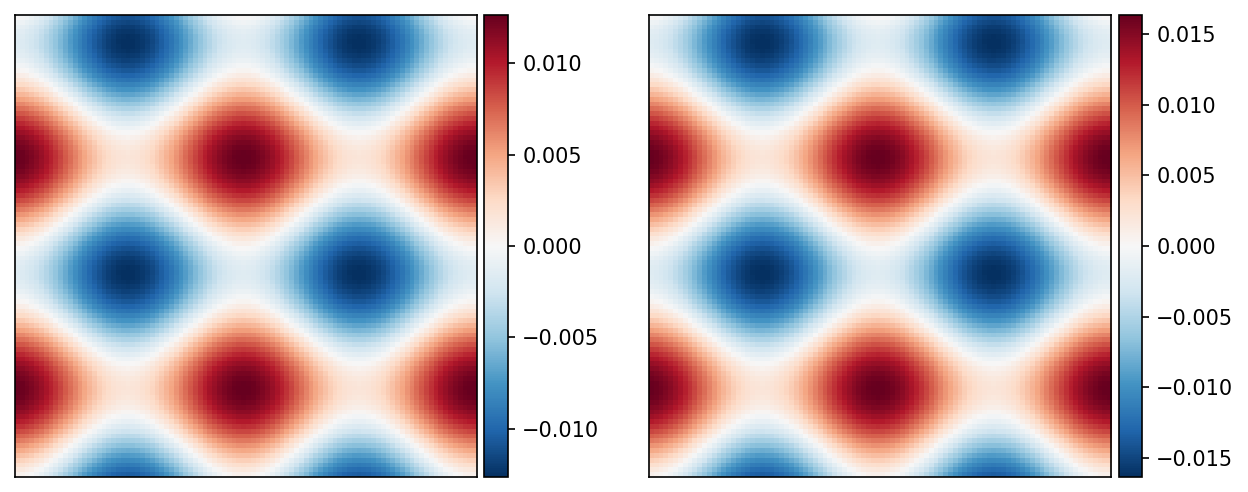

In [17]:
n_idx = 0

fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)

pf.imshowbar(fig,axs[0],evecs[:,n_idx].reshape((2,N,N))[0])
pf.imshowbar(fig,axs[1],evecs[:,n_idx].reshape((2,N,N))[1])

In [18]:
cov_L = evecs @ np.diag(np.sqrt(np.fmax(0,evals)))

In [19]:
stats_act = np.random.default_rng(0).normal(size=(2*N**2,200))
stats_act = cov_L@stats_act
stats_act = stats_act.reshape((2,N**2,200))
stats_act += means[:,None,None]
stats_N_act = stats_act[0].T
stats_F_act = stats_act[1].T
del stats_act

In [20]:
stats_full_cov = np.cov(stats_N_act.T,stats_F_act.T)
stats_NN_cov = stats_full_cov[:N**2,:N**2]
stats_NF_cov = stats_full_cov[:N**2,N**2:]
stats_FN_cov = stats_full_cov[N**2:,:N**2]
stats_FF_cov = stats_full_cov[N**2:,N**2:]

In [21]:
stats_evals,stats_evecs = sparse.linalg.eigsh(stats_full_cov,2)

In [22]:
dists = np.linspace(0,0.71,72)
bin_idxs_4d = np.digitize(ds,np.linspace(0,0.7,71)+0.005)
bin_idxs_2d = np.digitize(ds[0,:],np.linspace(0,0.7,71)+0.005)

stats_SN_cov = np.zeros(72)
stats_SN_cov_err = np.zeros(72)
stats_SF_cov = np.zeros(72)
stats_SF_cov_err = np.zeros(72)
stats_D_cov = np.zeros(72)
stats_D_cov_err = np.zeros(72)
stats_evec = np.zeros((2,72))
stats_evec_err = np.zeros((2,72))

for idx in range(72):
    stats_SN_cov[idx] = np.mean(stats_NN_cov[bin_idxs_4d == idx])
    stats_SN_cov_err[idx] = np.sqrt(np.var(stats_NN_cov[bin_idxs_4d == idx]))
    stats_SF_cov[idx] = np.mean(stats_FF_cov[bin_idxs_4d == idx])
    stats_SF_cov_err[idx] = np.sqrt(np.var(stats_FF_cov[bin_idxs_4d == idx]))
    stats_D_cov[idx] = 0.5*(np.mean(stats_NF_cov[bin_idxs_4d == idx]) +\
                           np.mean(stats_NF_cov[bin_idxs_4d == idx]))
    stats_D_cov_err[idx] = np.sqrt(np.var(stats_NF_cov[bin_idxs_4d == idx]) +\
                                  np.var(stats_NF_cov[bin_idxs_4d == idx]))
    for i in range(2):
        stats_evec[i,idx] = np.mean((stats_evecs[:N**2,-(i+1)]-stats_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])
        stats_evec_err[i,idx] = np.var((stats_evecs[:N**2,-(i+1)]-stats_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])

np.save('stats_SN_cov.npy',stats_SN_cov)
np.save('stats_SN_cov_err.npy',stats_SN_cov_err)
np.save('stats_SF_cov.npy',stats_SF_cov)
np.save('stats_SF_cov_err.npy',stats_SF_cov_err)
np.save('stats_D_cov.npy',stats_D_cov)
np.save('stats_D_cov_err.npy',stats_D_cov_err)

Text(0.5, 1.0, 'Stevens et al LGN Activity Covariance with Gauss Bar Statistics')

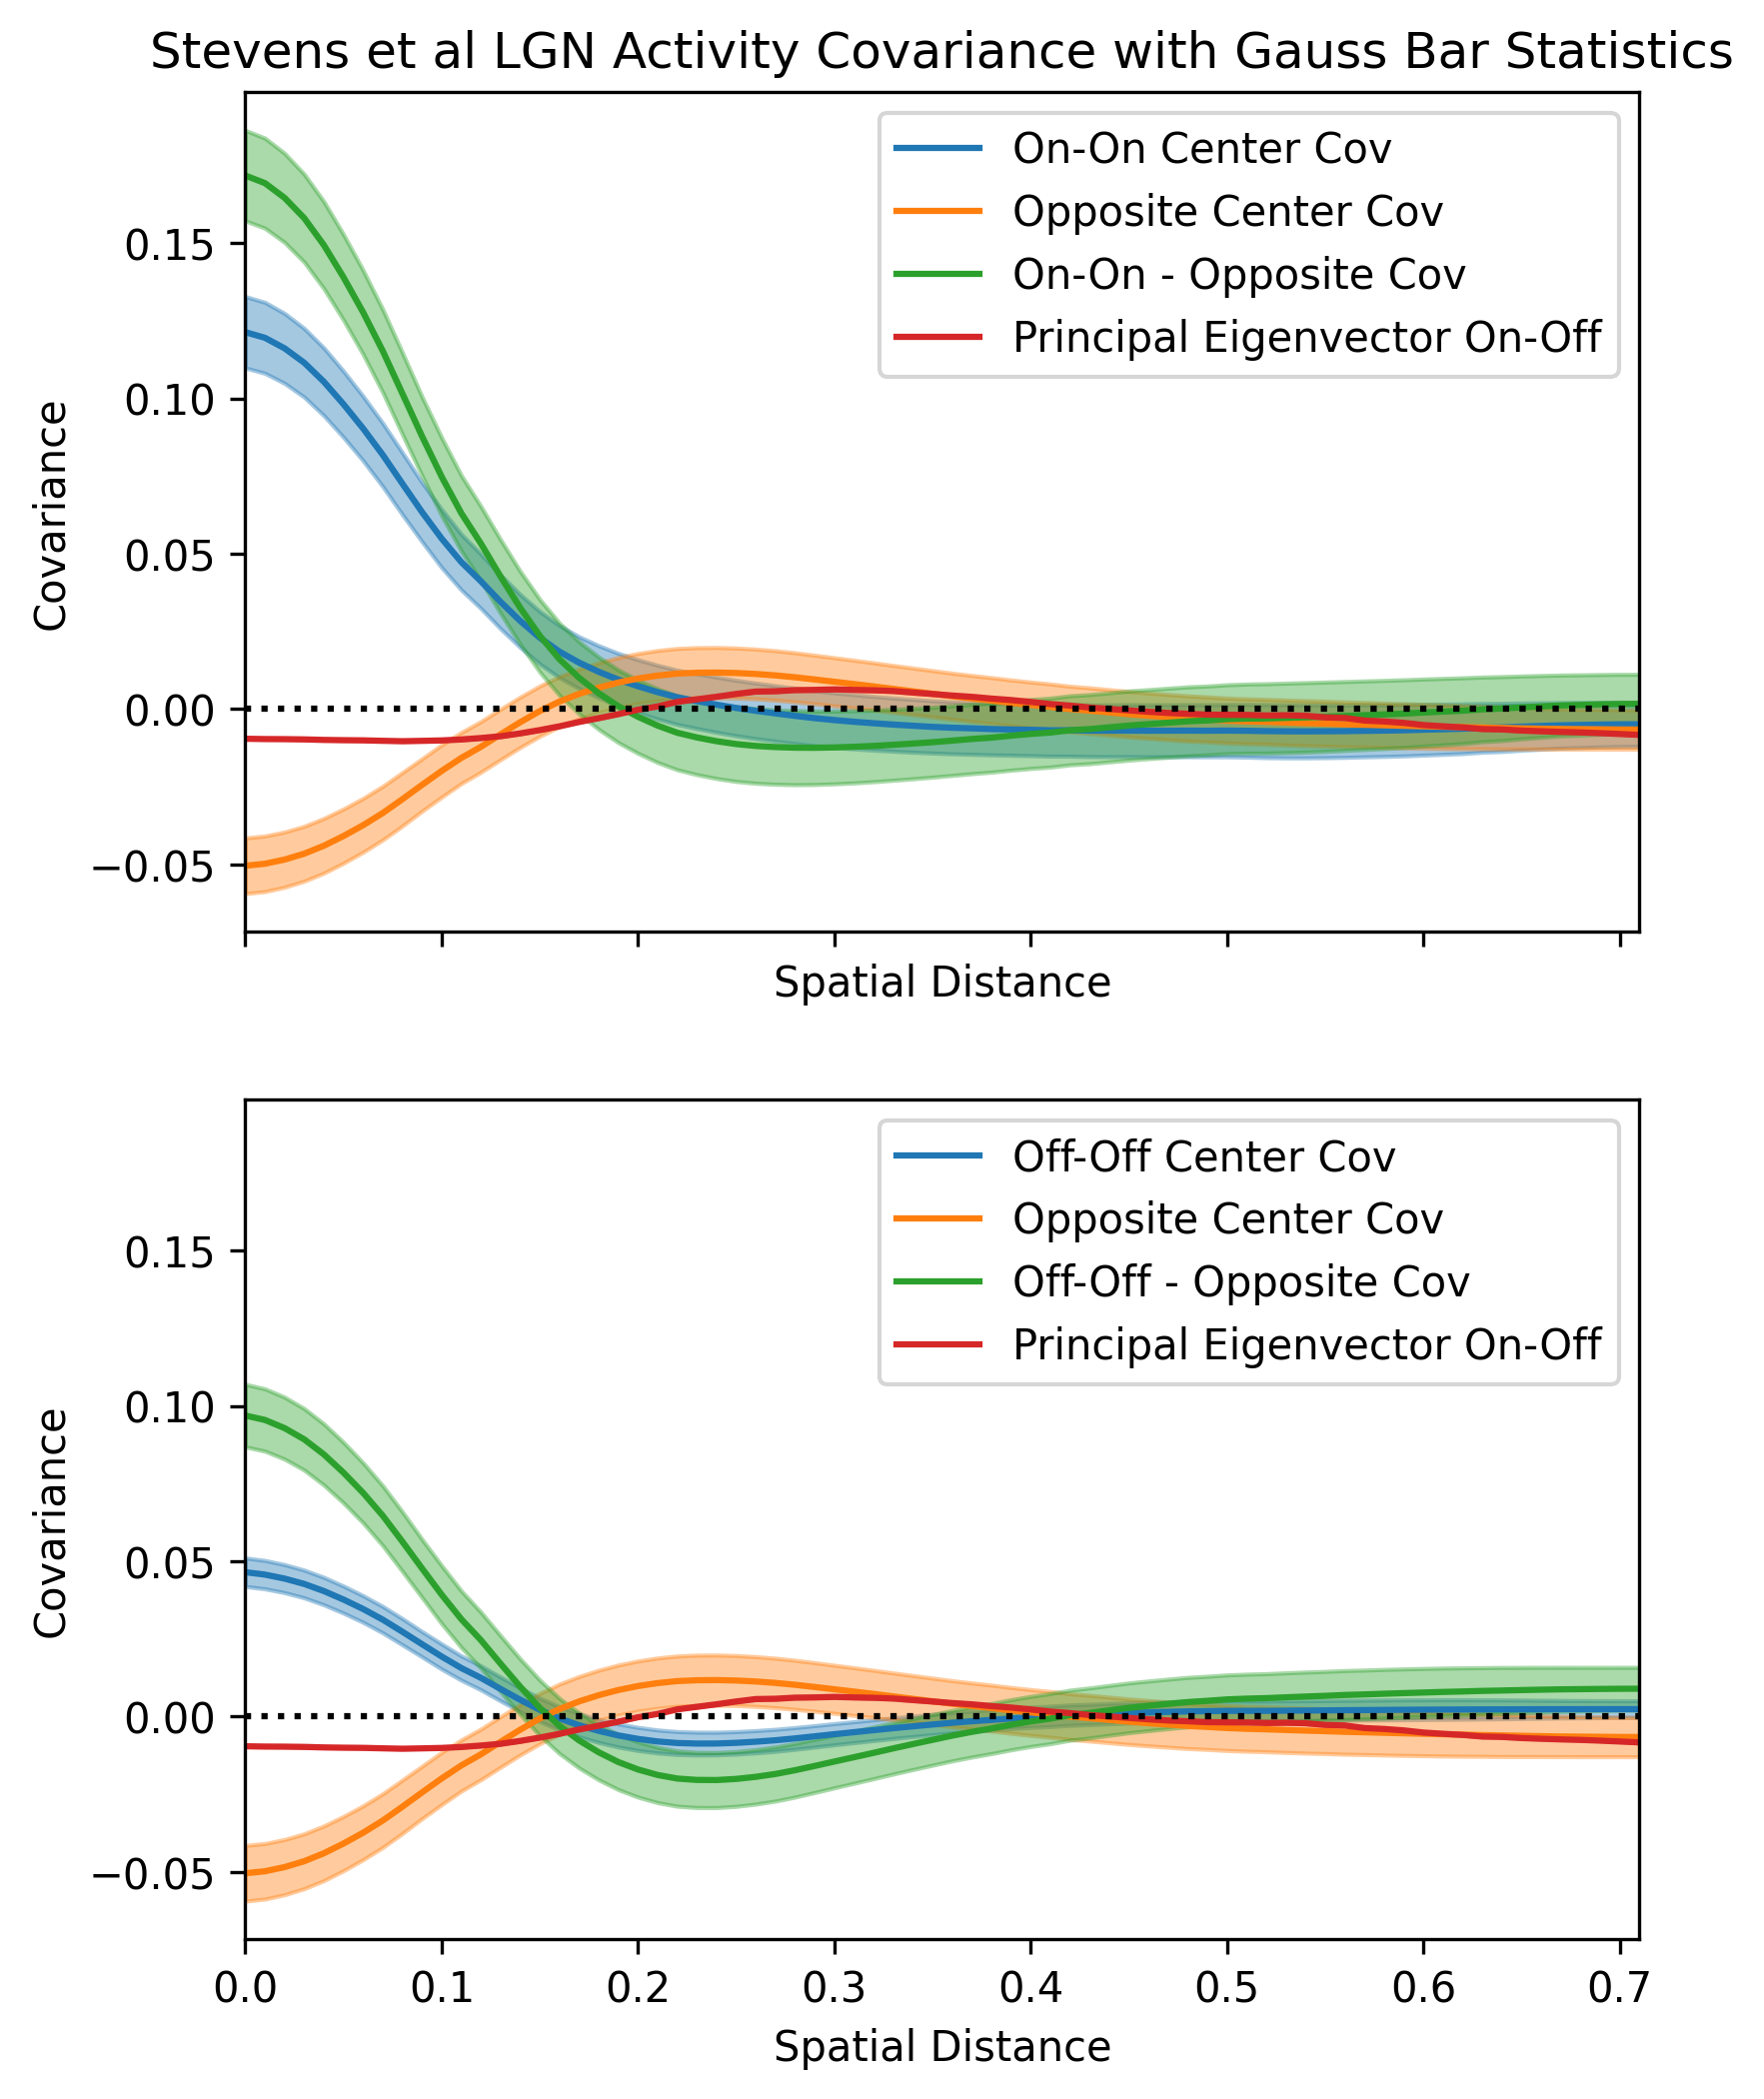

In [23]:
fig,axs = plt.subplots(2,1,figsize=(6,8),dpi=300,sharex=True,sharey=True)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0].plot(dists,stats_SN_cov,c='C0',label='On-On Center Cov')
axs[0].fill_between(dists,stats_SN_cov-stats_SN_cov_err,stats_SN_cov+stats_SN_cov_err,color='C0',alpha=0.4)
axs[1].plot(dists,stats_SF_cov,c='C0',label='Off-Off Center Cov')
axs[1].fill_between(dists,stats_SF_cov-stats_SF_cov_err,stats_SF_cov+stats_SF_cov_err,color='C0',alpha=0.4)
axs[0].plot(dists,stats_D_cov,c='C1',label='Opposite Center Cov')
axs[0].fill_between(dists,stats_D_cov-stats_D_cov_err,stats_D_cov+stats_D_cov_err,color='C1',alpha=0.4)
axs[1].plot(dists,stats_D_cov,c='C1',label='Opposite Center Cov')
axs[1].fill_between(dists,stats_D_cov-stats_D_cov_err,stats_D_cov+stats_D_cov_err,color='C1',alpha=0.4)
axs[0].plot(dists,stats_SN_cov-stats_D_cov,c='C2',label='On-On - Opposite Cov')
axs[0].fill_between(dists,stats_SN_cov-stats_D_cov-np.sqrt(stats_SN_cov_err**2+stats_D_cov_err**2),
                 stats_SN_cov-stats_D_cov+np.sqrt(stats_SN_cov_err**2+stats_D_cov_err**2),color='C2',alpha=0.4)
axs[1].plot(dists,stats_SF_cov-stats_D_cov,c='C2',label='Off-Off - Opposite Cov')
axs[1].fill_between(dists,stats_SF_cov-stats_D_cov-np.sqrt(stats_SF_cov_err**2+stats_D_cov_err**2),
                 stats_SF_cov-stats_D_cov+np.sqrt(stats_SF_cov_err**2+stats_D_cov_err**2),color='C2',alpha=0.4)
axs[0].plot(dists,stats_evec[0],c='C3',label='Principal Eigenvector On-Off')
axs[0].fill_between(dists,stats_evec[0]-stats_evec_err[0],stats_evec[0]+stats_evec_err[0],color='C3',alpha=0.4)
axs[1].plot(dists,stats_evec[0],c='C3',label='Principal Eigenvector On-Off')
axs[1].fill_between(dists,stats_evec[0]-stats_evec_err[0],stats_evec[0]+stats_evec_err[0],color='C3',alpha=0.4)

for i in range(2):
#     axs[i].plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
    axs[i].axhline(0,c='k',ls=':')
    
    axs[i].legend()
    
    axs[i].set_xlim(dists[0],dists[-1])
    
    axs[i].set_xlabel('Spatial Distance')
    axs[i].set_ylabel('Covariance')
    
axs[0].set_title('Stevens et al LGN Activity Covariance with Gauss Bar Statistics')

## Try without baselines

In [9]:
def diff_gauss(x,a1,a2,s1,s2):
    return a1*np.exp(-0.5*(x/s1)**2) + a2*np.exp(-0.5*(x/s2)**2)

In [10]:
SN_popt,SN_pcov = optimize.curve_fit(diff_gauss,dists,gaus_SN_cov,
                                     p0=(0.09809787,0.03235812,0.07343857,0.16119628))
SF_popt,SF_pcov = optimize.curve_fit(diff_gauss,dists,gaus_SF_cov,
                                     p0=(0.11992125,-0.0764389,0.10819111,0.14820545),maxfev=10000)
D_popt,D_pcov = optimize.curve_fit(diff_gauss,dists,gaus_D_cov,
                                   p0=(-0.08525667,0.0420941,0.09874045,0.21926803),maxfev=10000)
print(SN_popt)
print(SF_popt)
print(D_popt)

[0.01394644 0.10920793 0.04043319 0.08760319]
[ 8.83354282 -8.78800343  0.11943445  0.11979344]
[-12.33985123  12.29005988   0.12414359   0.12448802]


In [11]:
SN_params = {
    'sigma1':  SN_popt[2],
    'sigma2':  SN_popt[3],
    'ampl1':   SN_popt[0],
    'ampl2':   -SN_popt[1],
    'noise':   0.0,
    'profile': 'Mexican-hat',
    'nosumdiv': True,
}

SF_params = {
    'sigma1':  SF_popt[2],
    'sigma2':  SF_popt[3],
    'ampl1':   SF_popt[0],
    'ampl2':   -SF_popt[1],
    'noise':   0.0,
    'profile': 'Mexican-hat',
    'nosumdiv': True,
}

D_params = {
    'sigma1':  D_popt[2],
    'sigma2':  D_popt[3],
    'ampl1':   D_popt[0],
    'ampl2':   -D_popt[1],
    'noise':   0.0,
    'profile': 'Mexican-hat',
    'nosumdiv': True,
}

In [12]:
reload(connectivity)

SN_cov,_ = conn.create_matrix(SN_params,SN_params['profile'])
SN_cov *= N**2

SF_cov,_ = conn.create_matrix(SF_params,SF_params['profile'])
SF_cov *= N**2

D_cov,_ = conn.create_matrix(D_params,D_params['profile'])
D_cov *= N**2

In [13]:
dists = np.linspace(0,0.71,72)
bin_idxs = np.digitize(ds,np.linspace(0,0.7,71)+0.005)

SN_cov_d = np.zeros(72)
SF_cov_d = np.zeros(72) 
D_cov_d = np.zeros(72)

for idx in range(72):
    SN_cov_d[idx] = np.mean(SN_cov[bin_idxs == idx])
    SF_cov_d[idx] = np.mean(SF_cov[bin_idxs == idx])
    D_cov_d[idx] = np.mean(D_cov[bin_idxs == idx])

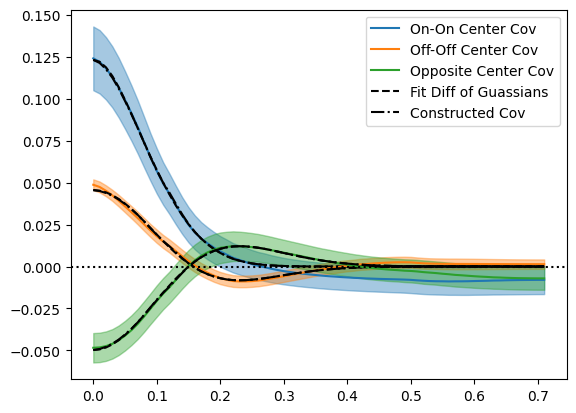

In [16]:
plt.plot(dists,gaus_SN_cov,c='C0',label='On-On Center Cov')
plt.fill_between(dists,gaus_SN_cov-gaus_SN_cov_err,gaus_SN_cov+gaus_SN_cov_err,color='C0',alpha=0.4)
plt.plot(dists,diff_gauss(dists,*SN_popt),'k--')#,label='Fit Diff of Guassians')
plt.plot(dists,SN_cov_d,'k-.')#,label='Constructed Cov')

plt.plot(dists,gaus_SF_cov,c='C1',label='Off-Off Center Cov')
plt.fill_between(dists,gaus_SF_cov-gaus_SF_cov_err,gaus_SF_cov+gaus_SF_cov_err,color='C1',alpha=0.4)
plt.plot(dists,diff_gauss(dists,*SF_popt),'k--')#,label='Fit Diff of Guassians')
plt.plot(dists,SF_cov_d,'k-.')#,label='Constructed Cov')

plt.plot(dists,gaus_D_cov,c='C2',label='Opposite Center Cov')
plt.fill_between(dists,gaus_D_cov-gaus_D_cov_err,gaus_D_cov+gaus_D_cov_err,color='C2',alpha=0.4)
plt.plot(dists,diff_gauss(dists,*D_popt),'k--',label='Fit Diff of Guassians')
plt.plot(dists,D_cov_d,'k-.',label='Constructed Cov')

plt.legend()
plt.axhline(0,c='k',ls=':')

In [15]:
means = np.array([np.mean(gaus_N_act),np.mean(gaus_F_act)])
cov = np.block([[SN_cov,D_cov],
                [D_cov,SF_cov]])

In [17]:
evals,evecs = np.linalg.eigh(cov)

In [18]:
evals

array([-1.05422332e+01, -4.25557941e-03, -4.25557941e-03, ...,
        4.30501448e+01,  4.30501448e+01,  5.43301764e+01])

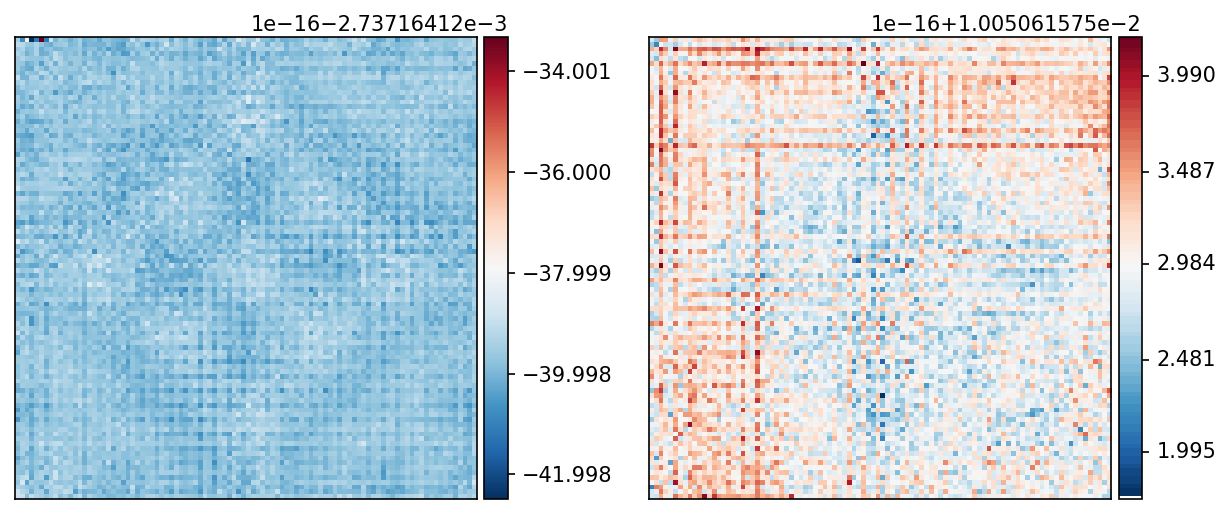

In [19]:
n_idx = 0

fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150)

pf.imshowbar(fig,axs[0],evecs[:,n_idx].reshape((2,N,N))[0])
pf.imshowbar(fig,axs[1],evecs[:,n_idx].reshape((2,N,N))[1])

In [28]:
cov_L = evecs @ np.diag(np.sqrt(np.fmax(0,evals)))

In [29]:
stats_act = np.random.default_rng(0).normal(size=(2*N**2,200))
stats_act = cov_L@stats_act
stats_act = stats_act.reshape((2,N**2,200))
stats_act += means[:,None,None]
stats_N_act = stats_act[0].T
stats_F_act = stats_act[1].T
del stats_act

In [30]:
stats_full_cov = np.cov(stats_N_act.T,stats_F_act.T)
stats_NN_cov = stats_full_cov[:N**2,:N**2]
stats_NF_cov = stats_full_cov[:N**2,N**2:]
stats_FN_cov = stats_full_cov[N**2:,:N**2]
stats_FF_cov = stats_full_cov[N**2:,N**2:]

In [31]:
stats_evals,stats_evecs = sparse.linalg.eigsh(stats_full_cov,2)

In [32]:
dists = np.linspace(0,0.71,72)
bin_idxs_4d = np.digitize(ds,np.linspace(0,0.7,71)+0.005)
bin_idxs_2d = np.digitize(ds[0,:],np.linspace(0,0.7,71)+0.005)

stats_SN_cov = np.zeros(72)
stats_SN_cov_err = np.zeros(72)
stats_SF_cov = np.zeros(72)
stats_SF_cov_err = np.zeros(72)
stats_D_cov = np.zeros(72)
stats_D_cov_err = np.zeros(72)
stats_evec = np.zeros((2,72))
stats_evec_err = np.zeros((2,72))

for idx in range(72):
    stats_SN_cov[idx] = np.mean(stats_NN_cov[bin_idxs_4d == idx])
    stats_SN_cov_err[idx] = np.sqrt(np.var(stats_NN_cov[bin_idxs_4d == idx]))
    stats_SF_cov[idx] = np.mean(stats_FF_cov[bin_idxs_4d == idx])
    stats_SF_cov_err[idx] = np.sqrt(np.var(stats_FF_cov[bin_idxs_4d == idx]))
    stats_D_cov[idx] = 0.5*(np.mean(stats_NF_cov[bin_idxs_4d == idx]) +\
                           np.mean(stats_NF_cov[bin_idxs_4d == idx]))
    stats_D_cov_err[idx] = np.sqrt(np.var(stats_NF_cov[bin_idxs_4d == idx]) +\
                                  np.var(stats_NF_cov[bin_idxs_4d == idx]))
    for i in range(2):
        stats_evec[i,idx] = np.mean((stats_evecs[:N**2,-(i+1)]-stats_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])
        stats_evec_err[i,idx] = np.var((stats_evecs[:N**2,-(i+1)]-stats_evecs[N**2:,-(i+1)])[bin_idxs_2d == idx])

np.save('stats_SN_cov.npy',stats_SN_cov)
np.save('stats_SN_cov_err.npy',stats_SN_cov_err)
np.save('stats_SF_cov.npy',stats_SF_cov)
np.save('stats_SF_cov_err.npy',stats_SF_cov_err)
np.save('stats_D_cov.npy',stats_D_cov)
np.save('stats_D_cov_err.npy',stats_D_cov_err)

Text(0.5, 1.0, 'Stevens et al LGN Activity Covariance with Gauss Bar Statistics')

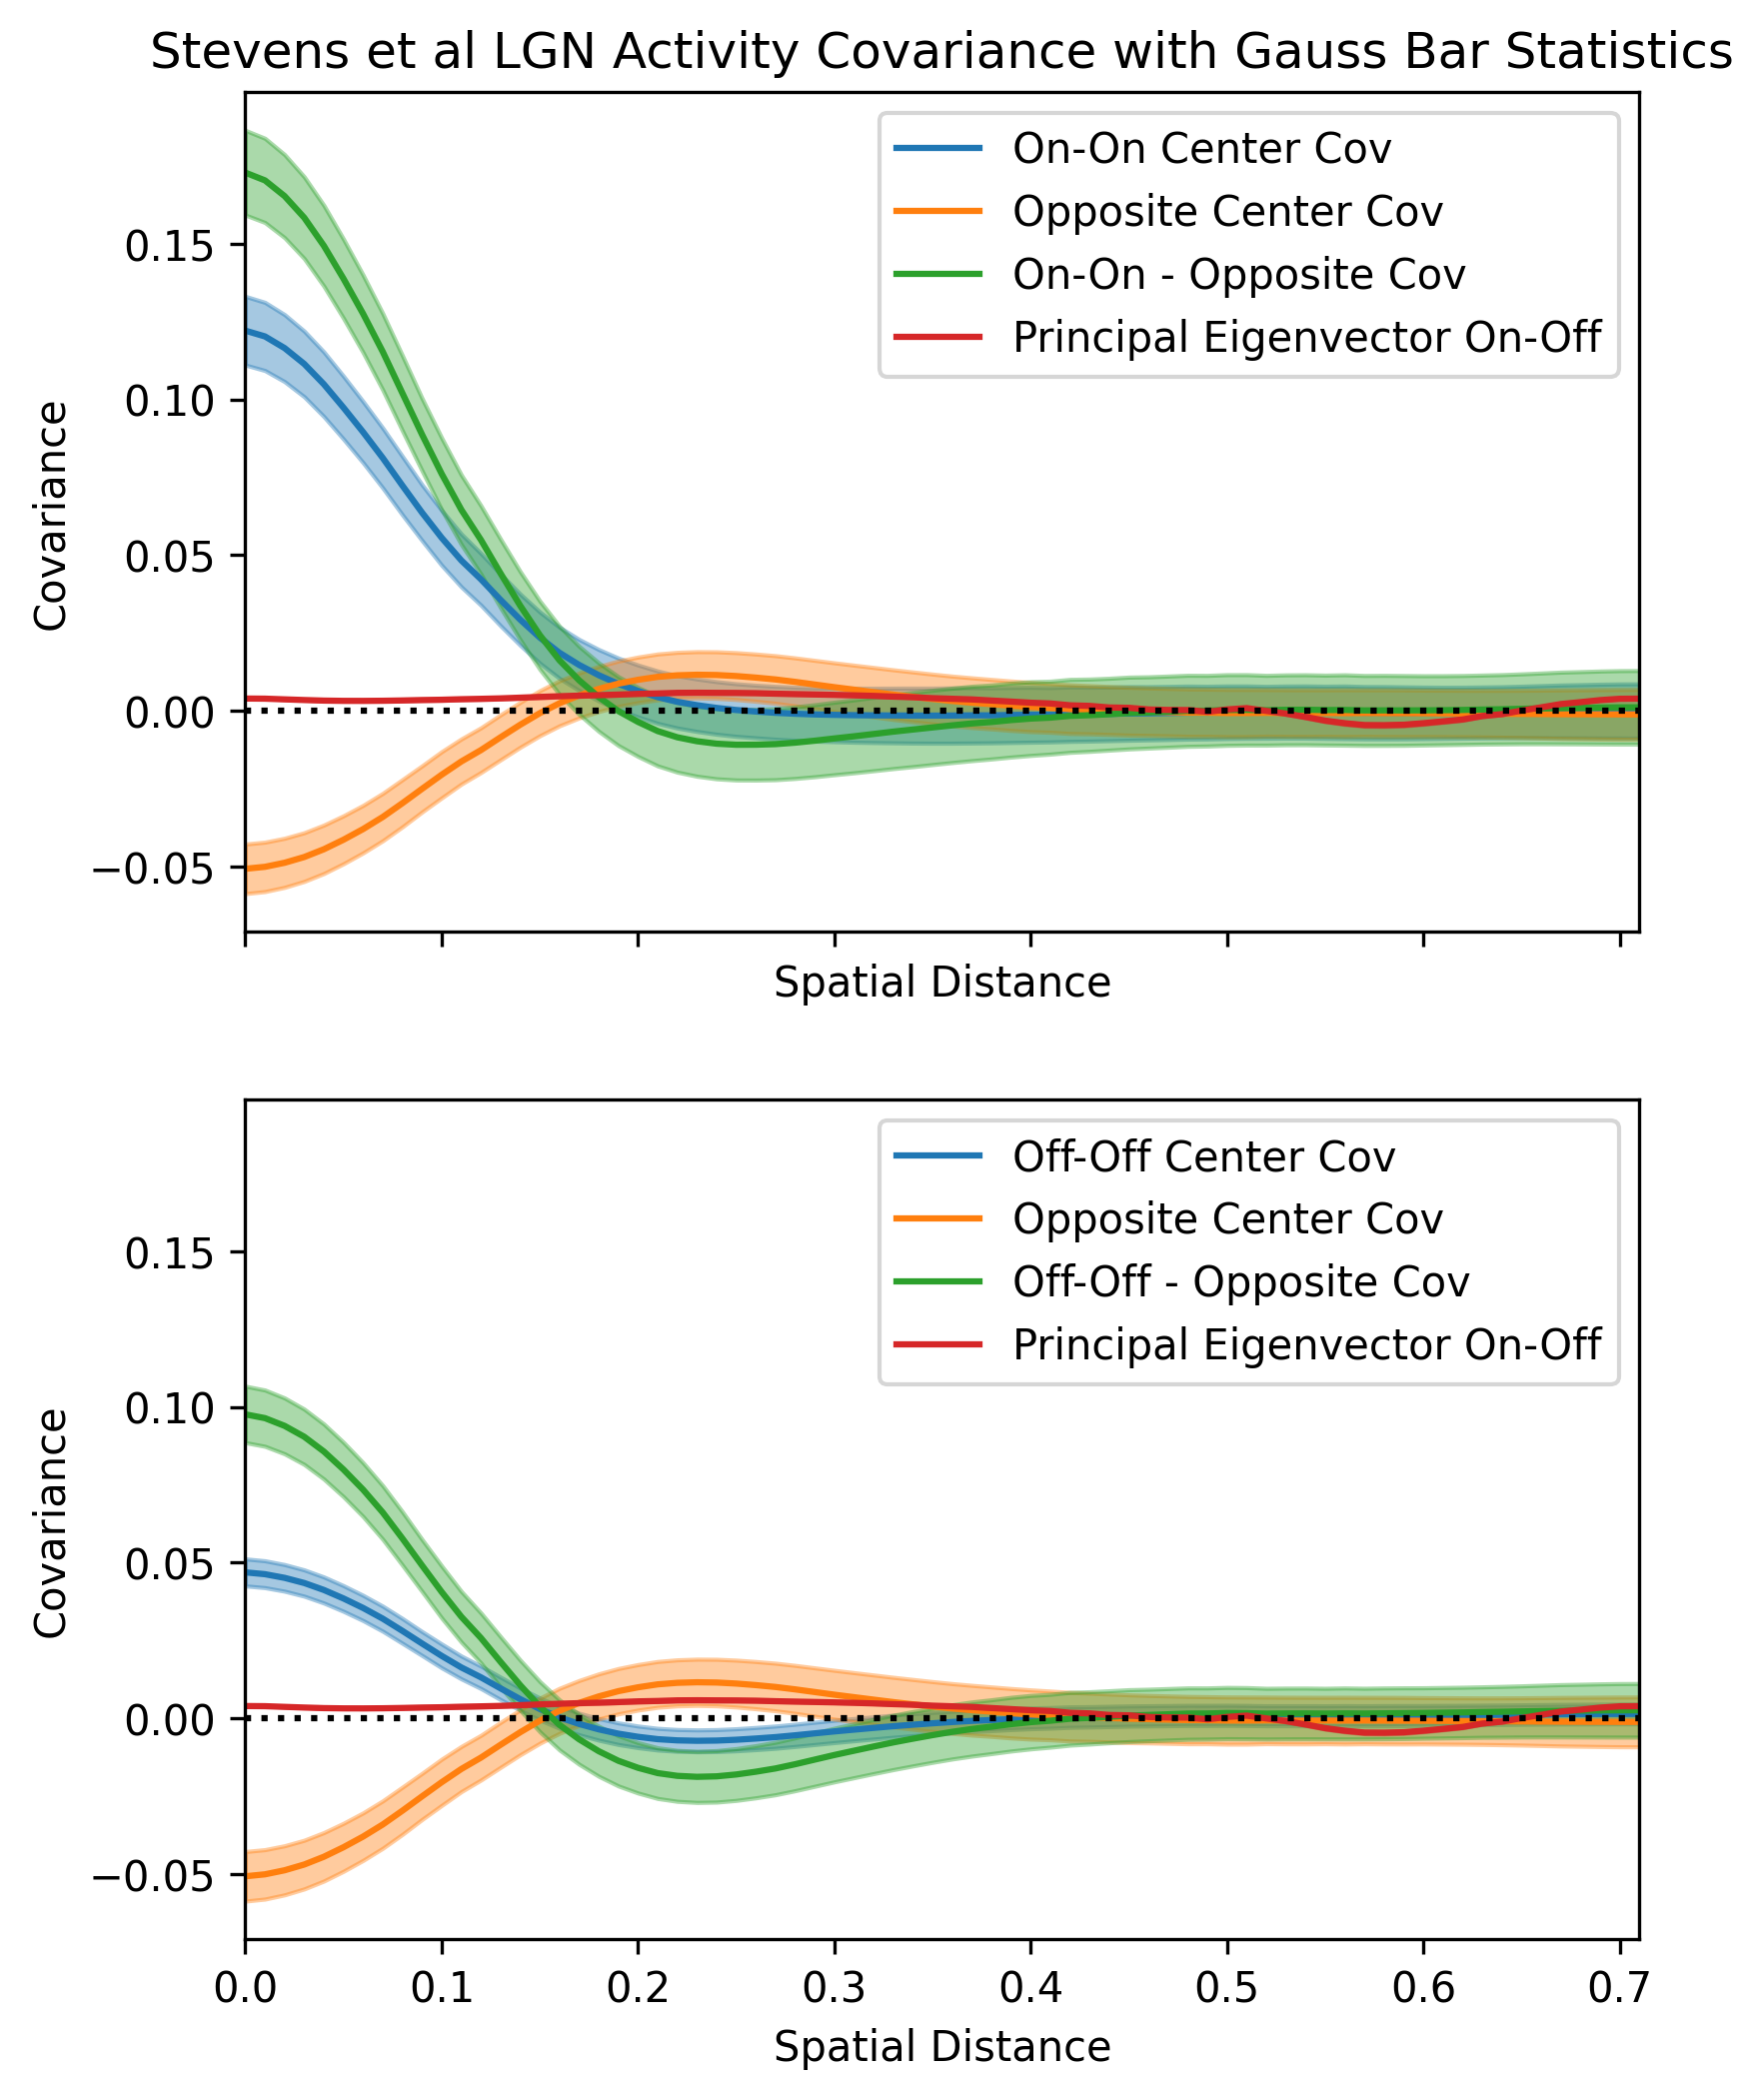

In [34]:
fig,axs = plt.subplots(2,1,figsize=(6,8),dpi=300,sharex=True,sharey=True)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0].plot(dists,stats_SN_cov,c='C0',label='On-On Center Cov')
axs[0].fill_between(dists,stats_SN_cov-stats_SN_cov_err,stats_SN_cov+stats_SN_cov_err,color='C0',alpha=0.4)
axs[1].plot(dists,stats_SF_cov,c='C0',label='Off-Off Center Cov')
axs[1].fill_between(dists,stats_SF_cov-stats_SF_cov_err,stats_SF_cov+stats_SF_cov_err,color='C0',alpha=0.4)
axs[0].plot(dists,stats_D_cov,c='C1',label='Opposite Center Cov')
axs[0].fill_between(dists,stats_D_cov-stats_D_cov_err,stats_D_cov+stats_D_cov_err,color='C1',alpha=0.4)
axs[1].plot(dists,stats_D_cov,c='C1',label='Opposite Center Cov')
axs[1].fill_between(dists,stats_D_cov-stats_D_cov_err,stats_D_cov+stats_D_cov_err,color='C1',alpha=0.4)
axs[0].plot(dists,stats_SN_cov-stats_D_cov,c='C2',label='On-On - Opposite Cov')
axs[0].fill_between(dists,stats_SN_cov-stats_D_cov-np.sqrt(stats_SN_cov_err**2+stats_D_cov_err**2),
                 stats_SN_cov-stats_D_cov+np.sqrt(stats_SN_cov_err**2+stats_D_cov_err**2),color='C2',alpha=0.4)
axs[1].plot(dists,stats_SF_cov-stats_D_cov,c='C2',label='Off-Off - Opposite Cov')
axs[1].fill_between(dists,stats_SF_cov-stats_D_cov-np.sqrt(stats_SF_cov_err**2+stats_D_cov_err**2),
                 stats_SF_cov-stats_D_cov+np.sqrt(stats_SF_cov_err**2+stats_D_cov_err**2),color='C2',alpha=0.4)
axs[0].plot(dists,stats_evec[0],c='C3',label='Principal Eigenvector On-Off')
axs[0].fill_between(dists,stats_evec[0]-stats_evec_err[0],stats_evec[0]+stats_evec_err[0],color='C3',alpha=0.4)
axs[1].plot(dists,stats_evec[0],c='C3',label='Principal Eigenvector On-Off')
axs[1].fill_between(dists,stats_evec[0]-stats_evec_err[0],stats_evec[0]+stats_evec_err[0],color='C3',alpha=0.4)

for i in range(2):
#     axs[i].plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
    axs[i].axhline(0,c='k',ls=':')
    
    axs[i].legend()
    
    axs[i].set_xlim(dists[0],dists[-1])
    
    axs[i].set_xlabel('Spatial Distance')
    axs[i].set_ylabel('Covariance')
    
axs[0].set_title('Stevens et al LGN Activity Covariance with Gauss Bar Statistics')

## Generate Diluted Inputs with Same First and Second Moments as Gauss Bars

In [ ]:
reload(connectivity)

SN_cov,_ = connectivity.Connectivity((N,N),(N,N),0).create_matrix(SN_params,SN_params['profile'])
SN_cov *= N**2
SN_cov += SN_popt[0]

SF_cov,_ = connectivity.Connectivity((N,N),(N,N),0).create_matrix(SF_params,SF_params['profile'])
SF_cov *= N**2
SF_cov += SF_popt[0]

D_cov,_ = connectivity.Connectivity((N,N),(N,N),0).create_matrix(D_params,D_params['profile'])
D_cov *= N**2
D_cov += D_popt[0]

In [110]:
dil_p = 1-np.array([np.mean(gaus_N_act > 0),np.mean(gaus_F_act > 0)])
print(dil_p)

[0.75475694 0.24524306]


In [111]:
means = np.array([np.mean(gaus_N_act)/(1-dil_p[0]),np.mean(gaus_F_act)/(1-dil_p[1])])
dil_SN_cov = SN_cov.copy()/(1-dil_p[0])**2
dil_SF_cov = SF_cov.copy()/(1-dil_p[1])**2
dil_D_cov = D_cov.copy()/((1-dil_p[0])*(1-dil_p[1]))
np.fill_diagonal(dil_SN_cov,np.var(gaus_N_act)/(1-dil_p[0]) - dil_p[0]*np.mean(gaus_N_act)**2)
np.fill_diagonal(dil_SF_cov,np.var(gaus_F_act)/(1-dil_p[1]) - dil_p[1]*np.mean(gaus_F_act)**2)
cov = np.block([[dil_SN_cov,dil_D_cov],
                [dil_D_cov,dil_SF_cov]])
cov_L = np.linalg.cholesky(cov)

LinAlgError: Matrix is not positive definite

In [112]:
cov

array([[ 0.48425442,  2.01292444,  1.96156981, ..., -0.2495185 ,
        -0.25404025, -0.25575317],
       [ 2.01292444,  0.48425442,  2.01292444, ..., -0.24042641,
        -0.2495185 , -0.25404025],
       [ 1.96156981,  2.01292444,  0.48425442, ..., -0.22545789,
        -0.24042641, -0.2495185 ],
       ...,
       [-0.2495185 , -0.24042641, -0.22545789, ...,  0.04458392,
         0.07901571,  0.07711043],
       [-0.25404025, -0.2495185 , -0.24042641, ...,  0.07901571,
         0.04458392,  0.07901571],
       [-0.25575317, -0.25404025, -0.2495185 , ...,  0.07711043,
         0.07901571,  0.04458392]])

# Test New Functions in Inputs Class

## Bars with Gain Control

In [52]:
reload(inputs)

gcconn_params = {
    'sigma':  0.037,
    'ampl':   1.0,
    'noise':   0.0,
    'profile': 'Gaussian',
    'stevensetal': True
}

inp = inputs.Inputs_lgn((N,N),0,0,gcconn_params)

In [53]:
bar_params = {
    'simulate_activity': "dynamics_adaptive",
    'pattern_duration': 50,
    'avg_no_inp': 1,

    'expanse_time': 1,
    'input_type': "stevens_bars_rect"
}


lgn = inp.create_lgn_input(\
      bar_params,\
      bar_params['input_type'],\
      14*WRtoT,\
      expansion_timestep = 0,
      )

lgn = inp.apply_gain_control(lgn)

Text(0.5, 1.0, 'Off Layer Activation with Gain Control')

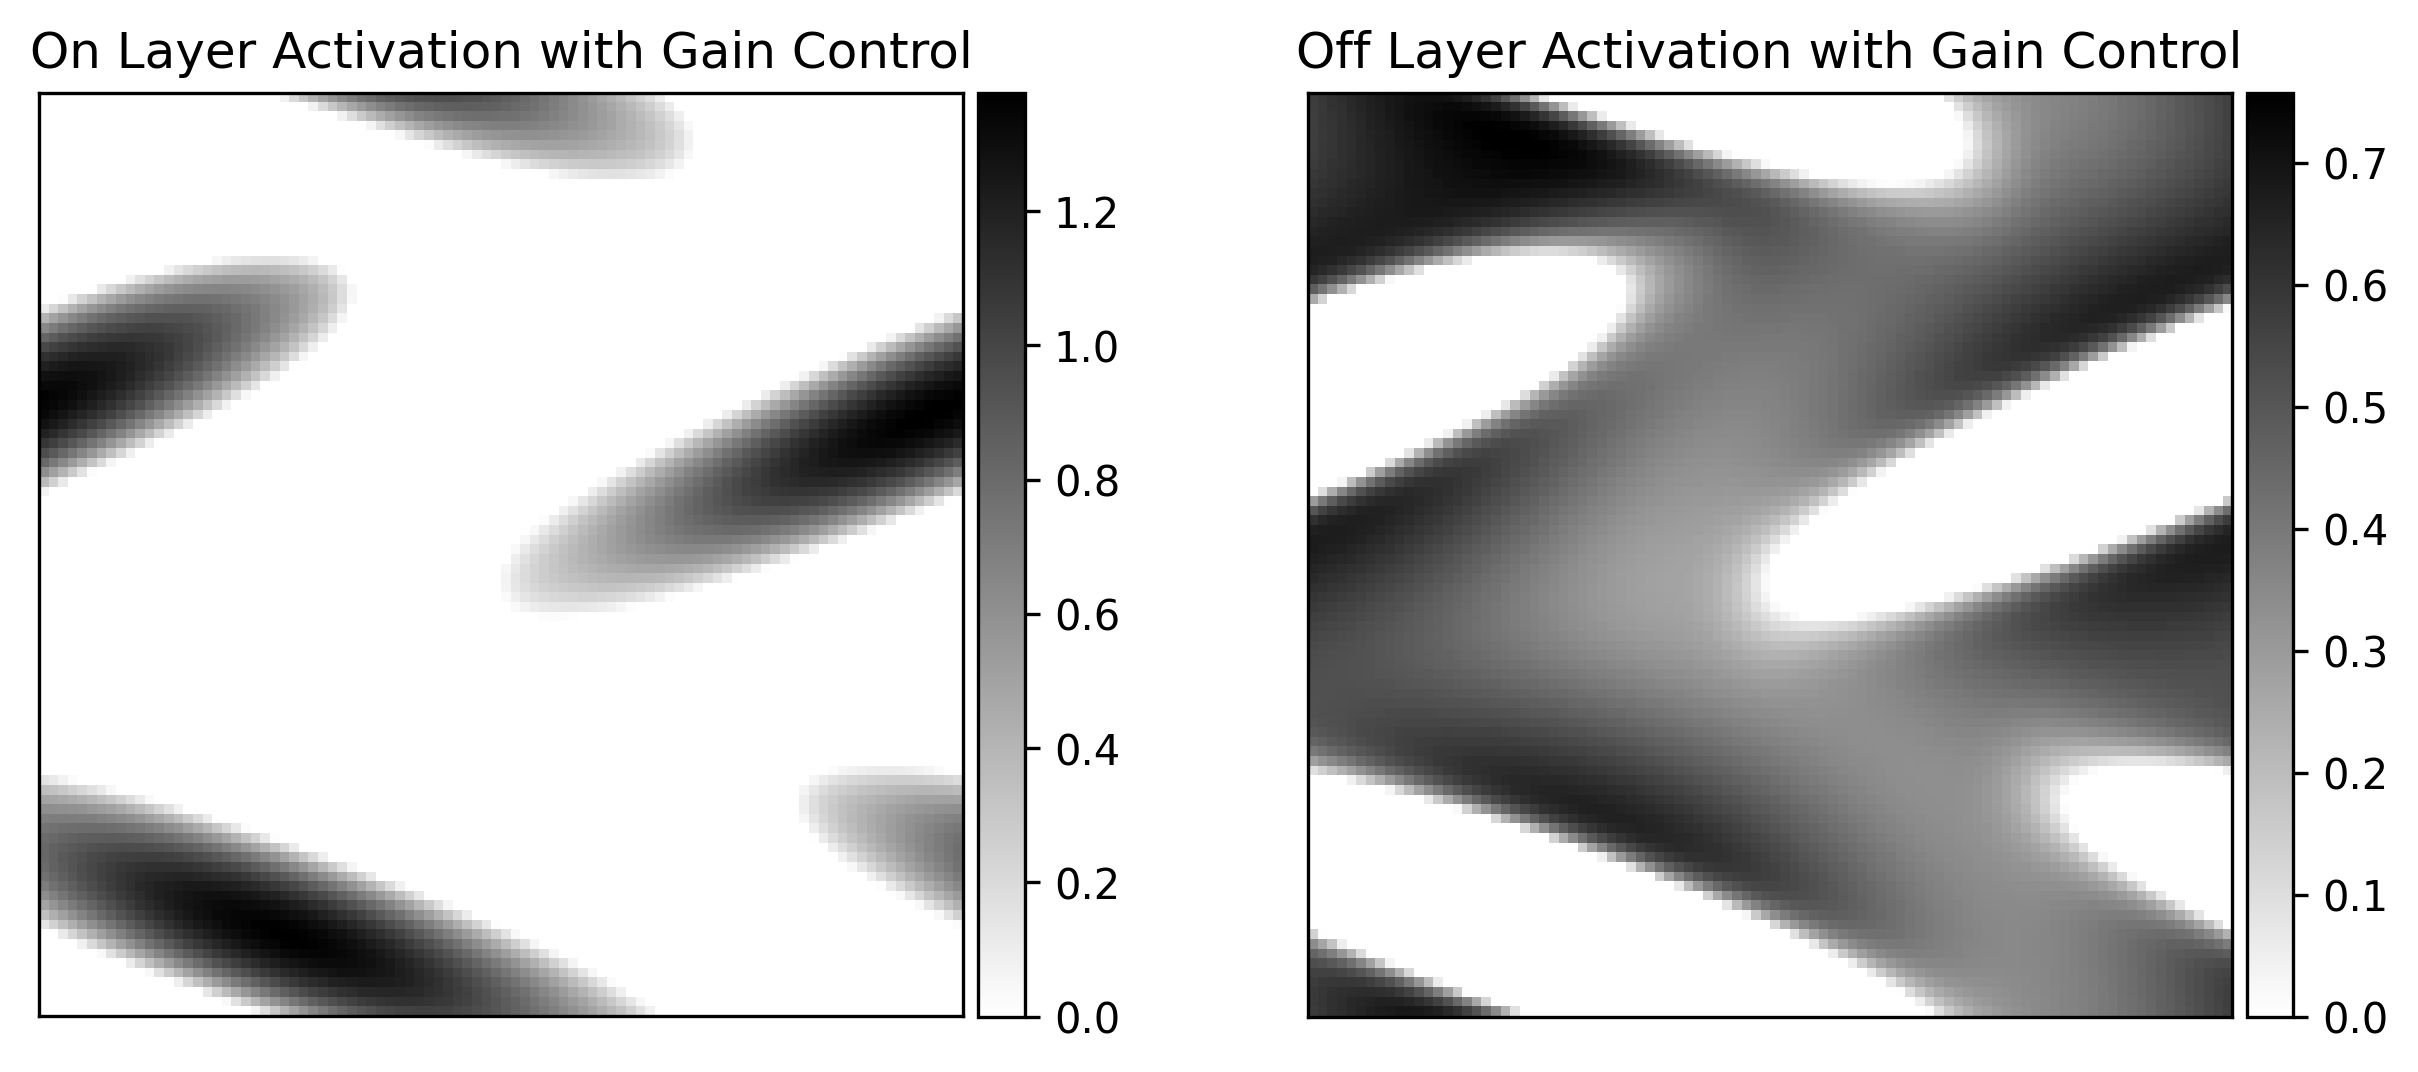

In [54]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=300)

for i in range(2):
    pf.imshowbar(fig,axs[i],lgn[i].reshape(N,N),cmap='binary')
        
axs[0].set_title('On Layer Activation with Gain Control')
axs[1].set_title('Off Layer Activation with Gain Control')

## Bars with Gain Control Stats

In [ ]:
reload(inputs)

cov_params = {
    'n_cov_params': {
        'sigma1':  0.07343857,
        'sigma2':  0.16119628,
        'ampl1':   0.09809787,
        'ampl2':   -0.03235812,
        'noise':   0.0,
        'profile': 'Mexican-hat',
        'nosumdiv': True,
    },

    'f_cov_params': {
        'sigma1':  0.10819111,
        'sigma2':  0.14820545,
        'ampl1':   0.11992125,
        'ampl2':   0.11992125,
        'noise':   0.0,
        'profile': 'Mexican-hat',
        'nosumdiv': True,
    },

    'o_cov_params': {
        'sigma1':  0.09874045,
        'sigma2':  0.21926803,
        'ampl1':   -0.08525667,
        'ampl2':   -0.0420941,
        'noise':   0.0,
        'profile': 'Mexican-hat',
        'nosumdiv': True,
    },
    
    'n_cov_base': -0.00834099,
    'f_cov_base': 0.00189555,
    'o_cov_base': -0.00673917,
    
    'n_mean': 0.16991828770795417,
    'f_mean': 0.2849416036708087
}

inp = inputs.Inputs_lgn((N,N),0,0,None,cov_params)

# Look at Bettina Model's LGN Input with Different On/Off Input

## Create LGN Activity Patterns

In [192]:
norm_params = {
    'onoff_corr_factor': 1.0,
    'input_type': 'white_noise_rect'
}

In [187]:
def res(x):
    gaus_params = norm_params.copy()
    gaus_params.update({
        'onoff_noise_mean': np.array([x[0],x[1]]),
        'onoff_noise_std': np.array([x[2],x[3]])
    })

    n_ret_patts = 100

    bett_gaus_N_act = np.zeros((n_ret_patts,N**2))
    bett_gaus_F_act = np.zeros((n_ret_patts,N**2))

    for i in range(n_ret_patts):
        lgn = inp.create_lgn_input(gaus_params,gaus_params['input_type'],WRtoT,expansion_timestep=0)
        bett_gaus_N_act[i] = lgn[0]
        bett_gaus_F_act[i] = lgn[1]
        
    return [np.mean(bett_gaus_N_act)-np.mean(gaus_N_act),
            np.mean(bett_gaus_F_act)-np.mean(gaus_F_act),
            np.std(bett_gaus_N_act)-np.std(gaus_N_act),
            np.std(bett_gaus_F_act)-np.std(gaus_F_act)]

sol = optimize.least_squares(res,[trunc_gaus_N_mean,trunc_gaus_F_mean,trunc_gaus_N_std,trunc_gaus_F_std],
                            xtol=None)
print(sol)
print()
print(sol.x)
trunc_gaus_N_mean,trunc_gaus_F_mean,trunc_gaus_N_std,trunc_gaus_F_std = sol.x

KeyboardInterrupt: 

In [202]:
gaus_params = norm_params.copy()
gaus_params.update({
    'onoff_noise_mean': np.array([-4,2]),
    'onoff_noise_std': np.array([trunc_gaus_N_std,trunc_gaus_F_std])
})

In [176]:
reload(inputs)

inp = inputs.Inputs_lgn((N,N),0,0)
lgn = inp.create_lgn_input(norm_params,norm_params['input_type'],WRtoT,expansion_timestep=0).numpy()

Text(0.5, 1.0, 'Input to LGN Histogram')

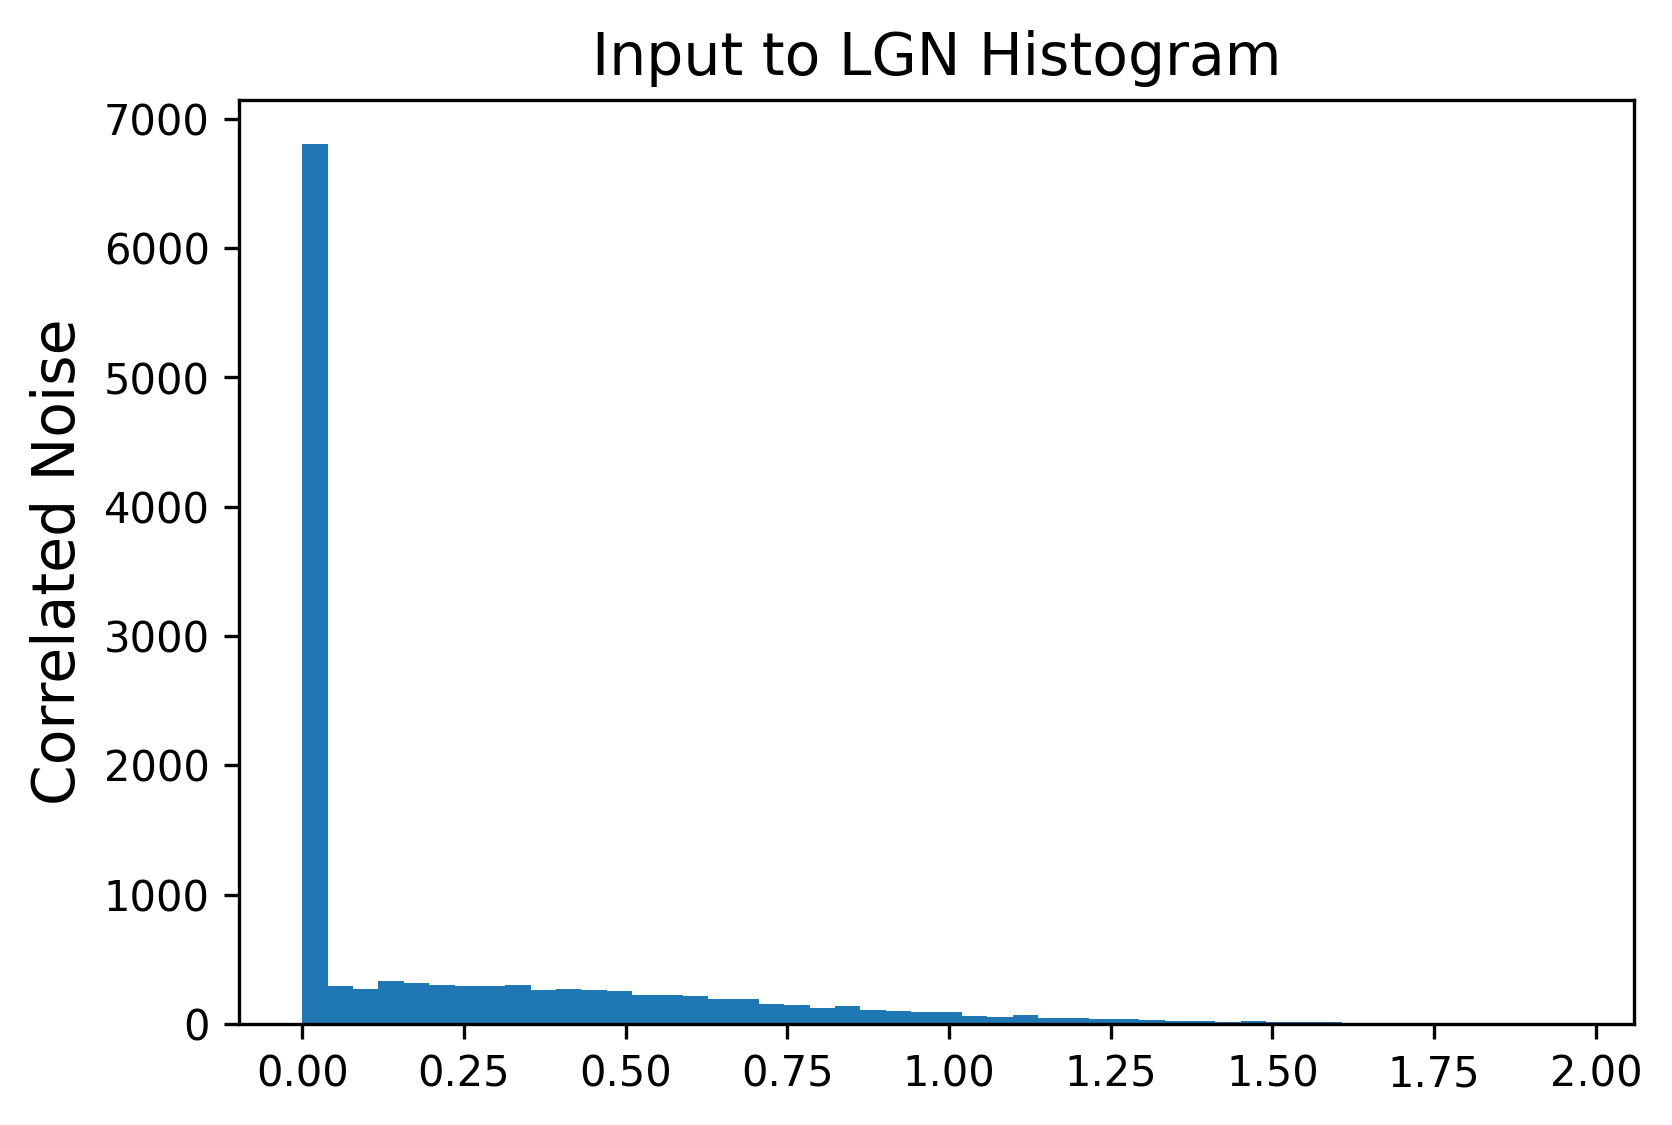

In [177]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.hist(5*lgn.flatten(),50)

axs.set_ylabel('Correlated Noise',fontsize=14)
axs.set_title('Input to LGN Histogram',fontsize=14)

In [203]:
n_ret_patts = 200

bett_gaus_N_act = np.zeros((n_ret_patts,N**2))
bett_gaus_F_act = np.zeros((n_ret_patts,N**2))

bett_norm_N_act = np.zeros((n_ret_patts,N**2))
bett_norm_F_act = np.zeros((n_ret_patts,N**2))

for i in range(n_ret_patts):
    lgn = inp.create_lgn_input(gaus_params,gaus_params['input_type'],WRtoT,expansion_timestep=0)
    bett_gaus_N_act[i] = lgn[0]
    bett_gaus_F_act[i] = lgn[1]
    
    lgn = inp.create_lgn_input(norm_params,norm_params['input_type'],WRtoT,expansion_timestep=0)
    bett_norm_N_act[i] = 5*lgn[0]
    bett_norm_F_act[i] = 5*lgn[1]

Text(0.5, 1.0, 'Off Cell Activity Histogram')

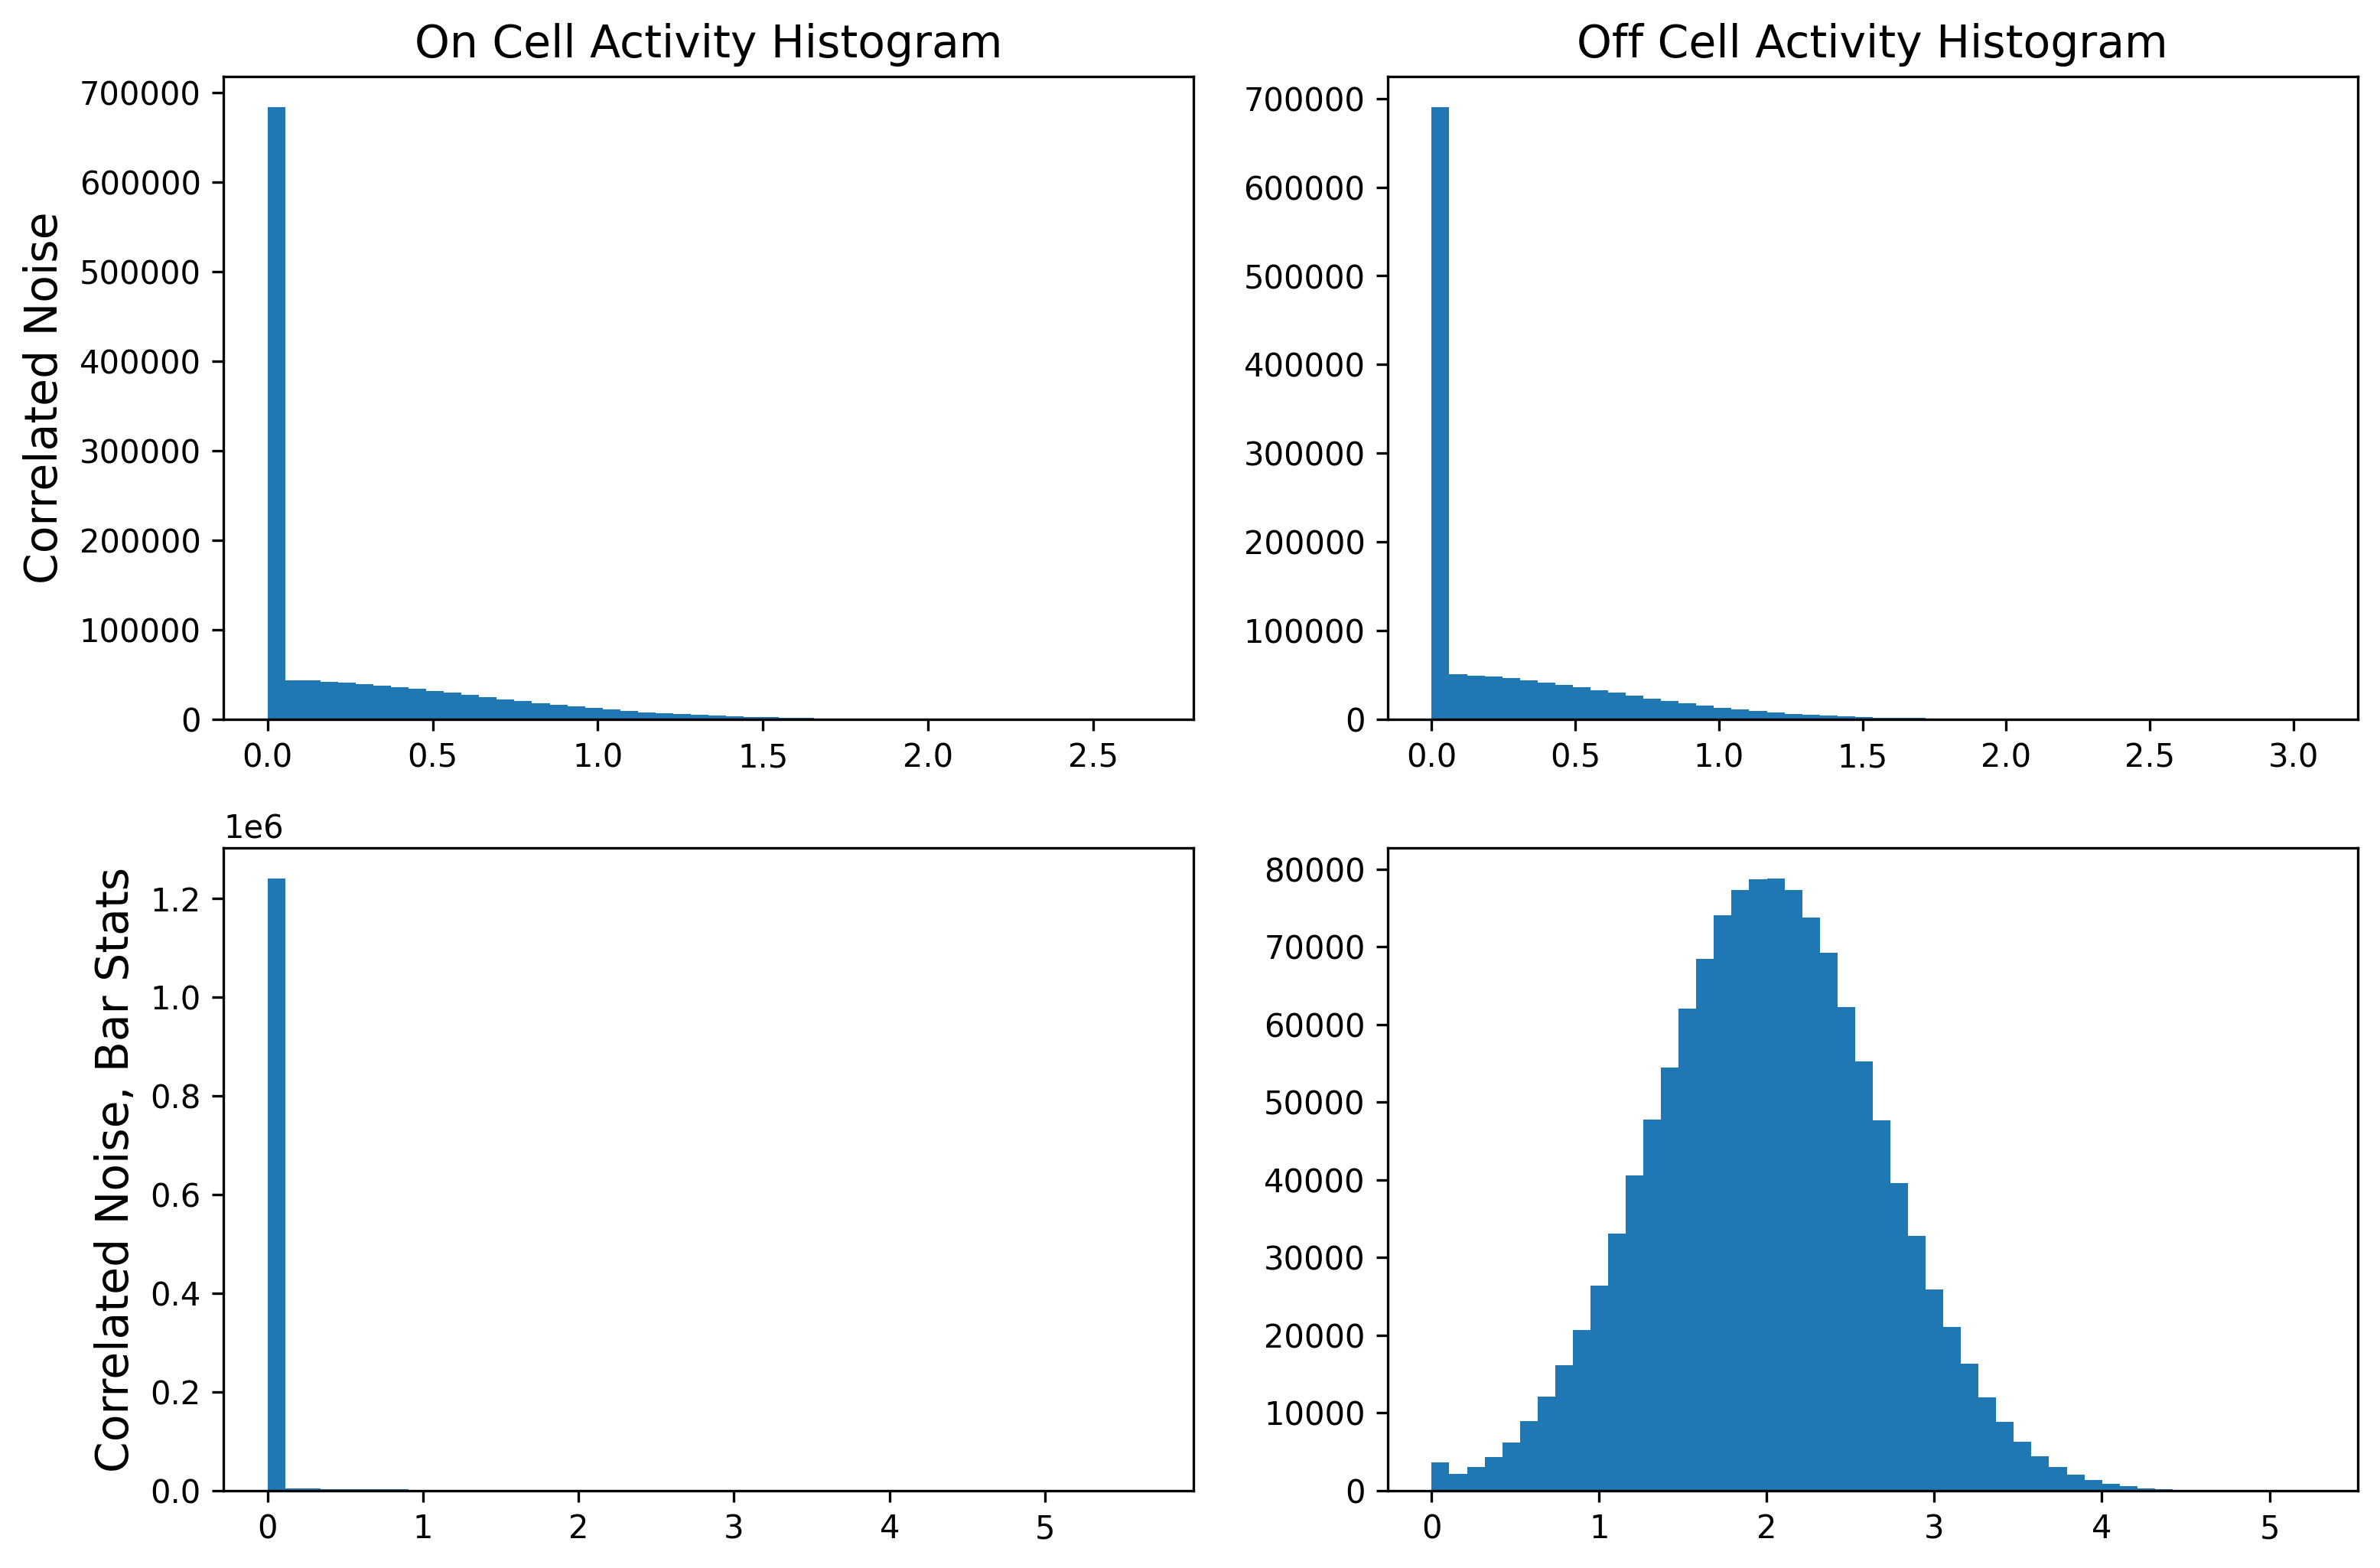

In [204]:
fig,axs = plt.subplots(2,2,figsize=(12,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0,0].hist(bett_norm_N_act.flatten(),50)
axs[0,1].hist(bett_norm_F_act.flatten(),50)
axs[1,0].hist(bett_gaus_N_act.flatten(),50)
axs[1,1].hist(bett_gaus_F_act.flatten(),50)

axs[0,0].set_ylabel('Correlated Noise',fontsize=14)
axs[1,0].set_ylabel('Correlated Noise, Bar Stats',fontsize=14)
axs[0,0].set_title('On Cell Activity Histogram',fontsize=14)
axs[0,1].set_title('Off Cell Activity Histogram',fontsize=14)

In [205]:
print(np.mean(bett_gaus_N_act))
print(np.mean(bett_gaus_F_act))
print()
print(np.std(bett_gaus_N_act))
print(np.std(bett_gaus_F_act))
print()
print(np.mean(bett_gaus_N_act[bett_gaus_N_act > 0]))
print(np.mean(bett_gaus_F_act[bett_gaus_F_act > 0]))
print()
print(np.std(bett_gaus_N_act[bett_gaus_N_act > 0]))
print(np.std(bett_gaus_F_act[bett_gaus_F_act > 0]))

0.029523455751914816
2.0004080627865535

0.21278964972017442
0.6775556323104115

0.868117510795777
2.004101559332229

0.7767968726534504
0.6727013661061477


## Calculate Spatial Correlations

In [156]:
bett_norm_full_cov = np.cov(bett_norm_N_act.T,bett_norm_F_act.T)
bett_norm_NN_cov = bett_norm_full_cov[:N**2,:N**2]
bett_norm_NF_cov = bett_norm_full_cov[:N**2,N**2:]
bett_norm_FN_cov = bett_norm_full_cov[N**2:,:N**2]
bett_norm_FF_cov = bett_norm_full_cov[N**2:,N**2:]

bett_gaus_full_cov = np.cov(bett_gaus_N_act.T,bett_gaus_F_act.T)
bett_gaus_NN_cov = bett_gaus_full_cov[:N**2,:N**2]
bett_gaus_NF_cov = bett_gaus_full_cov[:N**2,N**2:]
bett_gaus_FN_cov = bett_gaus_full_cov[N**2:,:N**2]
bett_gaus_FF_cov = bett_gaus_full_cov[N**2:,N**2:]

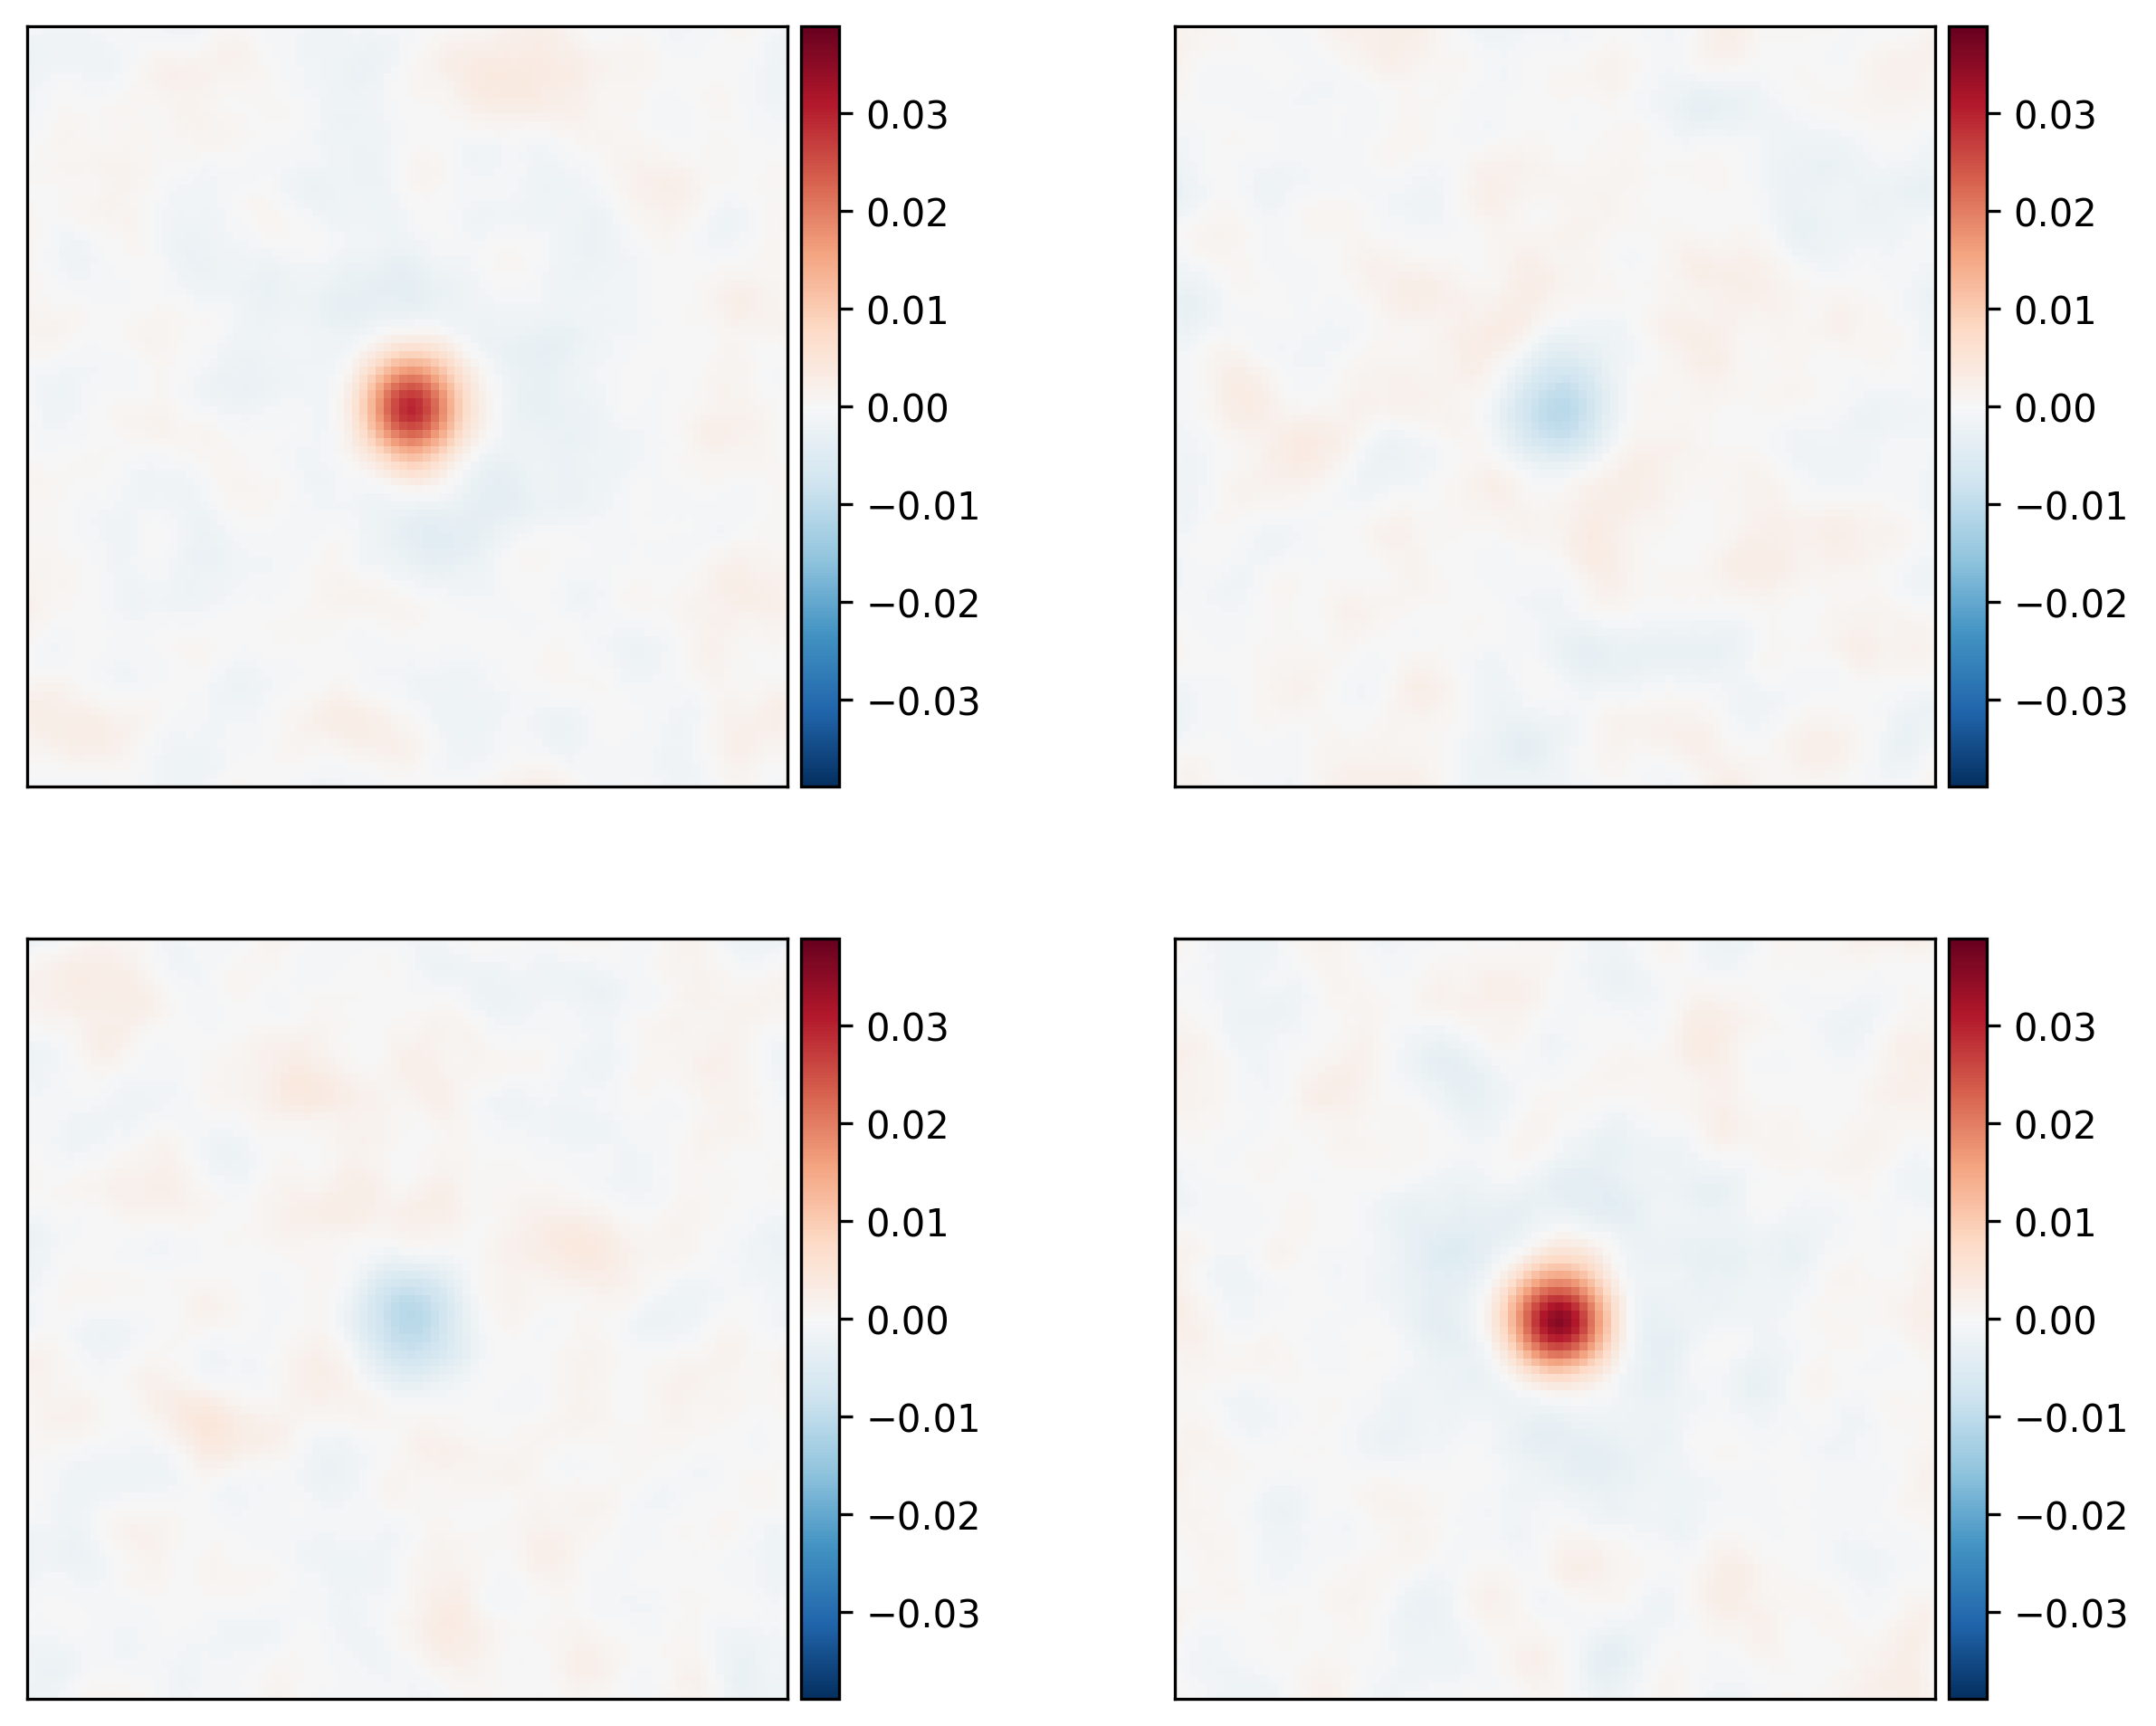

In [29]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

lim = np.max(np.abs(bett_full_cov))

pf.imshowbar(fig,axs[0,0],bett_NN_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[0,1],bett_NF_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[1,0],bett_FN_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)
pf.imshowbar(fig,axs[1,1],bett_FF_cov.reshape(N,N,N,N)[N//2,N//2,:,:],vmin=-lim,vmax=lim)

In [157]:
dists = np.linspace(0,0.71,72)
bin_idxs = np.digitize(ds,np.linspace(0,0.7,71)+0.005)

bett_norm_S_cov = np.zeros(72)
bett_norm_S_cov_err = np.zeros(72)
bett_norm_D_cov = np.zeros(72)
bett_norm_D_cov_err = np.zeros(72)

bett_gaus_SN_cov = np.zeros(72)
bett_gaus_SN_cov_err = np.zeros(72)
bett_gaus_SF_cov = np.zeros(72)
bett_gaus_SF_cov_err = np.zeros(72)
bett_gaus_D_cov = np.zeros(72)
bett_gaus_D_cov_err = np.zeros(72)

for idx in range(72):
    bett_norm_S_cov[idx] = 0.5*(np.mean(bett_norm_NN_cov[bin_idxs == idx]) +\
                                np.mean(bett_norm_FF_cov[bin_idxs == idx]))
    bett_norm_S_cov_err[idx] = np.sqrt(np.var(bett_norm_NN_cov[bin_idxs == idx]) +\
                                       np.var(bett_norm_FF_cov[bin_idxs == idx]))
    bett_norm_D_cov[idx] = 0.5*(np.mean(bett_norm_NF_cov[bin_idxs == idx]) +\
                                np.mean(bett_norm_NF_cov[bin_idxs == idx]))
    bett_norm_D_cov_err[idx] = np.sqrt(np.var(bett_norm_NF_cov[bin_idxs == idx]) +\
                                       np.var(bett_norm_NF_cov[bin_idxs == idx]))
    
    bett_gaus_SN_cov[idx] = np.mean(bett_gaus_NN_cov[bin_idxs == idx])
    bett_gaus_SN_cov_err[idx] = np.sqrt(np.var(bett_gaus_NN_cov[bin_idxs == idx]))
    bett_gaus_SF_cov[idx] = np.mean(bett_gaus_FF_cov[bin_idxs == idx])
    bett_gaus_SF_cov_err[idx] = np.sqrt(np.var(bett_gaus_FF_cov[bin_idxs == idx]))
    bett_gaus_D_cov[idx] = 0.5*(np.mean(bett_gaus_NF_cov[bin_idxs == idx]) +\
                                np.mean(bett_gaus_NF_cov[bin_idxs == idx]))
    bett_gaus_D_cov_err[idx] = np.sqrt(np.var(bett_gaus_NF_cov[bin_idxs == idx]) +\
                                       np.var(bett_gaus_NF_cov[bin_idxs == idx]))

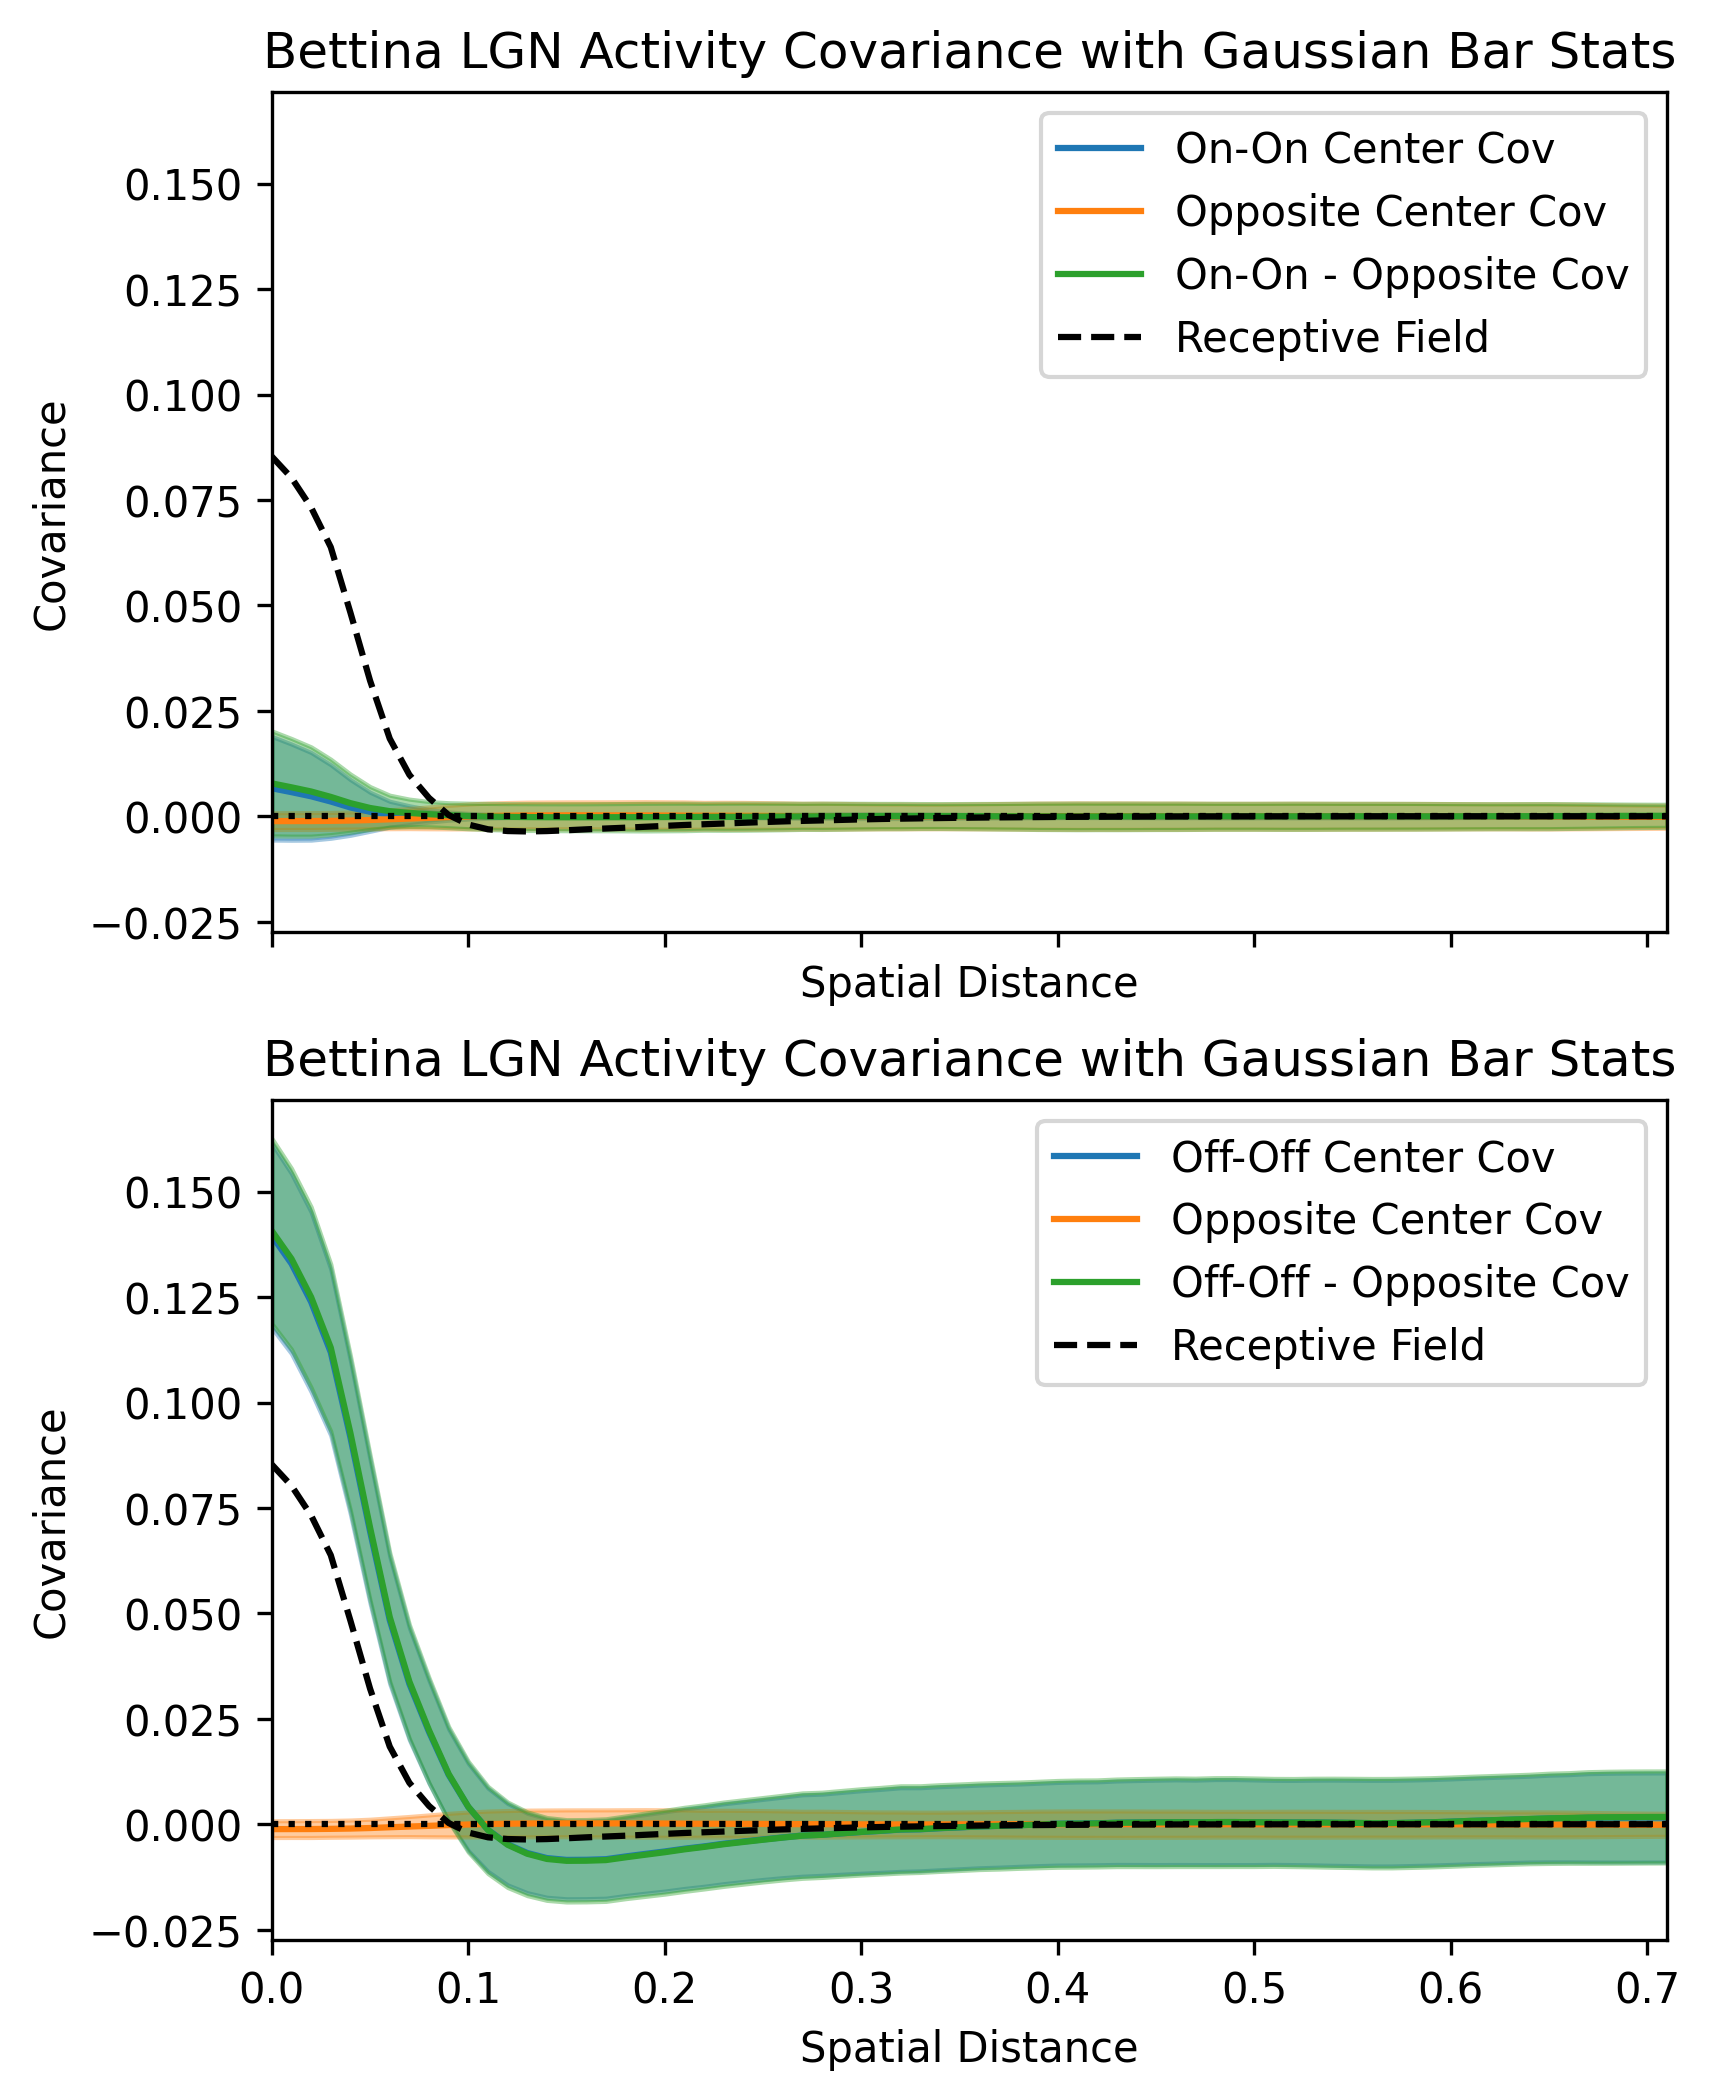

In [159]:
fig,axs = plt.subplots(2,1,figsize=(6,8),dpi=300,sharex=True,sharey=True)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0].plot(dists,bett_gaus_SN_cov,c='C0',label='On-On Center Cov')
axs[0].fill_between(dists,bett_gaus_SN_cov-bett_gaus_SN_cov_err,bett_gaus_SN_cov+bett_gaus_SN_cov_err,
                    color='C0',alpha=0.4)
axs[1].plot(dists,bett_gaus_SF_cov,c='C0',label='Off-Off Center Cov')
axs[1].fill_between(dists,bett_gaus_SF_cov-bett_gaus_SF_cov_err,bett_gaus_SF_cov+bett_gaus_SF_cov_err,
                    color='C0',alpha=0.4)
axs[0].plot(dists,bett_gaus_D_cov,c='C1',label='Opposite Center Cov')
axs[0].fill_between(dists,bett_gaus_D_cov-bett_gaus_D_cov_err,bett_gaus_D_cov+bett_gaus_D_cov_err,
                    color='C1',alpha=0.4)
axs[1].plot(dists,bett_gaus_D_cov,c='C1',label='Opposite Center Cov')
axs[1].fill_between(dists,bett_gaus_D_cov-bett_gaus_D_cov_err,bett_gaus_D_cov+bett_gaus_D_cov_err,
                    color='C1',alpha=0.4)
axs[0].plot(dists,bett_gaus_SN_cov-bett_gaus_D_cov,c='C2',label='On-On - Opposite Cov')
axs[0].fill_between(dists,bett_gaus_SN_cov-bett_gaus_D_cov-\
                    np.sqrt(bett_gaus_SN_cov_err**2+bett_gaus_D_cov_err**2),
                    bett_gaus_SN_cov-bett_gaus_D_cov+\
                    np.sqrt(bett_gaus_SN_cov_err**2+bett_gaus_D_cov_err**2),color='C2',alpha=0.4)
axs[1].plot(dists,bett_gaus_SF_cov-bett_gaus_D_cov,c='C2',label='Off-Off - Opposite Cov')
axs[1].fill_between(dists,bett_gaus_SF_cov-bett_gaus_D_cov-\
                    np.sqrt(bett_gaus_SF_cov_err**2+bett_gaus_D_cov_err**2),
                    bett_gaus_SF_cov-bett_gaus_D_cov+\
                    np.sqrt(bett_gaus_SF_cov_err**2+bett_gaus_D_cov_err**2),
                    color='C2',alpha=0.4)

for i in range(2):
    axs[i].plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
    axs[i].axhline(0,c='k',ls=':')
    
    axs[i].legend()
    
    axs[i].set_xlim(dists[0],dists[-1])
    
    axs[i].set_xlabel('Spatial Distance')
    axs[i].set_ylabel('Covariance')
    axs[i].set_title('Bettina LGN Activity Covariance with Gaussian Bar Stats')

Text(0.5, 1.0, 'Bettina LGN Activity Covariance')

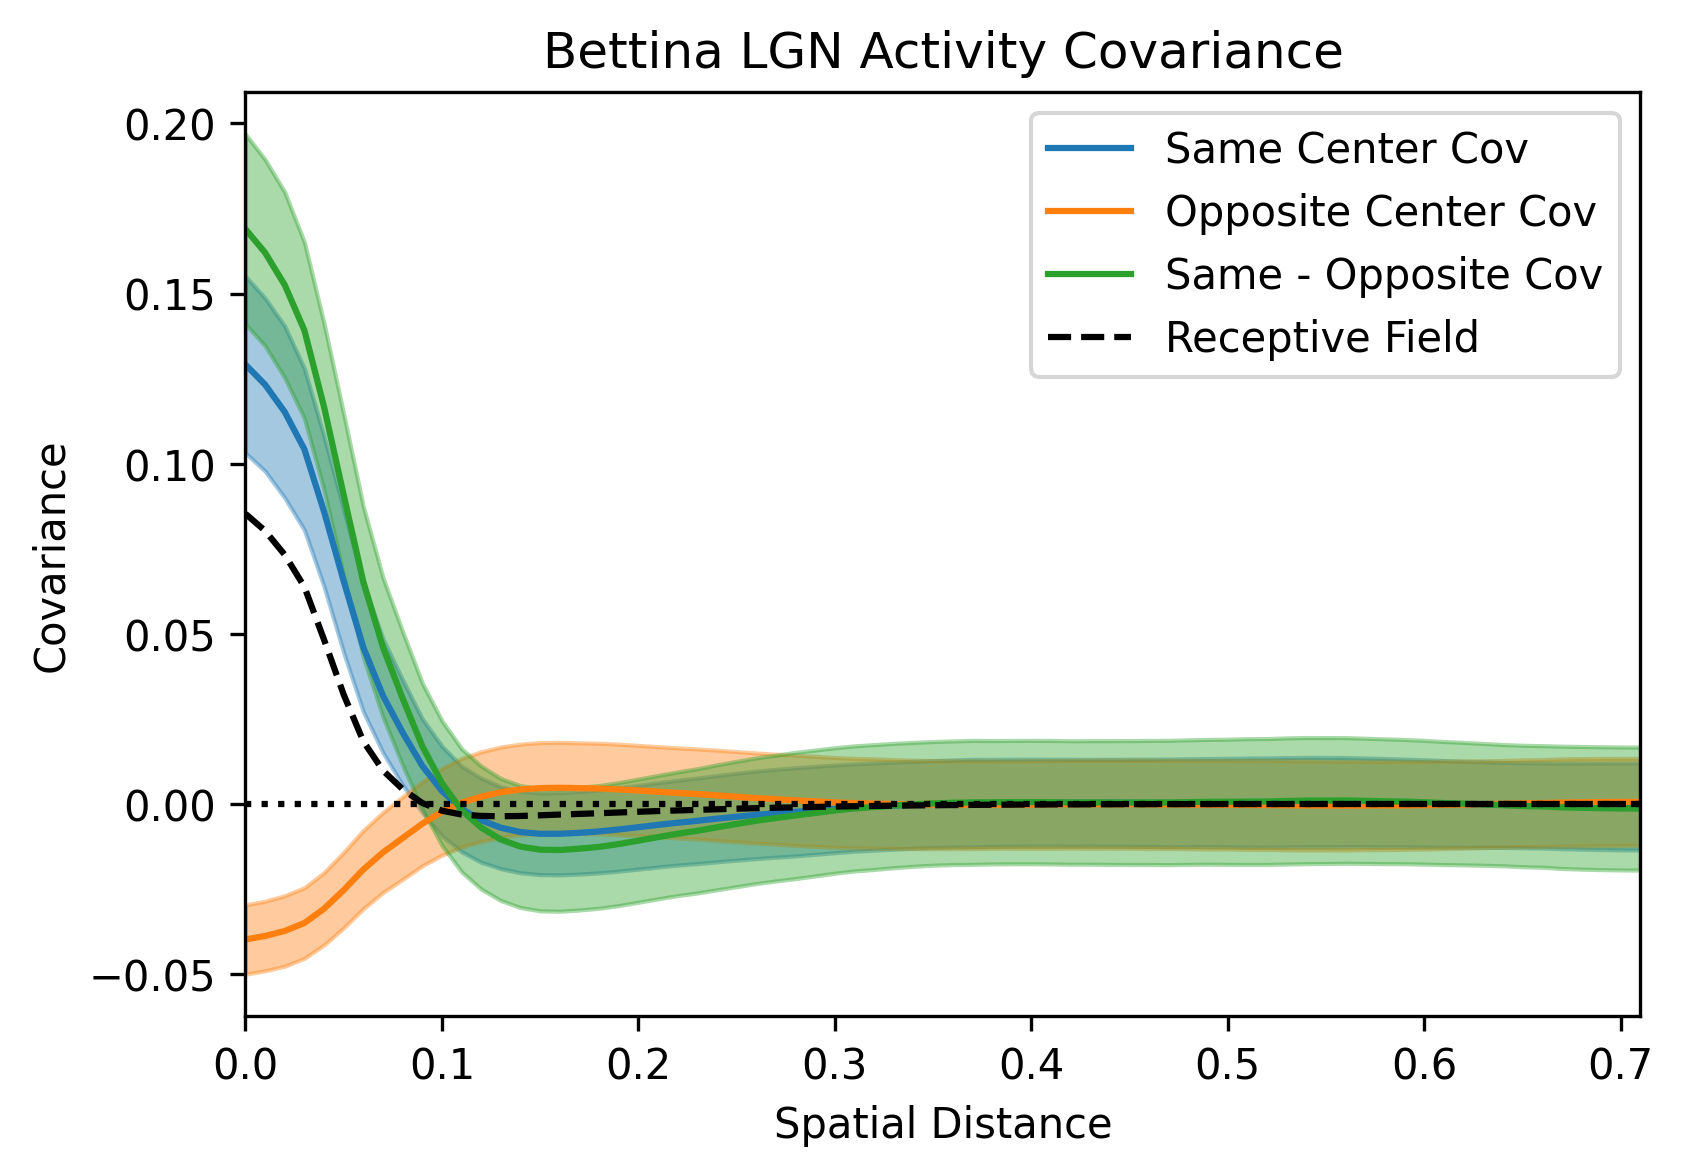

In [161]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,bett_norm_S_cov,c='C0',label='Same Center Cov')
axs.fill_between(dists,bett_norm_S_cov-bett_norm_S_cov_err,bett_norm_S_cov+bett_norm_S_cov_err,
                 color='C0',alpha=0.4)
axs.plot(dists,bett_norm_D_cov,c='C1',label='Opposite Center Cov')
axs.fill_between(dists,bett_norm_D_cov-bett_norm_D_cov_err,bett_norm_D_cov+bett_norm_D_cov_err,
                 color='C1',alpha=0.4)
axs.plot(dists,bett_norm_S_cov-bett_norm_D_cov,c='C2',label='Same - Opposite Cov')
axs.fill_between(dists,bett_norm_S_cov-bett_norm_D_cov-np.sqrt(bett_norm_S_cov_err**2+bett_norm_D_cov_err**2),
                 bett_norm_S_cov-bett_norm_D_cov+np.sqrt(bett_norm_S_cov_err**2+bett_norm_D_cov_err**2),
                 color='C2',alpha=0.4)
axs.plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Bettina LGN Activity Covariance')

Text(0.5, 1.0, 'Bettina LGN Activity Covariance')

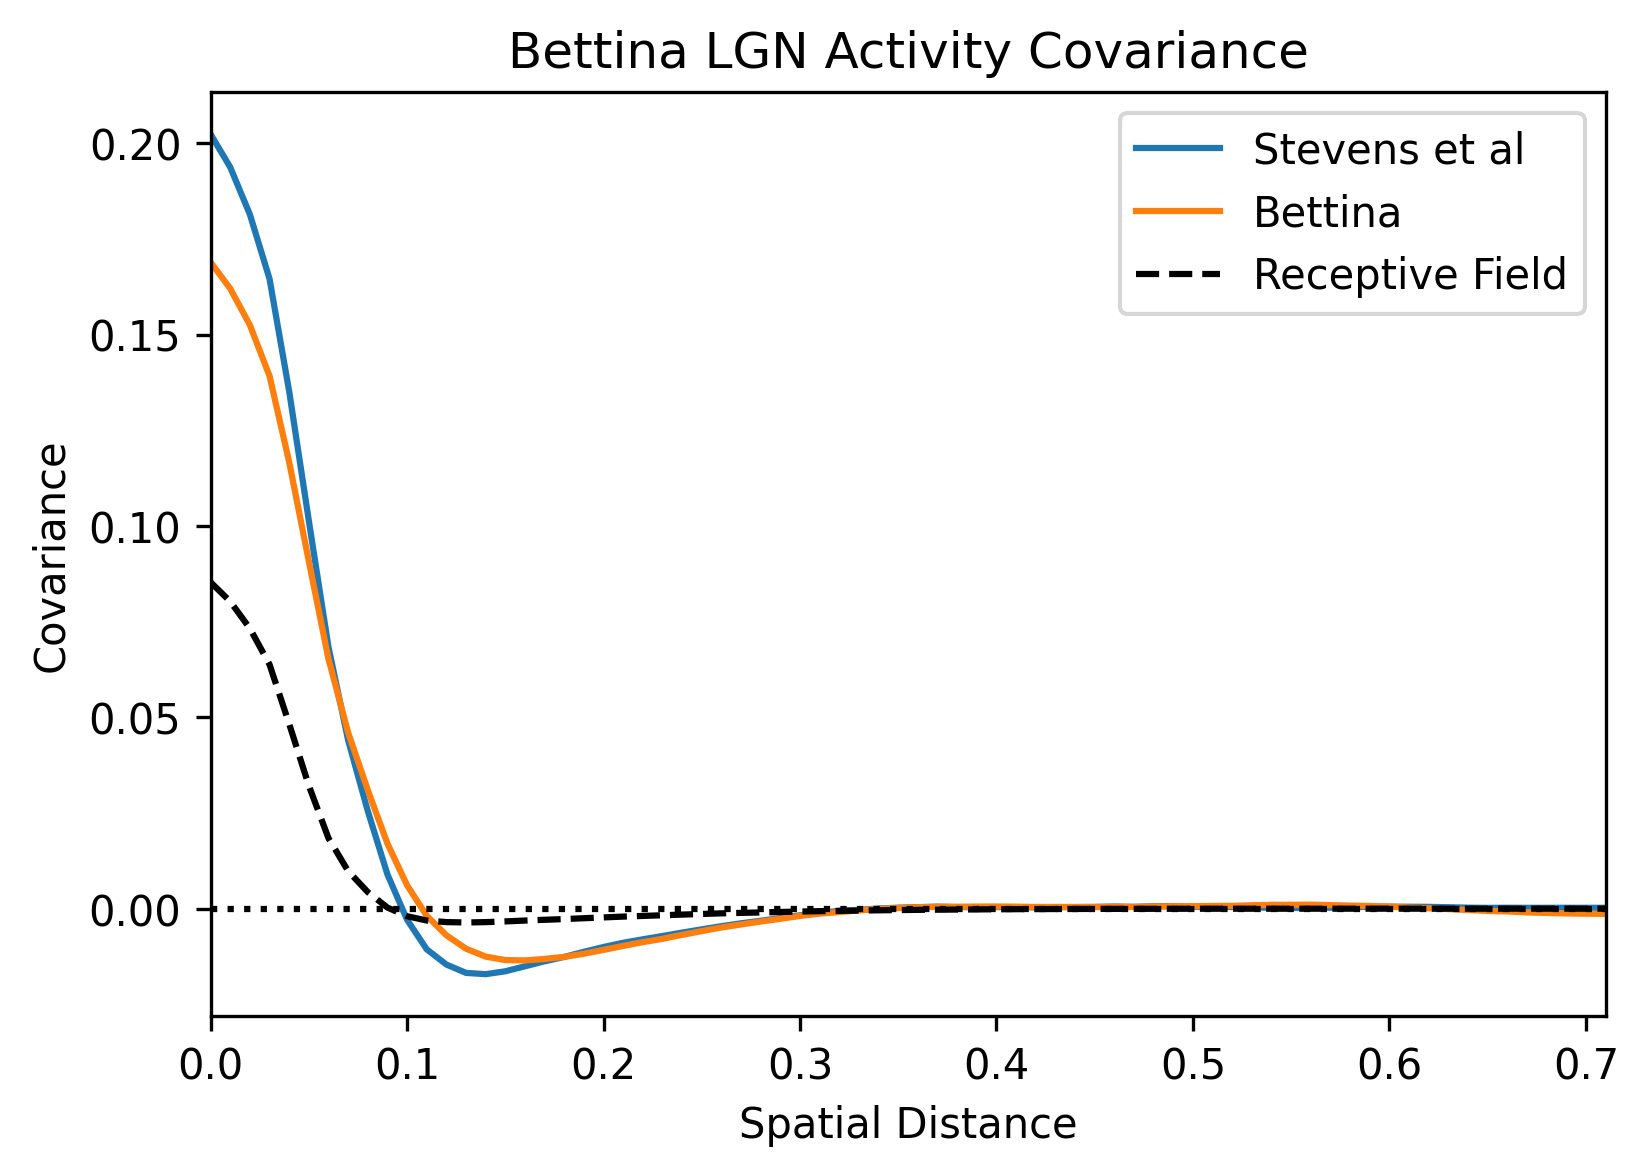

In [163]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,norm_S_cov - norm_D_cov,c='C0',label='Stevens et al')
axs.plot(dists,bett_norm_S_cov - bett_norm_D_cov,c='C1',label='Bettina')
axs.plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
axs.set_title('Bettina LGN Activity Covariance')